In [ ]:
merged_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/sythesize_from_scratch/test_merged_data.csv")
merged_df.columns

In [26]:
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
#CANDIDATE_FEATURES = ["event_id","event_type", "event_city"]
CANDIDATE_FEATURES = ["event_id", "title","event_type", "event_city"]

## <span style="color:#ff5f27">🧬 Train Retrieval Model </span>



## <span style="color:#ff5f27">📝 Imports </span>


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Normalization
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import hopsworks
import warnings
import re
warnings.filterwarnings('ignore')

In [53]:
# Load feature view and feature groups
feature_view = fs.get_feature_view(name='event_retrieval', version=1)
users_df = fs.get_feature_group("users", version=1).read()
events_df = fs.get_feature_group("events", version=1).read()
interactions_df = fs.get_feature_group("interactions", version=1).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.21s) 


In [54]:
users_df.head()

user_id   user_lat    user_lon user_city user_weather_preference  age  \
0  JI904B  36.122607  138.598711     Tokyo                 outdoor   27   
1  YF384K -33.897451  151.157340    Sydney                     any   26   
2  RJ912O  40.593968  -72.327571  New York                  indoor   24   
3  RI446X  49.275224    3.051093     Paris                  indoor   34   
4  WJ937D  19.132102   72.899339    Mumbai                 outdoor   28   

        user_interests                      signup_date  social_connectedness  
0                music 2023-07-24 10:35:22.959064+00:00                    11  
1  music cinema sports 2023-04-24 20:46:40.735141+00:00                    17  
2               travel 2023-10-13 11:37:21.333403+00:00                    16  
3              fitness 2025-03-11 14:01:29.686139+00:00                    16  
4         food fashion 2024-04-04 03:15:33.598011+00:00                    29

In [ ]:
events_df.head()

In [ ]:
interactions_df.head()

## <span style="color:#ff5f27">🔮 Connect to Hopsworks Feature Store </span>

In [5]:

# Connect to Hopsworks Feature Store
project = hopsworks.login()
fs = project.get_feature_store()



2025-05-14 09:12:27,352 INFO: Initializing external client
2025-05-14 09:12:27,359 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-05-14 09:12:28,992 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


---

## <span style="color:#ff5f27">🔪 Feature Selection </span>


In [40]:
import tensorflow as tf
import pandas as pd

# Load from Hopsworks feature groups
users_fg = fs.get_feature_group(name="users", version=1)
events_fg = fs.get_feature_group(name="events", version=1)
interactions_fg = fs.get_feature_group(name="interactions", version=1)


In [3]:
import pandas as pd
merged_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/sythesize_from_scratch/test_merged_data.csv")

In [3]:

# Define features for query and candidate towers (retrieval model only)
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "title","event_type", "event_city"]

In [41]:

# Join user + event features with interactions
selected_features = interactions_fg.select(["interaction_id"])\
    .join(users_fg.select(QUERY_FEATURES), on="user_id")\
    .join(events_fg.select(CANDIDATE_FEATURES), on="event_id")


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [ ]:

# Create feature view
feature_view = fs.create_feature_view(
    name='event_retrieval',
    version=1,
    query=selected_features,
)


## <span style="color:#ff5f27">🏋️ Training Dataset </span>


In [6]:
feature_view = fs.get_feature_view(
    name='event_retrieval',
    version=1,
)

In [7]:
# Split dataset
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.01,
    description='Event retrieval dataset splits',
)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (14.47s) 


In [ ]:
train_df.head()

In [8]:
# Prepare vocabulary lists for Lookup & Embedding layers
user_id_list = train_df["user_id"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
user_city_list = train_df["user_city"].unique().tolist()
event_city_list = train_df["event_city"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()
user_interest_list = train_df["user_interests"].unique().tolist()
title_list = train_df["title"].unique().tolist()

# Print summary
print(f"✅ Training set size: {len(train_df)}")
print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")


✅ Training set size: 147551
📌 Unique Users: 24970, Events: 15394


## <span style="color:#ff5f27">🏰 Two Tower Model </span>


In [9]:
# Improved Two-Tower Model with Enhanced Regularization
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict
import pandas as pd
import numpy as np

# Load data
# users_df = pd.read_csv('/home/nkama/masters_thesis_project/users_data_test.csv')
# events_df = pd.read_csv("/home/nkama/masters_thesis_project/events_data_test.csv")
# interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/interactions_data_test.csv')



# # Merge user/event features into interactions
# interactions_df = interactions_df.merge(users_df, on="user_id", how="inner")
# interactions_df = interactions_df.merge(events_df, on="event_id", how="inner")

# # Feature sets
# USER_FEATURES = ['user_id', 'gender', 'age', 'indoor_outdoor_preference', 'user_lat', 'user_lng', 'user_interests']
# EVENT_FEATURES = ['event_id', 'category', 'title', 'event_type', 'event_lat', 'event_lng', 'hour', 'day_of_week', 'is_weekend']
# string_cols = ['user_id', 'event_id', 'gender', 'indoor_outdoor_preference', 'category', 'title', 'event_type', 'user_interests']

QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# # Drop missing values
# interactions_df = interactions_df.dropna()
# interactions_df = interactions_df[QUERY_FEATURES + CANDIDATE_FEATURES]
# interactions_df = interactions_df.sample(n=50000, random_state=42)

# interactions_df["user_id"] = interactions_df["user_id"].astype(str)
# interactions_df["event_id"] = interactions_df["event_id"].astype(str)
# events_df["event_id"] = events_df["event_id"].astype(str)

# def df_to_ds(df):
#     return tf.data.Dataset.from_tensor_slices({
#         col: tf.constant(df[col].values) for col in df.columns
#     })


# Reduced embedding dimension
EMBED_DIM = 64  # Reduced from 64
BATCH_SIZE = 1024
L2_REG = 0.00001  # Increased L2 regularization (10x stronger)
DROPOUT_RATE = 0.3  # Increased dropout rate

# # Define features for query and candidate towers
# QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
# CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# train_df = interactions_df.sample(frac=0.9, random_state=42)
# val_df = interactions_df.drop(train_df.index)



# # Prepare vocabulary lists for Lookup & Embedding layers
# user_id_list = users_df["user_id"].astype(str).unique().tolist()
# event_id_list = events_df["event_id"].astype(str).unique().tolist()
# user_city_list = train_df["location"].unique().tolist()
# event_city_list = train_df["city"].unique().tolist()
# event_type_list = train_df["category"].unique().tolist()
# user_interest_list = train_df["user_interests"].unique().tolist()
# title_list = train_df["title"].unique().tolist()

# # Print summary
# print(f"✅ Training set size: {len(train_df)}")
# print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")


# Build tf.data.Dataset with proper tensor shapes
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({
        col: tf.constant(df[col].values) for col in df.columns
    })

# Create datasets with proper batching and shuffling
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()

# Create item dataset with proper tensor shapes
item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
item_ds = tf.data.Dataset.from_tensor_slices({
    col: tf.constant(item_df[col].astype(str).values) for col in CANDIDATE_FEATURES
})

# Query Tower with improved regularization
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # User ID embedding with stronger L2 regularization
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)  # Max-norm constraint
            )
        ])

        # Age normalization with batch norm
        self.normalized_age = tf.keras.layers.Normalization(axis=None)
        
        # City embedding with regularization
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Text processing with int mode and reduced complexity
        self.interest_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=500,
            output_mode='int',
            output_sequence_length=15
        )


        self.interest_embedding = tf.keras.layers.Embedding(
            input_dim=501,  # max_tokens + 1 for OOV
            output_dim=self.emb_dim//2,  # Reduced dimension
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),  # Added activity regularization
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text features
        interests_encoded = self.interest_vectorizer(inputs["user_interests"])
        interests_embedding = self.interest_embedding(interests_encoded)
        pooled_interests = tf.reduce_mean(interests_embedding, axis=1)
        
        # Process city with embedding instead of one-hot
        city_emb = self.city_embedding(inputs["user_city"])
        
        # Add Gaussian noise during training for better generalization
        age_normalized = self.normalized_age(inputs["age"])
        if training:
            age_normalized = age_normalized + tf.random.normal(
                tf.shape(age_normalized), mean=0.0, stddev=0.1
            )
        
        # Concatenate features
        combined = tf.concat([
            self.user_embedding(inputs["user_id"]),
            tf.reshape(age_normalized, (-1, 1)),
            city_emb,
            pooled_interests
        ], axis=1)

        return self.fnn(combined)

# Item Tower with improved regularization
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # Event ID embedding with stronger L2 regularization
        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Type and city embeddings with regularization
        self.type_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_type_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_type_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])
        
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Simplified title processing
        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=1000,  # Reduced from 1000
            output_mode='int',
            output_sequence_length=15  # Reduced from 20
        )
        self.title_embedding = tf.keras.layers.Embedding(
            input_dim=1001, 
            output_dim=32,  # Reduced from 64
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )
        self.title_pool = tf.keras.layers.GlobalAveragePooling1D()  # Simpler pooling

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text with simpler approach
        title_encoded = self.title_vectorizer(inputs["title"])
        title_embedding = self.title_embedding(title_encoded)
        pooled_title = self.title_pool(title_embedding)
        
        # Process categorical features with embeddings
        type_emb = self.type_embedding(inputs["event_type"])
        city_emb = self.city_embedding(inputs["event_city"])
        
        # Concatenate features
        combined = tf.concat([
            self.event_embedding(inputs["event_id"]),
            type_emb,
            city_emb,
            pooled_title
        ], axis=1)

        return self.fnn(combined)
    
# Initialize models
query_model = QueryTower()
item_model = ItemTower()

# Adapt layers to training data
query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"].values)
item_model.title_vectorizer.adapt(item_df["title"].values)

# Initialize models with sample data
query_sample = next(iter(df_to_ds(train_df[QUERY_FEATURES]).batch(1)))
item_sample = next(iter(df_to_ds(item_df[CANDIDATE_FEATURES]).batch(1)))
_ = query_model(query_sample)
_ = item_model(item_sample)

item_ds = df_to_ds(item_df).batch(512)
# Fixed Two-Tower Model with proper candidate handling
class TwoTowerModel(tfrs.models.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        
        # Temperature parameter for scaling similarity scores
        self.temperature = tf.Variable(0.2, trainable=True)  # Increased from 0.1
        
        # Create candidates dataset with proper batching and mapping
        candidates = item_ds.map(
            lambda x: (x["event_id"], self.item_model(x))
        )
        
        # Set up retrieval task with factorized top-k
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=candidates
            ),
            temperature=self.temperature
        )
    def call(self, features):
        query_inputs = {k: features[k] for k in QUERY_FEATURES}
        item_inputs = {k: features[k] for k in CANDIDATE_FEATURES}
        return self.query_model(query_inputs), self.item_model(item_inputs)

    
    def compute_loss(self, features, training=False):
        query_inputs = {k: features[k] for k in QUERY_FEATURES}
        item_inputs = {k: features[k] for k in CANDIDATE_FEATURES}

        query_embeddings = self.query_model(query_inputs, training=training)
        item_embeddings = self.item_model(item_inputs, training=training)

        return self.task(query_embeddings, item_embeddings)


# Create and compile model with optimized learning rate
model = TwoTowerModel(query_model, item_model)

# Optimizer with learning rate schedule and weight decay
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=5e-4, 
        decay_steps=10000
    ),
    weight_decay=0.01,  
    clipnorm=1.0
)

model.compile(optimizer=optimizer)
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Increased max epochs
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            patience=100,  # Increased patience
            restore_best_weights=True,
            min_delta=0.001  # Minimum improvement required
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
        
    ]
)

# Evaluate final performance
eval_results = model.evaluate(
    val_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")




Epoch 1/10
145/145 [==============================] - 86s 548ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1517 - factorized_top_k/top_5_categorical_accuracy: 0.1826 - factorized_top_k/top_10_categorical_accuracy: 0.2058 - factorized_top_k/top_50_categorical_accuracy: 0.3163 - factorized_top_k/top_100_categorical_accuracy: 0.3862 - loss: 12134.5552 - regularization_loss: 0.0163 - total_loss: 12134.5715 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 6.0321e-05 - val_factorized_top_k/top_10_categorical_accuracy: 0.0070 - val_factorized_top_k/top_50_categorical_accuracy: 0.5641 - val_factorized_top_k/top_100_categorical_accuracy: 0.5645 - val_loss: 1021.9590 - val_regularization_loss: 0.0158 - val_total_loss: 1021.9748 - lr: 4.9974e-04
Epoch 2/10
145/145 [==============================] - 78s 530ms/step - factorized_top_k/top_1_categorical_accuracy: 0.3597 - factorized_top_k/top_5_categorical_accuracy: 0.4541 - f

In [ ]:
# Extract embeddings for all items
item_embeddings = []
item_ids = []

for batch in item_ds:
    emb = model.item_model(batch)
    item_embeddings.append(emb)
    item_ids.append(batch["event_id"])

item_embeddings = tf.concat(item_embeddings, axis=0)
item_ids = tf.concat(item_ids, axis=0)

# Get user embedding
user_inputs = {k: val_ds.take(1).map(lambda x: x[k]).get_single_element() for k in QUERY_FEATURES}
user_emb = model.query_model(user_inputs)

# Compute similarity and get top-k
scores = tf.linalg.matmul(user_emb, item_embeddings, transpose_b=True)
top_k = tf.math.top_k(scores, k=10)
top_event_ids = tf.gather(item_ids, top_k.indices)
print("Top recommended event_ids:", top_event_ids.numpy())

#print("Top predictions:", items.numpy())
print("User query features:", user_inputs)
print("Top event scores:", scores.numpy())

In [ ]:
user_emb = model.query_model(user_inputs)
print("Query embedding sample:", user_emb.numpy()[:3])


In [ ]:
# get a sample of item embeddings and print the first three embeddings
item_emb_sample = model.item_model(item_sample)
print("Item embedding sample:", item_emb_sample.numpy()[:3])



In [124]:
example_input = tf.constant(["tech, music, charity"])
tokenized = query_model.interest_vectorizer(example_input)
print("Tokenized interests:", tokenized.numpy())

# Output:


Tokenized interests: [[ 1  8 11  0  0  0  0  0  0  0]]


In [113]:
users_df["user_interests"][:3].values
Output:

array(['nightlife, fashion, sports, family, history, pets, education, business',
       'business, art, history, outdoor, gaming, health, food, theater',
       'dance, cinema, literature'], dtype=object)

In [126]:
vocab = query_model.interest_vectorizer.get_vocabulary()
print("Top vocab tokens:", vocab[:10])
print("Vocab size:", len(vocab))


Top vocab tokens: ['', '[UNK]', 'history', 'fashion', 'food', 'craft', 'pets', 'travel', 'music', 'technology']
Vocab size: 29


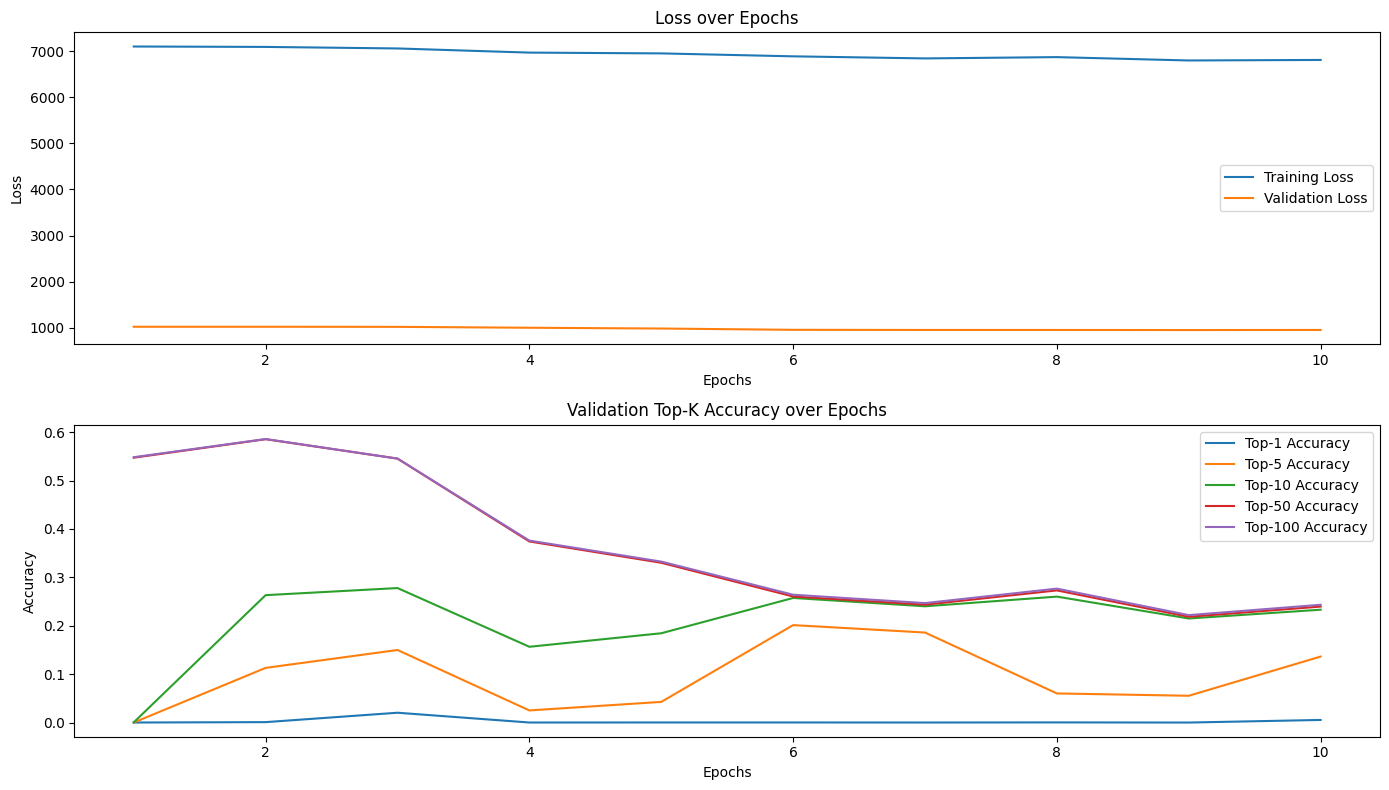

In [15]:
import matplotlib.pyplot as plt


# Plotting function
def plot_metrics(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Top-K Accuracies
    plt.subplot(2, 1, 2)
    for k in [1, 5, 10, 50, 100]:
        metric = f"val_factorized_top_k/top_{k}_categorical_accuracy"
        plt.plot(epochs, history[metric], label=f"Top-{k} Accuracy")

    plt.title("Validation Top-K Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot
#plot_metrics(history)
plot_metrics(model_history.history)


In [ ]:
user_batch = val_df.sample(1)
item_batch = item_df.sample(20)

user_input = {k: tf.constant(user_batch[k].values) for k in QUERY_FEATURES}
item_input = {k: tf.constant(item_batch[k].values) for k in CANDIDATE_FEATURES}

user_emb = model.query_model(user_input)
item_emb = model.item_model(item_input)

scores = tf.linalg.matmul(user_emb, item_emb, transpose_b=True)
print("Scores:", scores.numpy())


Scores: [[ 0.0015192   0.0015192   0.0015192   0.0015192   0.0015192   0.0015192
   0.0015192   0.0015192   0.0015192  -0.03931042 -0.01758565  0.0015192
  -0.01110326  0.0015192   0.0015192   0.0015192   0.0015192   0.0015192
  -0.00619264 -0.00952904]]


Found 15396 unique items for evaluation
Precomputing item embeddings...
Building Faiss index...
Evaluating model...

Model Evaluation Results:
Recall@10: 0.0052
Recall@50: 0.0066
Recall@100: 0.0079
Recall@1000: 0.4279
Average Precision: 0.3478
ROC AUC: 0.8482


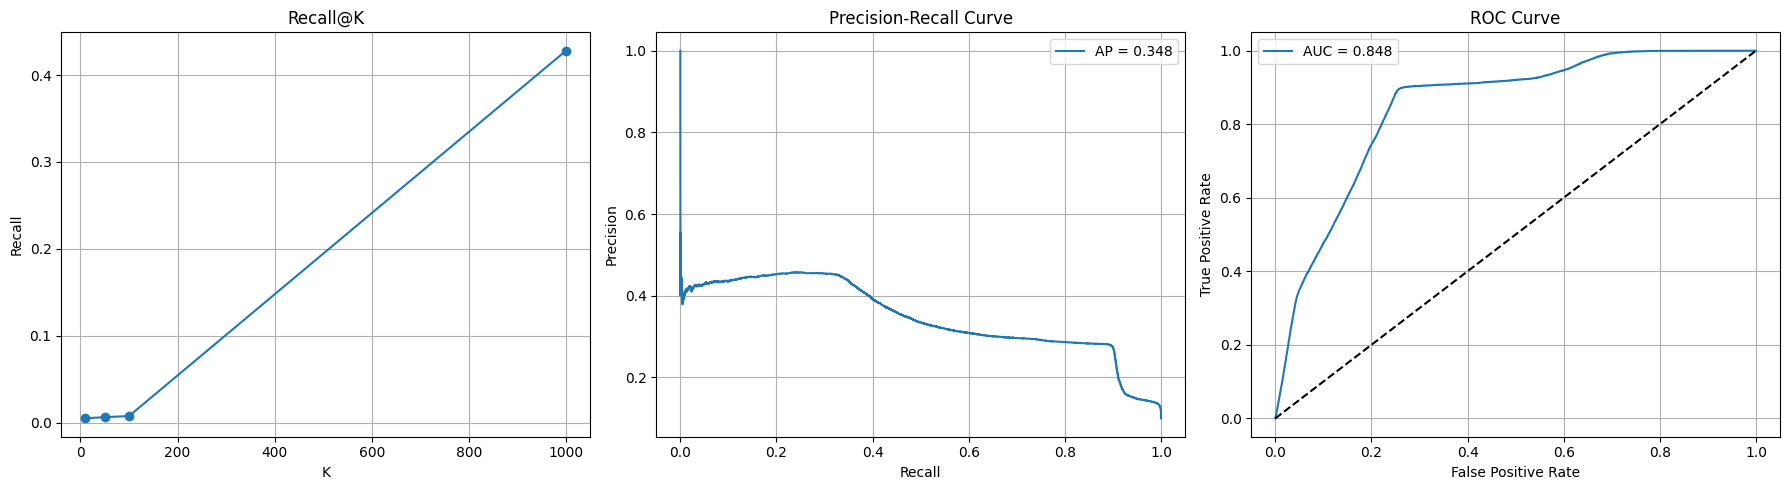


Sample Recommendations:
User: TB995W
User Interests: literature
user not in sequence
Actual Interaction: DL594G
Top 5 Recommendations: ['VA099I', 'ZE202G', 'GI409B', 'KR426G', 'CV437H', 'PP756G', 'PZ627Q', 'TM509Y', 'MW879W', 'JV944Q', 'UC511E', 'HA746L', 'HB850F', 'ZK079P', 'CZ398W', 'LK834W', 'RZ399N', 'ES499J', 'RR279B', 'OY169F', 'XW571I', 'BU777H', 'LQ010R', 'GU626U', 'JP615V', 'FX946J', 'PC626R', 'IW336O', 'XZ040W', 'KJ129B', 'HN863J', 'KR361F', 'CL466M', 'KG806T', 'AD032B', 'TF689J', 'ZU734G', 'WM666P', 'EP338S', 'WD705D', 'OC300G', 'OC802Z', 'TH842U', 'MF156J', 'ES643A', 'AZ474E', 'ON705Q', 'OU110D', 'SH764R', 'MO550W', 'VX985A', 'BN339R', 'TG115M', 'YD000B', 'KH083V', 'IN429K', 'TX973N', 'WZ909E', 'PS383L', 'XV557R', 'FB690O', 'SW811E', 'JG700A', 'SH875L', 'AP654H', 'OJ175Q', 'OZ431C', 'KH140U', 'AI934U', 'MS828W', 'YQ490V', 'ZC523P', 'OH119P', 'IA762O', 'OV060W', 'ZL978T', 'DU725N', 'UQ968Y', 'DC986K', 'QL585G', 'GG748S', 'JL782P', 'TW388L', 'XN601W', 'AK122D', 'MC086T', 'WJ

In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
query_model = model.query_model
candidate_model = model.item_model
# --- 1. Precompute item (candidate) embeddings ---
CANDIDATE_FEATURES = ["event_id", "event_type", "event_city", "title"]

def precompute_item_embeddings(item_model, item_df, batch_size=1024):
    item_features = {
        "event_id": item_df["event_id"].values,
        "event_type": item_df["event_type"].values,
        "event_city": item_df["event_city"].values,
        "title": item_df["title"].values
    }
    ds = tf.data.Dataset.from_tensor_slices(item_features).batch(batch_size)
    embeddings = []
    for batch in ds:
        emb = item_model(batch).numpy()
        embeddings.append(emb)
    item_embeddings = np.vstack(embeddings)
    return item_embeddings

# --- 2. Build Faiss index (cosine similarity via normalized dot product) ---
def build_faiss_index(item_embeddings):
    faiss.normalize_L2(item_embeddings)
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    return index

# --- 3. Evaluate Recall@K on test set ---
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
K_VALUES = [10, 50, 100, 1000]

def get_user_embedding(query_model, user_row):
    user_features = {
        "user_id": np.array([user_row["user_id"]]),
        "user_city": np.array([user_row["user_city"]]),
        "age": np.array([user_row["age"]], dtype=np.float32),
        "user_interests": np.array([user_row["user_interests"]])
    }
    emb = query_model(user_features).numpy()
    faiss.normalize_L2(emb)
    return emb

def evaluate_model(query_model, test_df, faiss_index, item_embeddings, item_ids, item_df, k_values=K_VALUES):
    hits_at_k = {k: 0 for k in k_values}
    total = 0
    all_scores = []
    all_labels = []

    for user_id, group in test_df.groupby('user_id'):
        # 1) All events the user actually attended in test:
        attended = set(group['event_id'].tolist())

        # 2) All events in the catalog whose metadata matches at least one of the user's interest keywords:
        user_interests = group.iloc[0]['user_interests'].split(",")
        interest_matched = {
            ev_id for ev_id, ev_cat in zip(item_df['event_id'], item_df['event_type'])
            if any(interest.lower() in ev_cat.lower() for interest in user_interests)
        }

        # Union of the two sets:
        actual_relevant = attended#.union(interest_matched)

        # Get user embedding
        user_emb = get_user_embedding(query_model, group.iloc[0])

        # Retrieve top max(k_values) items
        D, I = faiss_index.search(user_emb, max(k_values))
        recommended_ids = [item_ids[i] for i in I[0]]

        for k in k_values:
            # Check if all attended events are retrieved and if retrieved events match user interests
            # We consider a hit if all attended events are in the top-k recommendations and at least one recommended event matches user interests
            attended_in_top_k = attended.issubset(set(recommended_ids[:k]))
            interest_in_top_k = any(ev in interest_matched for ev in recommended_ids[:k])
            if attended_in_top_k:#: and interest_in_top_k:
                hits_at_k[k] += 1

        # For PR/ROC: positive and negatives
        for event_id in actual_relevant:
            if event_id in item_ids:
                actual_item_idx = item_ids.index(event_id)
                actual_item_embedding = item_embeddings[actual_item_idx]
                actual_score = np.dot(user_emb[0], actual_item_embedding)
                all_scores.append(actual_score)
                all_labels.append(1)

                neg_indices = np.random.choice(
                    [i for i in range(len(item_embeddings)) if i != actual_item_idx],
                    size=min(9, len(item_embeddings)-1),
                    replace=False
                )
                for neg_idx in neg_indices:
                    neg_score = np.dot(user_emb[0], item_embeddings[neg_idx])
                    all_scores.append(neg_score)
                    all_labels.append(0)

        total += 1

    recall_at_k = {k: hits_at_k[k] / total for k in k_values}
    return recall_at_k, np.array(all_scores), np.array(all_labels)


def plot_evaluation_metrics(recall_at_k, all_scores, all_labels):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o')
    ax1.set_title('Recall@K')
    ax1.set_xlabel('K')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)
    ap = average_precision_score(all_labels, all_scores)
    ax2.plot(recall, precision, label=f'AP = {ap:.3f}')
    ax2.set_title('Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    ax2.grid(True)
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_title('ROC Curve')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.legend()
    ax3.grid(True)
    plt.tight_layout()
    plt.savefig('model_evaluation_metrics.png')
    plt.show()
    return fig


def main():
    # Assume you have train_df, val_df, test_df, query_model, candidate_model already in memory
    # Prepare unique item DataFrame
    item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    item_ids = item_df["event_id"].tolist()
    print(f"Found {len(item_df)} unique items for evaluation")
    # Precompute item embeddings
    print("Precomputing item embeddings...")
    item_embeddings = precompute_item_embeddings(item_model, item_df)
    # Build Faiss index
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings)
    # Evaluate model
    print("Evaluating model...")
    recall_at_k, all_scores, all_labels = evaluate_model(
        query_model, val_df, faiss_index, item_embeddings, item_ids, item_df
    )
    print("\nModel Evaluation Results:")
    for k, recall in recall_at_k.items():
        print(f"Recall@{k}: {recall:.4f}")
    ap = average_precision_score(all_labels, all_scores)
    print(f"Average Precision: {ap:.4f}")
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")
    plot_evaluation_metrics(recall_at_k, all_scores, all_labels)
    # Sample recommendations
    print("\nSample Recommendations:")
    sample_user = val_df.iloc[10]
    user_emb = get_user_embedding(query_model, sample_user)
    D, I = faiss_index.search(user_emb, 500)
    recommendations = [item_ids[i] for i in I[0]]
    print(f"User: {sample_user['user_id']}")
    print(f"User Interests: {sample_user['user_interests']}")
    if sample_user['event_id'] in recommendations:
        print("User in sequence - Position:", recommendations.index(sample_user['event_id']) + 1)
    else:
        print("user not in sequence")
    print(f"Actual Interaction: {sample_user['event_id']}")
    print(f"Top 5 Recommendations: {recommendations}")
    return recall_at_k, all_scores, all_labels

if __name__ == "__main__":
    main()


In [16]:
# import tensorflow as tf
# import numpy as np
# import pandas as pd
# import faiss
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

# Load new test data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/users.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/events.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/interactions.csv')

users_df.rename(columns={'location': 'user_city'}, inplace=True)

# Drop the 'event_type' column first, then rename the remaining columns
events_df.drop(columns=["event_type"], inplace=True)  # Use a list for consistency
events_df.rename(columns={'city': 'event_city', 'category': 'event_type'}, inplace=True)




# Merge user/event features into interactions
interactions_df = interactions_df.merge(users_df, on="user_id", how="inner")
interactions_df = interactions_df.merge(events_df, on="event_id", how="inner")
print(interactions_df.columns)
# # Feature sets
# USER_FEATURES = ['user_id', 'gender', 'age', 'indoor_outdoor_preference', 'user_lat', 'user_lng', 'user_interests']
# EVENT_FEATURES = ['event_id', 'category', 'title', 'event_type', 'event_lat', 'event_lng', 'hour', 'day_of_week', 'is_weekend']
# string_cols = ['user_id', 'event_id', 'gender', 'indoor_outdoor_preference', 'category', 'title', 'event_type', 'user_interests']

QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# Drop missing values
#interactions_df = interactions_df.dropna()
interactions_df = interactions_df[QUERY_FEATURES + CANDIDATE_FEATURES]
#interactions_df = interactions_df.sample(n=50000, random_state=42)
print(interactions_df.info())
print(len(interactions_df))
print(interactions_df["user_id"].nunique())
print(interactions_df["event_id"].nunique())

interactions_df["user_id"] = interactions_df["user_id"].astype(str)
interactions_df["event_id"] = interactions_df["event_id"].astype(str)
events_df["event_id"] = events_df["event_id"].astype(str)

# def df_to_ds(df):
#     return tf.data.Dataset.from_tensor_slices({
#         col: tf.constant(df[col].values) for col in df.columns
#     })


# # Define features for query and candidate towers
# QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
# CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

train_df = interactions_df.sample(frac=0.9, random_state=42)
val_df = interactions_df.drop(train_df.index)





# Build tf.data.Dataset with proper tensor shapes
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({
        col: tf.constant(df[col].values) for col in df.columns
    })

# Create datasets with proper batching and shuffling
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()

# Create item dataset with proper tensor shapes
item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
item_ds = tf.data.Dataset.from_tensor_slices({
    col: tf.constant(item_df[col].astype(str).values) for col in CANDIDATE_FEATURES
})
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
query_model = model.query_model
candidate_model = model.item_model
# --- 1. Precompute item (candidate) embeddings ---
CANDIDATE_FEATURES = ["event_id", "event_type", "event_city", "title"]

def precompute_item_embeddings(item_model, item_df, batch_size=1024):
    item_features = {
        "event_id": item_df["event_id"].values,
        "event_type": item_df["event_type"].values,
        "event_city": item_df["event_city"].values,
        "title": item_df["title"].values
    }
    ds = tf.data.Dataset.from_tensor_slices(item_features).batch(batch_size)
    embeddings = []
    for batch in ds:
        emb = item_model(batch).numpy()
        embeddings.append(emb)
    item_embeddings = np.vstack(embeddings)
    return item_embeddings

# --- 2. Build Faiss index (cosine similarity via normalized dot product) ---
def build_faiss_index(item_embeddings):
    faiss.normalize_L2(item_embeddings)
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    return index

# --- 3. Evaluate Recall@K on test set ---
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
K_VALUES = [10, 50, 100, 1000]

def get_user_embedding(query_model, user_row):
    user_features = {
        "user_id": np.array([user_row["user_id"]]),
        "user_city": np.array([user_row["user_city"]]),
        "age": np.array([user_row["age"]], dtype=np.float32),
        "user_interests": np.array([user_row["user_interests"]])
    }
    emb = query_model(user_features).numpy()
    faiss.normalize_L2(emb)
    return emb

def evaluate_model(query_model, test_df, faiss_index, item_embeddings, item_ids, item_df, k_values=K_VALUES):
    hits_at_k = {k: 0 for k in k_values}
    total = 0
    all_scores = []
    all_labels = []

    for user_id, group in test_df.groupby('user_id'):
        # 1) All events the user actually attended in test:
        attended = set(group['event_id'].tolist())

        # 2) All events in the catalog whose metadata matches at least one of the user's interest keywords:
        user_interests = group.iloc[0]['user_interests'].split(",")
        interest_matched = {
            ev_id for ev_id, ev_cat in zip(item_df['event_id'], item_df['event_type'])
            if any(interest.lower() in ev_cat.lower() for interest in user_interests)
        }

        # Union of the two sets:
        actual_relevant = attended#.union(interest_matched)

        # Get user embedding
        user_emb = get_user_embedding(query_model, group.iloc[0])

        # Retrieve top max(k_values) items
        D, I = faiss_index.search(user_emb, max(k_values))
        recommended_ids = [item_ids[i] for i in I[0]]

        for k in k_values:
            # Check if all attended events are retrieved and if retrieved events match user interests
            # We consider a hit if all attended events are in the top-k recommendations and at least one recommended event matches user interests
            attended_in_top_k = attended.issubset(set(recommended_ids[:k]))
            interest_in_top_k = any(ev in interest_matched for ev in recommended_ids[:k])
            if attended_in_top_k:# or interest_in_top_k:
                hits_at_k[k] += 1

        # For PR/ROC: positive and negatives
        for event_id in actual_relevant:
            if event_id in item_ids:
                actual_item_idx = item_ids.index(event_id)
                actual_item_embedding = item_embeddings[actual_item_idx]
                actual_score = np.dot(user_emb[0], actual_item_embedding)
                all_scores.append(actual_score)
                all_labels.append(1)

                neg_indices = np.random.choice(
                    [i for i in range(len(item_embeddings)) if i != actual_item_idx],
                    size=min(9, len(item_embeddings)-1),
                    replace=False
                )
                for neg_idx in neg_indices:
                    neg_score = np.dot(user_emb[0], item_embeddings[neg_idx])
                    all_scores.append(neg_score)
                    all_labels.append(0)

        total += 1

    recall_at_k = {k: hits_at_k[k] / total for k in k_values}
    return recall_at_k, np.array(all_scores), np.array(all_labels)


def plot_evaluation_metrics(recall_at_k, all_scores, all_labels):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o')
    ax1.set_title('Recall@K')
    ax1.set_xlabel('K')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)
    ap = average_precision_score(all_labels, all_scores)
    ax2.plot(recall, precision, label=f'AP = {ap:.3f}')
    ax2.set_title('Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    ax2.grid(True)
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_title('ROC Curve')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.legend()
    ax3.grid(True)
    plt.tight_layout()
    plt.savefig('model_evaluation_metrics.png')
    plt.show()
    return fig


def main():
    # Assume you have train_df, val_df, test_df, query_model, candidate_model already in memory
    # Prepare unique item DataFrame
    item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    item_ids = item_df["event_id"].tolist()
    print(f"Found {len(item_df)} unique items for evaluation")
    # Precompute item embeddings
    print("Precomputing item embeddings...")
    item_embeddings = precompute_item_embeddings(item_model, item_df)
    # Build Faiss index
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings)
    # Evaluate model
    print("Evaluating model...")
    recall_at_k, all_scores, all_labels = evaluate_model(
        query_model, val_df, faiss_index, item_embeddings, item_ids, item_df
    )
    print("\nModel Evaluation Results:")
    for k, recall in recall_at_k.items():
        print(f"Recall@{k}: {recall:.4f}")
    ap = average_precision_score(all_labels, all_scores)
    print(f"Average Precision: {ap:.4f}")
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")
    plot_evaluation_metrics(recall_at_k, all_scores, all_labels)
    # Sample recommendations
    print("\nSample Recommendations:")
    sample_user = val_df.iloc[10]
    user_emb = get_user_embedding(query_model, sample_user)
    D, I = faiss_index.search(user_emb, 1000)
    recommendations = [item_ids[i] for i in I[0]]
    print(f"User: {sample_user['user_id']}")
    print(f"User Interests: {sample_user['user_interests']}")
    if sample_user['event_id'] in recommendations:
        print("User in sequence - Position:", recommendations.index(sample_user['event_id']) + 1)
    else:
        print("user not in sequence")
    print(f"Actual Interaction: {sample_user['event_id']}")
    print(f"Top 5 Recommendations: {recommendations}")
    return recall_at_k, all_scores, all_labels

if __name__ == "__main__":
    main()




Index(['Unnamed: 0_x', 'event_id', 'user_id', 'interaction_type',
       'distance_to_event', 'interaction_label', 'weather_match',
       'Unnamed: 0_y', 'gender', 'joinedAt', 'user_city', 'age', 'lat_x',
       'lng_x', 'indoor_outdoor_preference', 'user_interests', 'Unnamed: 0',
       'start_time', 'event_city', 'lat_y', 'lng_y', 'yes_count',
       'maybe_count', 'invited_count', 'no_count', 'total_users',
       'weather_description', 'event_type', 'title', 'event_indoor_capability',
       'temperature_2m_mean', 'precipitation_sum'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28249 entries, 0 to 28248
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         28249 non-null  float64
 1   user_city       28249 non-null  object 
 2   age             28249 non-null  int64  
 3   user_interests  28249 non-null  object 
 4   event_id        28249 non-null  float64
 5   eve

In [ ]:
import tensorflow as tf
import numpy as np

def recommend_events_for_user(user_id, top_k=10):
    """
    Recommend top-k events for a specific user
    
    Args:
        user_id: The ID of the user to recommend events for
        top_k: Number of recommendations to return
        
    Returns:
        List of recommended event IDs with their scores
    """
    # Get user features
    user_data = users_df[users_df['user_id'] == user_id].iloc[0]
    
    # Prepare user input for the query tower
    user_input = {
        "user_id": tf.constant([str(user_id)]),
        "user_city": tf.constant([user_data['location']]),  # Assuming 'location' is the city field
        "age": tf.constant([user_data['age']], dtype=tf.float32),
        "user_interests": tf.constant([user_data['user_interests']])
    }
    
    # Get user embedding from query tower
    user_embedding = query_model(user_input)
    
    # Prepare all events data for the item tower
    events_data = events_df.copy()
    events_data["event_id"] = events_data["event_id"].astype(str)
    
    # Convert to TensorFlow dataset
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["city"].values),  # Assuming 'city' is the city field
        "event_type": tf.constant(events_data["category"].values),  # Assuming 'category' is the event_type field
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    
    # Get embeddings for all events
    event_ids = []
    event_embeddings = []
    
    for batch in events_dataset:
        batch_embeddings = item_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    
    event_embeddings = np.vstack(event_embeddings)
    
    # Calculate similarity scores
    similarities = tf.matmul(
        user_embedding, 
        tf.transpose(event_embeddings)
    ).numpy()[0]
    
    # Get top-k events
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    # Return event IDs with their scores
    recommendations = [
        {"event_id": event_ids[idx], "score": float(similarities[idx])}
        for idx in top_indices
    ]
    
    return recommendations

# Example usage
recommended_events = recommend_events_for_user("user_123", top_k=5)
print("Recommended events:", recommended_events)

# Get full details of recommended events
recommended_event_ids = [rec["event_id"] for rec in recommended_events]
recommended_events_details = events_df[events_df["event_id"].astype(str).isin(recommended_event_ids)]
print(recommended_events_details)

# <span style="color:#ff5f27">Building Ranking Model </span>

In [1]:
import pandas as pd
#from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, precision_recall_fscore_support
import joblib
import hopsworks

In [2]:

# Connect to Hopsworks Feature Store
project = hopsworks.login()
fs = project.get_feature_store()


2025-05-13 20:54:17,375 INFO: Initializing external client
2025-05-13 20:54:17,376 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-13 20:54:17,954 WARNING: UserWarning: The installed hopsworks client version 4.1.8 may not be compatible with the connected Hopsworks backend version 4.2.0. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-05-13 20:54:18,866 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


In [ ]:

weather_rank_fg = fs.get_feature_group(
    name="weather_ranking",
    version=1
)

no_weather_rank_fg = fs.get_feature_group(
    name="no_weather_ranking",
    version=1
)


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [ ]:
# Select features
selected_features_customers = users_fg.select_all()

fs.get_or_create_feature_view( 
    name='users',
    query=selected_features_customers,
    version=1,
)
# Select features
selected_features_articles = events_fg.select_all()

fs.get_or_create_feature_view(
    name='events',
    query=selected_features_articles,
    version=1,
)


In [31]:
merged_df.columns

Index(['Unnamed: 0', 'user_id', 'gender', 'user_lat', 'user_lon', 'user_city',
       'indoor_outdoor_preference', 'age', 'user_interests', 'signup_date',
       'interaction_id', 'event_id', 'interaction_type', 'distance_to_event',
       'interaction_label', 'interest_match', 'title', 'event_category',
       'event_lat', 'event_lon', 'event_city', 'start_time', 'duration',
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability'],
      dtype='object')

In [ ]:
import pandas as pd
users_df = pd.read_csv('/home/nkama/masters_thesis_project/users_data_test.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/events_data_test.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/interactions_data_test.csv')

# Merge user/event features into interactions
interactions_df = interactions_df.merge(users_df, on="user_id")
interactions_df = interactions_df.merge(events_df, on="event_id", suffixes=('_user', '_event'))
interactions_df.head(2)

In [27]:
# # Load feature view and feature groups
# feature_view = fs.get_feature_view(name='event_retrieval', version=1)
# users_df = fs.get_feature_group("users", version=1).read()
# events_df = fs.get_feature_group("events", version=1).read()
# interactions_df = fs.get_feature_group("interactions", version=1).read()

# print(users_df.columns)
# print(events_df.columns)
# print(interactions_df.columns)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.83s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.48s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.28s) 
Index(['user_id', 'user_lat', 'user_lon', 'user_city',
       'user_weather_preference', 'age', 'user_interests', 'signup_date',
       'social_connectedness'],
      dtype='object')
Index(['event_id', 'title', 'event_type', 'event_lat', 'event_lon',
       'event_city', 'start_time', 'duration', 'weather_condition',
       'temperature', 'attendance_rate', 'event_indoor_capability'],
      dtype='object')
Index(['interaction_id', 'user_id', 'event_id', 'interaction_type',
       'interaction_time', 'interaction_distance_to_event'],
      dtype='object')


In [3]:
from sklearn.model_selection import train_test_split

NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city', 
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests']
# # Select features
# features_weather_ranking = weather_rank_fg.select(WEATHER_SELECTED_FEATURES)

# feature_view_ranking_weather = fs.get_or_create_feature_view(
#     name='weather_ranking',
#     query=features_weather_ranking,
#     labels=["label"],
#     version=1,
# )
# # Select features
# features_no_weather_ranking = no_weather_rank_fg.select(NO_WEATHER_SELECTED_FEATURES)

# feature_view_ranking_no_weather = fs.get_or_create_feature_view(
#     name='no_weather_ranking',
#     query=features_no_weather_ranking,
#     labels=["label"],
#     version=1,
# # )
# # Splitting the dataset into features and labels
# weather_X = interactions_df[WEATHER_SELECTED_FEATURES]  # Features
# weather_y = interactions_df['interaction_label']   

# no_weather_X = interactions_df[NO_WEATHER_SELECTED_FEATURES]  # Features
# no_weather_y = interactions_df['interaction_label']                   # Labels

# # Splitting the dataset into training and evaluation sets
# weather_X_train, weather_X_val, weather_y_train, weather_y_val = \
#     train_test_split(weather_X, weather_y, test_size=0.2, random_state=42)

# no_weather_X_train, no_weather_X_val, no_weather_y_train, no_weather_y_val = \
#     train_test_split(no_weather_X, no_weather_y, test_size=0.2, random_state=42)

## Testing ranking model with new data

In [4]:
test_users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
test_events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
test_interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')

# Renaming columns in users_df
test_users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'indoor_outdoor_preference': 'user_weather_preference',
    'joinedAt': 'signup_date'
}, inplace=True)

# Renaming columns in events_df
test_events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
test_interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)

# Merge user/event features into interactions
# Merge user/event features into interactions
test_interactions_df = test_interactions_df.merge(test_users_df, on="user_id", how="inner")
test_interactions_df = test_interactions_df.merge(test_events_df, on="event_id", how="inner")
print(test_interactions_df.columns)

# Splitting the dataset into features and labels
test_weather_X = test_interactions_df[WEATHER_SELECTED_FEATURES]  # Features
test_weather_y = test_interactions_df['interaction_label']   

test_no_weather_X = test_interactions_df[NO_WEATHER_SELECTED_FEATURES]  # Features
test_no_weather_y = test_interactions_df['interaction_label']                   # Labels

# Splitting the dataset into training and evaluation sets
test_weather_X_train, test_weather_X_val, test_weather_y_train, test_weather_y_val = \
    train_test_split(test_weather_X, test_weather_y, test_size=0.2, random_state=42)

test_no_weather_X_train, test_no_weather_X_val, test_no_weather_y_train, test_no_weather_y_val = \
    train_test_split(test_no_weather_X, test_no_weather_y, test_size=0.2, random_state=42)


Index(['Unnamed: 0_x', 'user_id', 'event_id', 'interaction_type',
       'interaction_distance_to_event', 'interaction_label', 'Unnamed: 0_y',
       'user_lat', 'user_lon', 'user_city', 'user_weather_preference', 'age',
       'user_interests', 'signup_date', 'Unnamed: 0', 'title', 'event_type',
       'event_lat', 'event_lon', 'event_city', 'start_time',
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability'],
      dtype='object')


In [5]:

# Get feature views
feature_view_ranking_weather = fs.get_feature_view(name='weather_ranking', version=1)


In [6]:
feature_view_ranking_no_weather = fs.get_feature_view(name='no_weather_ranking', version=1)

In [7]:

# Get training and validation data directly from feature views
weather_X_train, weather_X_val, weather_y_train, weather_y_val = \
    feature_view_ranking_weather.train_test_split(
    test_size=0.1,
    description='Weather ranking training dataset',
)



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.01s) 
2025-05-13 20:55:36,631 WARNING: VersionWarning: Incremented version to `5`.



In [8]:
weather_X_train.drop(columns=(["duration"]),inplace=True)
weather_X_val.drop(columns=(["duration"]),inplace=True)

In [9]:

no_weather_X_train, no_weather_X_val, no_weather_y_train, no_weather_y_val = \
    feature_view_ranking_no_weather.train_test_split(
    test_size=0.1,
    description='No-weather ranking training dataset',
)

weather_X_train.columns


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.06s) 
2025-05-13 20:55:47,219 WARNING: VersionWarning: Incremented version to `5`.



Index(['interaction_distance_to_event', 'event_type', 'event_city',
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests'],
      dtype='object')

In [10]:
no_weather_X_train.drop(columns=(["duration"]),inplace=True)
no_weather_X_val.drop(columns=(["duration"]),inplace=True)

In [11]:
no_weather_y_train.value_counts()

label
0        80270
1        67015
Name: count, dtype: int64

In [83]:
def event_type_in_user_interests(user_interests, event_type):
    return int(event_type.lower() in user_interests.lower().split())


In [12]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Final version without text fields (title, user_interests)
def train_catboost_model(
    train_df, val_df, train_y, val_y
):

    # Identify categorical features
    cat_features = train_df.select_dtypes(include=["object", "bool"]).columns.tolist()


    # Now ensure numeric type
    train_y = train_y.astype(int)
    val_y = val_y.astype(int)


    # Create CatBoost Pools
    train_pool = Pool(train_df, train_y, cat_features=cat_features)
    val_pool = Pool(val_df, val_y, cat_features=cat_features)

    # Train the model
    model = CatBoostClassifier(
        learning_rate=0.2,
        iterations=100,
        depth=10,
        early_stopping_rounds=5,
        use_best_model=True,
        scale_pos_weight=3, 
        verbose=False
    )

    model.fit(train_pool, eval_set=val_pool)

    # Evaluation
    preds = model.predict(val_pool)
    precision, recall, fscore, _ = precision_recall_fscore_support(val_y, preds, average="binary")
    print("\nClassification Report:")
    print(classification_report(val_y, preds))

    metrics = {
        "precision": precision,
        "recall": recall,
        "fscore": fscore,
    }
    from sklearn.metrics import confusion_matrix
    import numpy as np

    preds = model.scores = model.predict_proba(val_pool)[:, 1] 
    print("Predicted Class Distribution:", np.unique(preds, return_counts=True))

    # print("\nConfusion Matrix:")
    # print(confusion_matrix(val_y, preds))

    return model, metrics, val_pool


In [13]:
# Use this function to train on your weather / no-weather datasets
weather_model, weather_metrics, weather_val_pool = train_catboost_model(
    train_df=weather_X_train,
    val_df=weather_X_val,
    train_y=weather_y_train,
    val_y=weather_y_val
)

# # Save the models using Joblib
joblib.dump(weather_model, 'weather_ranking_model.pkl')
print("\nModels saved successfully!")


Classification Report:
2025-05-13 20:57:00,634 WARNING: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2025-05-13 20:57:00,643 WARNING: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2025-05-13 20:57:00,648 WARNING: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8984
           1       0.45      1.00      0.62      7381

    accuracy                           0.45     16365
   macro avg       0.23      0.50      0.31     16365
weighted avg       0.20      0.45      0.28     16365

Predicted Class Dis

In [28]:
feat_to_score = {
    feature: score 
    for feature, score 
    in zip(
        weather_X_train.columns, 
        weather_model.feature_importances_,
    )
}

feat_to_score = dict(
    sorted(
        feat_to_score.items(),
        key=lambda item: item[1],
        reverse=True,
    )
)
feat_to_score


{'interaction_distance_to_event': 87.23220215620331,
 'attendance_rate': 7.629513305105679,
 'user_weather_preference': 1.1077838052865996,
 'event_city': 0.9856754110563087,
 'event_type': 0.666305319217527,
 'user_city': 0.5350553809313855,
 'weather_condition': 0.4664327937901577,
 'age': 0.41741658961399974,
 'temperature': 0.38436721027822773,
 'event_indoor_capability': 0.32251785664255517,
 'user_interests': 0.2527301718742626}

In [14]:
# Use this function to train on your weather / no-weather datasets
no_weather_model, no_weather_metrics, no_weather_val_pool = train_catboost_model(
    train_df=no_weather_X_train,
    val_df=no_weather_X_val,
    train_y=no_weather_y_train,
    val_y=no_weather_y_val
)

joblib.dump(no_weather_model, 'no_weather_ranking_model_2.pkl')
print("\nModels saved successfully!")



Classification Report:
2025-05-13 20:57:14,736 WARNING: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2025-05-13 20:57:14,757 WARNING: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2025-05-13 20:57:14,773 WARNING: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8902
           1       0.46      1.00      0.63      7463

    accuracy                           0.46     16365
   macro avg       0.23      0.50      0.31     16365
weighted avg       0.21      0.46      0.29     16365

Predicted Class Dis

In [ ]:
interactions_df["interaction_label"].unique()

In [15]:
import joblib

# Load the saved model
# no_weather_model = joblib.load('no_weather_ranking_model_2.pkl')
# weather_model = joblib.load('weather_ranking_model_2.pkl')
# print("Model loaded successfully!")

# Example usage: Predicting on new data
weather_cat_features = test_weather_X.select_dtypes(include=["object", "bool"]).columns.tolist()
no_weather_cat_features = test_no_weather_X.select_dtypes(include=["object", "bool"]).columns.tolist()
# Now ensure numeric type
test_weather_y_val = test_weather_y_val.astype(int)
test_no_weather_y_val = test_no_weather_y_val.astype(int)


# Create CatBoost Pools
weather_val_pool = Pool(test_weather_X, test_weather_y, cat_features=weather_cat_features)
no_weather_val_pool = Pool(test_no_weather_X, test_no_weather_y, cat_features=no_weather_cat_features)
# Make predictions
weather_predictions = weather_model.predict(weather_val_pool)
no_weather_predictions = no_weather_model.predict(no_weather_val_pool)

# If you want probabilities instead of class labels
weather_predicted_probabilities = weather_model.predict_proba(weather_val_pool)[:, 1]  # Probability for the positive class
no_weather_predicted_probabilities = no_weather_model.predict_proba(no_weather_val_pool)[:, 1]

test_weather_preds = pd.DataFrame({"actual_babel":test_weather_y, "predictions":weather_predictions,"pred_probs":weather_predicted_probabilities})
test_no_weather_preds = pd.DataFrame({"actual_babel":test_no_weather_y, "predictions":no_weather_predictions,"pred_probs":no_weather_predicted_probabilities})
# Print predictions
print("Predictions:", weather_predictions)
print("Predicted Probabilities:", weather_predicted_probabilities)
test_weather_preds.head()

Predictions: [1 1 1 ... 1 1 1]
Predicted Probabilities: [0.57317173 0.56826483 0.56826483 ... 0.66400215 0.6790914  0.80522593]


actual_babel  predictions  pred_probs
0           1.0            1    0.573172
1           1.0            1    0.568265
2           1.0            1    0.568265
3           1.0            1    0.568265
4           1.0            1    0.705643

In [18]:
test_weather_preds["pred_probs"].max()

0.8868704077844932

In [19]:

feat_to_score = {
    feature: score 
    for feature, score 
    in zip(
        no_weather_X_train.columns, 
        no_weather_model.feature_importances_,
    )
}

feat_to_score = dict(
    sorted(
        feat_to_score.items(),
        key=lambda item: item[1],
        reverse=True,
    )
)
feat_to_score


{'interaction_distance_to_event': 92.39945423685444,
 'attendance_rate': 1.6200418573173294,
 'event_city': 1.4476089355314528,
 'age': 1.253230044125376,
 'event_type': 1.1624357293069842,
 'event_indoor_capability': 1.0621145722052296,
 'user_city': 1.055114624659208,
 'user_interests': 0.0}

---

In [17]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import faiss
from sklearn.metrics import roc_auc_score, average_precision_score
from typing import Dict, List, Tuple

# # Connect to Hopsworks and load data
# project = hopsworks.login()
# fs = project.get_feature_store()

# # Load feature view and feature groups
# feature_view = fs.get_feature_view(name='event_retrieval', version=1)
# users_df = fs.get_feature_group("users", version=1).read()
# events_df = fs.get_feature_group("events", version=1).read()
# interactions_df = fs.get_feature_group("interactions", version=1).read()

# # Load test data for evaluation
# _, _, test_df, _, _, _ = feature_view.train_validation_test_split(
#     validation_size=0.1,
#     test_size=0.01,
#     description='Event retrieval dataset splits'
# )

# Define features for query and candidate towers
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "title", "event_type", "event_city"]

# Define features for ranking models

NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city', 
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests']
# # Select features
# Load ranking models from memory using joblib
weather_ranking_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/weather_ranking_model.pkl")
no_weather_ranking_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/no_weather_ranking_model_2.pkl")


query_model = model.query_model
candidate_model = model.item_model


In [10]:
no_weather_ranking_model.feature_names_


['interaction_distance_to_event',
 'event_type',
 'event_city',
 'attendance_rate',
 'event_indoor_capability',
 'user_city',
 'age',
 'user_interests']

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, classification_report, precision_recall_fscore_support, confusion_matrix
from catboost import CatBoostClassifier, Pool
import joblib



# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'indoor_outdoor_preference': 'user_weather_preference',
    'joinedAt': 'signup_date'
}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)


# Merge user/event features into interactions
interactions_df = interactions_df.merge(users_df, on="user_id", how="inner")
interactions_df = interactions_df.merge(events_df, on="event_id", how="inner")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]



# Define features for ranking models

NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city', 
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests']
# Filter and prepare data
# interactions_df = interactions_df[QUERY_FEATURES + CANDIDATE_FEATURES]


# Convert IDs to strings
interactions_df["user_id"] = interactions_df["user_id"].astype(str)
interactions_df["event_id"] = interactions_df["event_id"].astype(str)
events_df["event_id"] = events_df["event_id"].astype(str)


In [35]:


import tensorflow as tf
import numpy as np

def recommend_events_for_user(user_id, top_k=10):
    """
    Recommend top-k events for a specific user
    
    Args:
        user_id: The ID of the user to recommend events for
        top_k: Number of recommendations to return
        
    Returns:
        List of recommended event IDs with their scores, or None if user not found
    """
    # First check if user exists
    user_data = users_df[users_df['user_id'] == user_id]
    
    if user_data.empty:
        print(f"User ID {user_id} not found in the dataset")
        return None
    
    # Safely get the first row
    user_data #= user_data.iloc[0]
    
    # Prepare user input for the query tower
    user_input = {
        "user_id": tf.constant([str(user_id)]),
        "user_city": tf.constant([user_data['user_city']]),  # Assuming 'location' is the city field
        "age": tf.constant([user_data['age']], dtype=tf.float32),
        "user_interests": tf.constant([user_data['user_interests']])
    }
    
    # Get user embedding from query tower
    user_embedding = query_model(user_input)
    
    # Prepare all events data for the item tower
    events_data = events_df.copy()
    events_data["event_id"] = events_data["event_id"].astype(str)
    
    # Convert to TensorFlow dataset
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),  # Assuming 'city' is the city field
        "event_type": tf.constant(events_data["event_type"].values),  # Assuming 'category' is the event_type field
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    
    # Get embeddings for all events
    event_ids = []
    event_embeddings = []
    
    for batch in events_dataset:
        batch_embeddings = item_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    
    event_embeddings = np.vstack(event_embeddings)
    
    # Calculate similarity scores
    similarities = tf.matmul(
        user_embedding, 
        tf.transpose(event_embeddings)
    ).numpy()[0]
    
    # Get top-k events
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    # Return event IDs with their scores
    recommendations = [
        {"event_id": event_ids[idx], "score": float(similarities[idx])}
        for idx in top_indices
    ]
    
    
    return recommendations, user_data

# Example usage
recommended_events = recommend_events_for_user(3197468391, top_k=5)
print("Recommended events:", recommended_events)

# Get full details of recommended events
recommended_event_ids = [rec["event_id"] for rec in recommended_events]
recommended_events_details = events_df[events_df["event_id"].astype(str).isin(recommended_event_ids)]
print(recommended_events_details)

Recommended events: [{'event_id': b'2383453267', 'score': -0.007033541798591614}, {'event_id': b'2315431837', 'score': -0.007033541798591614}, {'event_id': b'1218003893', 'score': -0.007033541798591614}, {'event_id': b'2926720763', 'score': -0.007033541798591614}, {'event_id': b'2689936663', 'score': -0.007033541798591614}]
Empty DataFrame
Columns: [Unnamed: 0, event_id, title, event_type, event_lat, event_lon, event_city, start_time, weather_condition, temperature, attendance_rate, event_indoor_capability]
Index: []


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, classification_report, precision_recall_fscore_support, confusion_matrix
from catboost import CatBoostClassifier, Pool
import joblib



# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'indoor_outdoor_preference': 'user_weather_preference',
    'joinedAt': 'signup_date'
}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)


# Merge user/event features into interactions
interactions_df = interactions_df.merge(users_df, on="user_id", how="inner")
interactions_df = interactions_df.merge(events_df, on="event_id", how="inner")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]



# Define features for ranking models

NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city', 
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests']
# Filter and prepare data
# interactions_df = interactions_df[QUERY_FEATURES + CANDIDATE_FEATURES]


# Convert IDs to strings
interactions_df["user_id"] = interactions_df["user_id"].astype(str)
interactions_df["event_id"] = interactions_df["event_id"].astype(str)
events_df["event_id"] = events_df["event_id"].astype(str)



    # Filter users and get their data
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    
    # Prepare batch inputs
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].astype(str).values),
        "user_city": tf.constant(batch_users['user_city'].values),  # Assuming 'location' is the city field
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    
    # Get user embeddings
    user_embeddings = query_model(batch_input)
    
    # Get all event embeddings (same as in the previous function)
    events_data = events_df.copy()
    events_data["event_id"] = events_data["event_id"].astype(str)
    
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),  # Assuming 'city' is the city field  
        "event_type": tf.constant(events_data["event_type"].values),  # Assuming 'category' is the event_type field
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    
    event_ids = []
    event_embeddings = []
    
    for batch in events_dataset:
        batch_embeddings = item_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    
    event_embeddings = np.vstack(event_embeddings)
    
    # Calculate similarity scores for all users at once
    similarities = tf.matmul(
        user_embeddings, 
        tf.transpose(event_embeddings)
    ).numpy()
    
    # Get recommendations for each user
    recommendations = {}
    for i, user_id in enumerate(user_ids):
        user_similarities = similarities[i]
        top_indices = np.argsort(user_similarities)[-top_k:][::-1]
        
        user_recommendations = [
            {"event_id": event_ids[idx], "score": float(user_similarities[idx])}
            for idx in top_indices
        ]
        
        recommendations[user_id] = user_recommendations
    


# Example usage
user_list = users_df["user_id"].unique().tolist()[:10]
user_recommendations = batch_recommend_events(user_list, top_k=5)

for user_id, recs in user_recommendations.items():
    print(f"Recommendations for user {user_id}:")
    for rec in recs:
        print(f"  Event: {rec['event_id']}, Score: {rec['score']:.4f}")

In [42]:
def evaluate_recommendations(top_k=10, sample_size=1000):
    """
    Evaluate the model on historical interaction data
    
    Args:
        top_k: Number of recommendations to consider
        sample_size: Number of user-event pairs to evaluate
        
    Returns:
        Dictionary with evaluation metrics
    """
    # Sample interactions for evaluation
    sample_interactions = interactions_df.sample(min(sample_size, len(interactions_df)))
    
    # Get unique users from the sample
    unique_users = sample_interactions['user_id'].unique()
    
    # Get recommendations for each user
    recommendations = batch_recommend_events(unique_users, top_k=top_k)
    
    # Calculate hit rate and other metrics
    hits = 0
    total = 0
    
    for user_id in unique_users:
        # Get events the user has interacted with
        interacted_events = sample_interactions[
            sample_interactions['user_id'] == user_id
        ]['event_id'].astype(str).tolist()
        
        # Get recommended events for the user
        recommended_events = [rec['event_id'] for rec in recommendations[user_id]]
        
        # Count hits
        for event_id in interacted_events:
            if event_id in recommended_events:
                hits += 1
            total += 1
    
    hit_rate = hits / total if total > 0 else 0
    
    return {
        "hit_rate": hit_rate,
        "total_interactions": total,
        "hits": hits
    }

# Run evaluation
eval_results = evaluate_recommendations(top_k=10, sample_size=500)
print(f"Hit rate: {eval_results['hit_rate']:.4f}")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [41]:
import numpy as np
from collections import defaultdict

def evaluate_recommendations(top_k=10, sample_size=1000):
    """
    Evaluate the model on historical interaction data with multiple metrics
    
    Args:
        top_k: Number of recommendations to consider
        sample_size: Number of user-event pairs to evaluate
        
    Returns:
        Dictionary with evaluation metrics
    """
    # Sample interactions for evaluation
    sample_interactions = interactions_df.sample(min(sample_size, len(interactions_df)))
    
    # Get unique users from the sample
    unique_users = sample_interactions['user_id'].unique()
    
    # Get recommendations for each user
    recommendations = batch_recommend_events(unique_users, top_k=top_k)
    
    # Initialize metrics
    precision_sum = 0.0
    recall_sum = 0.0
    mrr_sum = 0.0
    ndcg_sum = 0.0
    user_count = 0
    
    for user_id in unique_users:
        # Get events the user has interacted with (ground truth)
        interacted_events = set(sample_interactions[
            sample_interactions['user_id'] == user_id
        ]['event_id'].astype(str).tolist())
        
        if not interacted_events:
            continue  # Skip users with no interactions
        
        # Get recommended events for the user
        user_recommendations = recommendations[user_id]
        recommended_events = [rec['event_id'] for rec in user_recommendations]
        
        # Calculate Precision@k - proportion of recommended items that are relevant
        hits = len(set(recommended_events) & interacted_events)
        precision = hits / len(recommended_events)
        precision_sum += precision
        
        # Calculate Recall@k - proportion of relevant items that are recommended
        recall = hits / len(interacted_events)
        recall_sum += recall
        
        # Calculate MRR@k - Mean Reciprocal Rank
        mrr = 0.0
        for rank, event_id in enumerate(recommended_events):
            if event_id in interacted_events:
                mrr = 1.0 / (rank + 1)  # +1 because ranks start at 0
                break
        mrr_sum += mrr
        
        # Calculate NDCG@k - Normalized Discounted Cumulative Gain
        dcg = 0.0
        idcg = 0.0
        
        # Calculate DCG (Discounted Cumulative Gain)
        for i, event_id in enumerate(recommended_events):
            if event_id in interacted_events:
                # Using log base 2 for the discount factor as is common
                dcg += 1.0 / np.log2(i + 2)  # +2 because i starts at 0 and log(1) = 0
        
        # Calculate IDCG (Ideal DCG) - the best possible ordering
        for i in range(min(len(interacted_events), len(recommended_events))):
            idcg += 1.0 / np.log2(i + 2)
        
        # Calculate NDCG
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_sum += ndcg
        
        user_count += 1
    
    # Calculate averages
    avg_precision = precision_sum / user_count if user_count > 0 else 0.0
    avg_recall = recall_sum / user_count if user_count > 0 else 0.0
    avg_mrr = mrr_sum / user_count if user_count > 0 else 0.0
    avg_ndcg = ndcg_sum / user_count if user_count > 0 else 0.0
    
    return {
        f"precision@{top_k}": avg_precision,
        f"recall@{top_k}": avg_recall,
        f"mrr@{top_k}": avg_mrr,
        f"ndcg@{top_k}": avg_ndcg,
        "evaluated_users": user_count
    }

# Run evaluation for different k values
k_values = [5, 10, 20]
for k in k_values:
    eval_results = evaluate_recommendations(top_k=k, sample_size=1000)
    print(f"\nEvaluation metrics for k={k}:")
    for metric, value in eval_results.items():
        print(f"{metric}: {value:.4f}")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [36]:
def evaluate_diversity_and_coverage(top_k=10, sample_size=1000):
    """
    Evaluate recommendation diversity and catalog coverage
    
    Args:
        top_k: Number of recommendations to consider
        sample_size: Number of users to sample
        
    Returns:
        Dictionary with diversity and coverage metrics
    """
    # Get unique users sample
    unique_users = users_df['user_id'].sample(min(sample_size, len(users_df)))
    
    # Get recommendations for each user
    recommendations = batch_recommend_events(unique_users, top_k=top_k)
    
    # Calculate intra-list diversity
    avg_diversity = 0.0
    
    # Track unique items recommended across all users
    all_recommended_items = set()
    
    # Track recommendations per user for user coverage analysis
    user_recommendations = {}
    
    for user_id, recs in recommendations.items():
        rec_event_ids = [rec['event_id'] for rec in recs]
        all_recommended_items.update(rec_event_ids)
        user_recommendations[user_id] = rec_event_ids
        
        # Calculate intra-list diversity (using Jaccard distance between items)
        # This is a simplified approach; in practice, you might use item features
        diversity_sum = 0.0
        comparisons = 0
        
        for i in range(len(rec_event_ids)):
            for j in range(i+1, len(rec_event_ids)):
                # Get item details
                item_i = events_df[events_df['event_id'].astype(str) == rec_event_ids[i]]
                item_j = events_df[events_df['event_id'].astype(str) == rec_event_ids[j]]
                
                if not item_i.empty and not item_j.empty:
                    # Check if items have different categories/types
                    if item_i.iloc[0]['category'] != item_j.iloc[0]['category']:
                        diversity_sum += 1.0
                    
                    comparisons += 1
        
        user_diversity = diversity_sum / comparisons if comparisons > 0 else 0
        avg_diversity += user_diversity
    
    # Calculate average intra-list diversity
    avg_diversity = avg_diversity / len(recommendations) if recommendations else 0
    
    # Calculate catalog coverage (percentage of items that get recommended)
    total_items = len(events_df)
    coverage = len(all_recommended_items) / total_items if total_items > 0 else 0
    
    # Calculate personalization (how different recommendations are across users)
    personalization = 0.0
    user_pairs = 0
    
    user_ids = list(user_recommendations.keys())
    for i in range(len(user_ids)):
        for j in range(i+1, len(user_ids)):
            recs_i = set(user_recommendations[user_ids[i]])
            recs_j = set(user_recommendations[user_ids[j]])
            
            # Jaccard distance between recommendation sets
            intersection = len(recs_i & recs_j)
            union = len(recs_i | recs_j)
            
            # Higher value means more different (more personalized)
            jaccard_distance = 1 - (intersection / union if union > 0 else 0)
            personalization += jaccard_distance
            user_pairs += 1
    
    personalization = personalization / user_pairs if user_pairs > 0 else 0
    
    return {
        "intra_list_diversity": avg_diversity,
        "catalog_coverage": coverage,
        "catalog_coverage_count": len(all_recommended_items),
        "total_catalog_size": total_items,
        "personalization": personalization
    }

# Run diversity evaluation
diversity_results = evaluate_diversity_and_coverage(top_k=10, sample_size=100)
print("\nDiversity and Coverage Metrics:")
for metric, value in diversity_results.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

NameError: name 'batch_recommend_events' is not defined

In [ ]:
3197468391
1091720544

In [69]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, classification_report, precision_recall_fscore_support, confusion_matrix
from catboost import CatBoostClassifier, Pool
import joblib



# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'indoor_outdoor_preference': 'user_weather_preference',
    'joinedAt': 'signup_date'
}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)


# Merge user/event features into interactions
interactions_df = interactions_df.merge(users_df, on="user_id", how="inner")
interactions_df = interactions_df.merge(events_df, on="event_id", how="inner")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]



# Define features for ranking models

NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city', 
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests']
# Filter and prepare data
# interactions_df = interactions_df[QUERY_FEATURES + CANDIDATE_FEATURES]



print(interactions_df.info())
print(interactions_df.isnull().sum().sum())
print(f"Total interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

# Convert IDs to strings
interactions_df["user_id"] = interactions_df["user_id"].astype(str)
interactions_df["event_id"] = interactions_df["event_id"].astype(str)
events_df["event_id"] = events_df["event_id"].astype(str)

# Split data
train_df = interactions_df.sample(frac=1.0, random_state=42)
val_df = interactions_df.sample(frac=1.0, random_state=42)

# Constants
BATCH_SIZE = 1024

# Build tf.data.Dataset
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({
        col: tf.constant(df[col].values) for col in df.columns
    })

# Create datasets
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()

# Create item dataset
item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
item_ds = tf.data.Dataset.from_tensor_slices({
    col: tf.constant(item_df[col].astype(str).values) for col in CANDIDATE_FEATURES
}).batch(BATCH_SIZE)

# Assume model is loaded
# model = tf.keras.models.load_model('/path/to/model')
# query_model = model.query_model
# candidate_model = model.item_model

# --- Retrieval Model Evaluation Functions ---

def precompute_item_embeddings(item_model, item_df, batch_size=1024):
    """Precompute embeddings for all items in the catalog"""
    item_features = {
        "event_id": item_df["event_id"].values,
        "event_type": item_df["event_type"].values,
        "event_city": item_df["event_city"].values,
        "title": item_df["title"].values
    }
    ds = tf.data.Dataset.from_tensor_slices(item_features).batch(batch_size)
    embeddings = []
    for batch in ds:
        emb = item_model(batch).numpy()
        embeddings.append(emb)
    item_embeddings = np.vstack(embeddings)
    return item_embeddings

def build_faiss_index(item_embeddings):
    """Build a FAISS index for fast similarity search"""
    faiss.normalize_L2(item_embeddings)
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    return index

def get_user_embedding(query_model, user_row):
    """Get embedding for a user"""
    user_features = {
        "user_id": np.array([user_row["user_id"]]),
        "user_city": np.array([user_row["user_city"]]),
        "age": np.array([user_row["age"]], dtype=np.float32),
        "user_interests": np.array([user_row["user_interests"]])
    }
    emb = query_model(user_features).numpy()
    faiss.normalize_L2(emb)
    return emb

def evaluate_retrieval_model(query_model, test_df, faiss_index, item_embeddings, item_ids, item_df, k_values=[10, 50, 100, 1000]):
    """Evaluate retrieval model using Recall@K and other metrics"""
    hits_at_k = {k: 0 for k in k_values}
    total = 0
    all_scores = []
    all_labels = []

    for user_id, group in test_df.groupby('user_id'):
        # Get events the user actually interacted with
        attended = set(group['event_id'].tolist())
        
        # Get events matching user interests
        user_interests = group.iloc[0]['user_interests'].split(",")
        interest_matched = {
            ev_id for ev_id, ev_cat in zip(item_df['event_id'], item_df['event_type'])
            if any(interest.lower() in ev_cat.lower() for interest in user_interests)
        }
        
        # Combine for relevant items
        actual_relevant = attended.union(interest_matched)
        
        # Get user embedding
        user_emb = get_user_embedding(query_model, group.iloc[0])
        
        # Retrieve top items
        D, I = faiss_index.search(user_emb, max(k_values))
        recommended_ids = [item_ids[i] for i in I[0]]
        
        # Calculate hits@k
        for k in k_values:
            attended_in_top_k = attended.issubset(set(recommended_ids[:k]))
            interest_in_top_k = any(ev in interest_matched for ev in recommended_ids[:k])
            if attended_in_top_k or interest_in_top_k:
                hits_at_k[k] += 1
        
        # Calculate precision-recall data
        for event_id in actual_relevant:
            if event_id in item_ids:
                actual_item_idx = item_ids.index(event_id)
                actual_item_embedding = item_embeddings[actual_item_idx]
                actual_score = np.dot(user_emb[0], actual_item_embedding)
                all_scores.append(actual_score)
                all_labels.append(1)
                
                # Add negative examples
                neg_indices = np.random.choice(
                    [i for i in range(len(item_embeddings)) if i != actual_item_idx],
                    size=min(9, len(item_embeddings)-1),
                    replace=False
                )
                for neg_idx in neg_indices:
                    neg_score = np.dot(user_emb[0], item_embeddings[neg_idx])
                    all_scores.append(neg_score)
                    all_labels.append(0)
        
        total += 1
    
    recall_at_k = {k: hits_at_k[k] / total for k in k_values} if total > 0 else {k: 0 for k in k_values}
    return recall_at_k, np.array(all_scores), np.array(all_labels)

def plot_retrieval_metrics(recall_at_k, all_scores, all_labels):
    """Plot evaluation metrics for retrieval model"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot Recall@K
    ax1.plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o')
    ax1.set_title('Recall@K')
    ax1.set_xlabel('K')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)
    ap = average_precision_score(all_labels, all_scores)
    ax2.plot(recall, precision, label=f'AP = {ap:.3f}')
    ax2.set_title('Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    ax2.grid(True)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_title('ROC Curve')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.savefig('retrieval_model_evaluation.png')
    plt.show()
    return fig

# --- Ranking Model Evaluation Functions ---

# def train_catboost_model(train_df, val_df, train_y, val_y):
#     """Train a CatBoost ranking model"""
#     # Drop text fields
#     text_columns = ["title", "user_interests"]
#     train_df = train_df.drop(columns=[col for col in text_columns if col in train_df.columns])
#     val_df = val_df.drop(columns=[col for col in text_columns if col in val_df.columns])

#     # Identify categorical features
#     cat_features = train_df.select_dtypes(include=["object", "bool"]).columns.tolist()

#     # Ensure numeric type
#     train_y = train_y.astype(int)
#     val_y = val_y.astype(int)

#     # Create CatBoost Pools
#     train_pool = Pool(train_df, train_y, cat_features=cat_features)
#     val_pool = Pool(val_df, val_y, cat_features=cat_features)

#     # Train the model
#     model = CatBoostClassifier(
#         learning_rate=0.2,
#         iterations=100,
#         depth=10,
#         early_stopping_rounds=5,
#         use_best_model=True,
#         scale_pos_weight=1, 
#         verbose=False
#     )

#     model.fit(train_pool, eval_set=val_pool)

#     # Evaluation
#     preds = model.predict(val_pool)
#     precision, recall, fscore, _ = precision_recall_fscore_support(val_y, preds, average="binary")
#     print("\nClassification Report:")
#     print(classification_report(val_y, preds))

#     metrics = {
#         "precision": precision,
#         "recall": recall,
#         "fscore": fscore,
#     }
    
#     # Get probability scores
#     pred_scores = model.predict_proba(val_pool)[:, 1]
#     print("Predicted Class Distribution:", np.unique(preds, return_counts=True))

#     return model, metrics, val_pool



def evaluate_ranking_model(model, test_pool, test_y):
    """Evaluate a ranking model"""
    # Make predictions
    predictions = model.predict(test_pool)
    predicted_probabilities = model.predict_proba(test_pool)[:, 1]
    
    # Calculate metrics
    precision, recall, fscore, _ = precision_recall_fscore_support(test_y, predictions, average="binary")
    
    # Create results dataframe
    results_df = pd.DataFrame({
        "actual_label": test_y,
        "predictions": predictions,
        "pred_probs": predicted_probabilities
    })
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(test_y, predicted_probabilities)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Ranking Model')
    plt.legend()
    plt.grid(True)
    plt.savefig('ranking_model_roc.png')
    plt.show()
    
    return {
        "precision": precision,
        "recall": recall,
        "fscore": fscore,
        "auc": roc_auc,
        "results_df": results_df
    }

# --- Main Evaluation Pipeline ---

def evaluate_retrieval_pipeline():
    """Evaluate the retrieval model pipeline"""
    print("\n=== Evaluating Retrieval Model ===")
    
    # Prepare unique item DataFrame
    item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    item_ids = item_df["event_id"].tolist()
    print(f"Found {len(item_df)} unique items for evaluation")
    
    # Precompute item embeddings
    print("Precomputing item embeddings...")
    item_embeddings = precompute_item_embeddings(candidate_model, item_df)
    
    # Build Faiss index
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings)
    
    # Evaluate model
    print("Evaluating model...")
    recall_at_k, all_scores, all_labels = evaluate_retrieval_model(
        query_model, val_df, faiss_index, item_embeddings, item_ids, item_df
    )
    
    # Print results
    print("\nRetrieval Model Evaluation Results:")
    for k, recall in recall_at_k.items():
        print(f"Recall@{k}: {recall:.4f}")
    
    ap = average_precision_score(all_labels, all_scores)
    print(f"Average Precision: {ap:.4f}")
    
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Plot metrics
    plot_retrieval_metrics(recall_at_k, all_scores, all_labels)
    
    # Sample recommendations
    print("\nSample Recommendations:")
    sample_users = val_df.drop_duplicates(subset='user_id').head(3)
    
    for _, sample_user in sample_users.iterrows():
        user_emb = get_user_embedding(query_model, sample_user)
        D, I = faiss_index.search(user_emb, 10)
        recommendations = [item_ids[i] for i in I[0]]
        
        print(f"\nUser: {sample_user['user_id']}")
        print(f"User Interests: {sample_user['user_interests']}")
        
        # Get actual interactions for this user
        user_interactions = val_df[val_df['user_id'] == sample_user['user_id']]['event_id'].tolist()
        print(f"Actual Interactions: {user_interactions}")
        
        # Check if any actual interactions are in recommendations
        for event_id in user_interactions:
            if event_id in recommendations:
                print(f"Event {event_id} found at position: {recommendations.index(event_id) + 1}")
        
        # Get details of recommended events
        recommended_events = events_df[events_df['event_id'].isin(recommendations)]
        print("\nTop 5 Recommendations:")
        for i, (_, event) in enumerate(recommended_events.head(5).iterrows()):
            print(f"{i+1}. {event['title']} ({event['category']}) - {event['city']}")
    
    return recall_at_k, all_scores, all_labels

def evaluate_ranking_pipeline():
    """Evaluate the ranking models pipeline"""
    print("\n=== Evaluating Ranking Models ===")
    
    # Load the saved models
    try:
        weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/weather_ranking_model.pkl")
        no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/no_weather_ranking_model_2.pkl")

        print("Models loaded successfully!")
    except Exception as e:
        print(f"Error loading models: {e}")
        print("Skipping ranking model evaluation.")
        return None



    test_weather_X = interactions_df[WEATHER_SELECTED_FEATURES]  # Exclude label
    test_weather_y = interactions_df['interaction_label']
    print(test_weather_y)
    
    test_no_weather_X = interactions_df[NO_WEATHER_SELECTED_FEATURES]  # Exclude label
    test_no_weather_y = interactions_df['interaction_label']
    
    # Identify categorical features
    weather_cat_features = test_weather_X.select_dtypes(include=["object", "bool"]).columns.tolist()
    no_weather_cat_features = test_no_weather_X.select_dtypes(include=["object", "bool"]).columns.tolist()
    
    # Create CatBoost Pools
    weather_test_pool = Pool(test_weather_X, test_weather_y, cat_features=weather_cat_features)
    no_weather_test_pool = Pool(test_no_weather_X, test_no_weather_y, cat_features=no_weather_cat_features)
    
    # Evaluate models
    print("\nEvaluating Weather-based Ranking Model:")
    weather_results = evaluate_ranking_model(weather_model, weather_test_pool, test_weather_y)
    
    print("\nEvaluating Non-Weather Ranking Model:")
    no_weather_results = evaluate_ranking_model(no_weather_model, no_weather_test_pool, test_no_weather_y)
    
    # Compare models
    print("\nModel Comparison:")
    print(f"Weather Model AUC: {weather_results['auc']:.4f}")
    print(f"No-Weather Model AUC: {no_weather_results['auc']:.4f}")
    
    return {
        "weather_results": weather_results,
        "no_weather_results": no_weather_results
    }

#def main():
#     """Main function to run the complete evaluation pipeline"""
#     print("Starting evaluation pipeline for retrieval and ranking models...")
#     print(f"Current date: Monday, May 12, 2025, 1:18 AM CEST")
#     print("=" * 50)
    
#     # Evaluate retrieval model
#     retrieval_results = evaluate_retrieval_pipeline()
    
#     # Evaluate ranking models
#     ranking_results = evaluate_ranking_pipeline()
    
#     print("\nEvaluation pipeline complete!")
#     return {
#         "retrieval_results": retrieval_results,
#         "ranking_results": ranking_results
#     }

# if __name__ == "__main__":
#     main()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28249 entries, 0 to 28248
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0_x                   28249 non-null  int64  
 1   user_id                        28249 non-null  float64
 2   event_id                       28249 non-null  float64
 3   interaction_type               28249 non-null  object 
 4   interaction_distance_to_event  28249 non-null  float64
 5   interaction_label              28249 non-null  float64
 6   Unnamed: 0_y                   28249 non-null  int64  
 7   user_lat                       28249 non-null  float64
 8   user_lon                       28249 non-null  float64
 9   user_city                      28249 non-null  object 
 10  user_weather_preference        28249 non-null  object 
 11  age                            28249 non-null  int64  
 12  user_interests                 28249 non-null 

Starting evaluation pipeline for retrieval and ranking models...
Current date: Tuesday, May 13, 2025, 9:34 PM CEST

Evaluating Integrated Retrieval-Ranking Pipeline (Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Found 4967 unique items for evaluation
Precomputing item embeddings...
Building Faiss index...

Integrated Retrieval-Ranking Evaluation Results:
Total users evaluated: 4670
Users with successful evaluation: 4670

Hits@K:
Hits@1: 0.0041
Hits@5: 0.0045
Hits@10: 0.1045
Hits@50: 0.0000
Hits@100: 0.0000

NDCG@K:
NDCG@1: 0.0041
NDCG@5: 0.0042
NDCG@10: 0.0461
NDCG@50: 0.0000
NDCG@100: 0.0000

MRR: 0.0206
Average Precision: 0.0638
ROC AUC: 0.0676


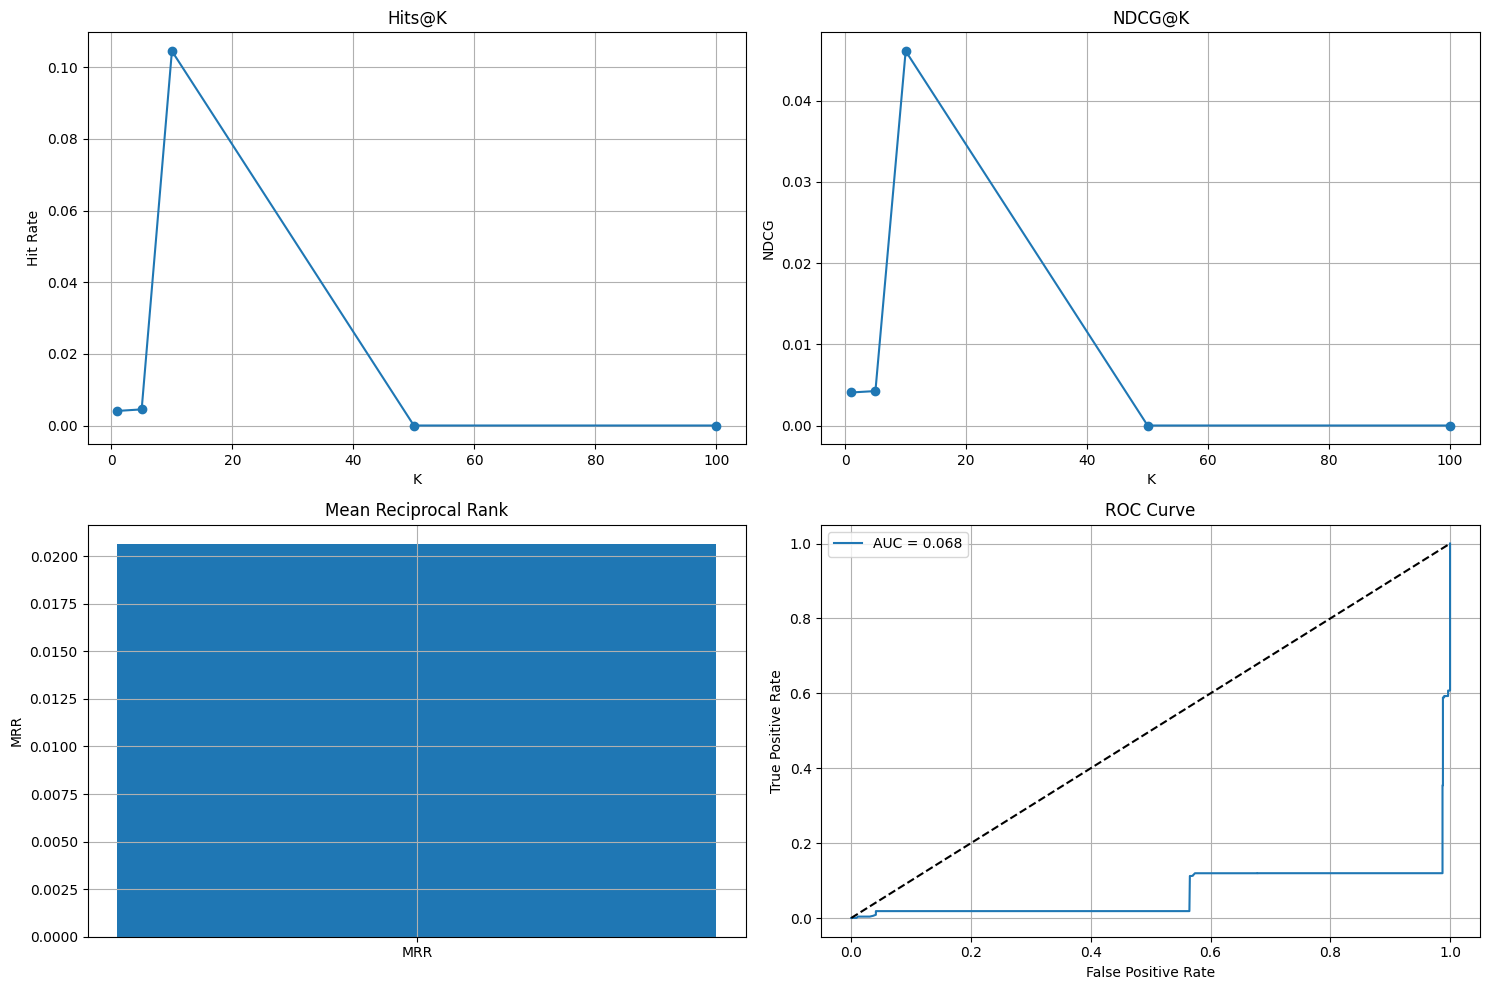


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Found 4967 unique items for evaluation
Precomputing item embeddings...
Building Faiss index...

Integrated Retrieval-Ranking Evaluation Results:
Total users evaluated: 4670
Users with successful evaluation: 4670

Hits@K:
Hits@1: 0.0139
Hits@5: 0.1015
Hits@10: 0.1021
Hits@50: 0.0000
Hits@100: 0.0000

NDCG@K:
NDCG@1: 0.0139
NDCG@5: 0.0790
NDCG@10: 0.0857
NDCG@50: 0.0000
NDCG@100: 0.0000

MRR: 0.0566
Average Precision: 0.2308
ROC AUC: 0.7176


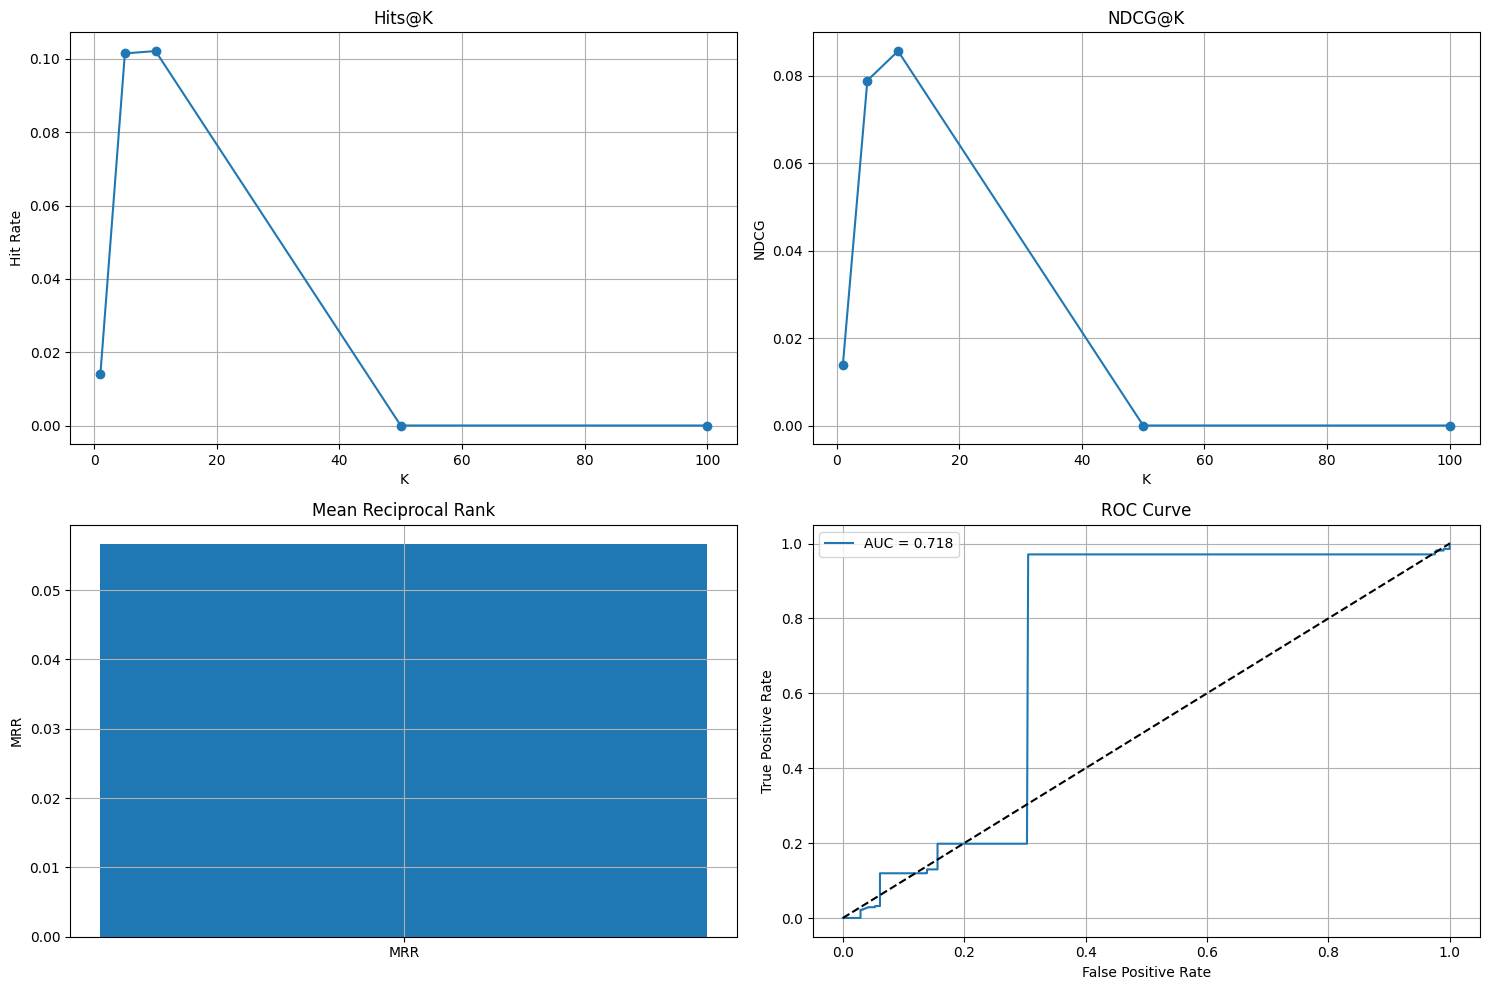


Comparison of Integrated Pipelines:
Weather vs. No-Weather MRR: 0.020615376771693793 vs. 0.05657353590972434

Evaluation pipeline complete!


In [72]:
def integrated_retrieval_ranking_pipeline(query_model, candidate_model, ranking_model, test_df, item_df, events_df, feature_list, k_retrieval=100, k_final=10):
    """
    Integrated retrieval-ranking pipeline that:
    1. Retrieves top-k candidates using the retrieval model
    2. Re-ranks these candidates using the ranking model
    3. Evaluates the end-to-end performance using retrieval metrics
    """
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    
    # Prepare for retrieval
    item_ids = item_df["event_id"].tolist()
    print(f"Found {len(item_df)} unique items for evaluation")
    
    # Precompute item embeddings for retrieval
    print("Precomputing item embeddings...")
    item_embeddings = precompute_item_embeddings(candidate_model, item_df)
    
    # Build Faiss index
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings)
    
    # Metrics to track
    hits_at_k = {k: 0 for k in [1, 5, 10, 50, 100]}
    ndcg_at_k = {k: [] for k in [1, 5, 10, 50, 100]}
    mrr = []
    total_users = 0
    all_scores = []
    all_labels = []
    
    # Process each user
    for user_id, group in test_df.groupby('user_id'):
        try:
            total_users += 1
            
            # Get ground truth events the user actually interacted with
            attended = set(group['event_id'].tolist())
            
            # Get events matching user interests
            user_row = group.iloc[0]
            
            # Skip users with missing data
            if pd.isna(user_row['user_interests']):
                print(f"Skipping user {user_id} due to missing user_interests")
                continue
                
            user_interests = user_row['user_interests'].split(",")
            interest_matched = {
                ev_id for ev_id, ev_type in zip(item_df['event_id'], item_df['event_type'])
                if any(interest.strip().lower() in str(ev_type).lower() for interest in user_interests)
            }
            
            # Combine for relevant items - use the same definition as retrieval evaluation
            ground_truth = attended.union(interest_matched)
            
            if not ground_truth:
                continue
                
            # Step 1: Retrieval - Get user embedding and retrieve candidates
            user_emb = get_user_embedding(query_model, user_row)
            distances, indices = faiss_index.search(user_emb, k_retrieval)
            retrieved_ids = [item_ids[i] for i in indices[0]]
            
            # Get full details of retrieved candidates for ranking
            # Use the original interactions data that already has all the features
            retrieved_events = events_df[events_df['event_id'].isin(retrieved_ids)].copy()
            
            if len(retrieved_events) == 0:
                continue
                
            # Step 2: Prepare features for ranking
            # Add user features to each retrieved event
            for col in ['user_id', 'age', 'user_city', 'user_weather_preference', 'user_interests']:
                if col in user_row:
                    retrieved_events[col] = user_row[col]
            
            # Ensure all required features are present and handle missing values
            ranking_model_input = pd.DataFrame()
            for feat in feature_list:
                if feat in retrieved_events.columns:
                    ranking_model_input[feat] = retrieved_events[feat]
                else:
                    # Fill with appropriate default values based on data type
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'user_weather_preference', 'weather_condition']:
                        ranking_model_input[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate']:
                        ranking_model_input[feat] = 0.0
                    elif feat == 'age':
                        ranking_model_input[feat] = 30  # Default age
                    elif feat == 'event_indoor_capability':
                        ranking_model_input[feat] = True  # Default to indoor capability
                    else:
                        ranking_model_input[feat] = None
            
            # Handle text columns
            text_columns = ["title", "user_interests"]
            for col in text_columns:
                if col in ranking_model_input.columns:
                    ranking_model_input = ranking_model_input.drop(columns=[col])
            
            # Check for and handle missing values
            for col in ranking_model_input.columns:
                if ranking_model_input[col].isna().any():
                    if ranking_model_input[col].dtype == 'object':
                        ranking_model_input[col] = ranking_model_input[col].fillna('unknown')
                    elif ranking_model_input[col].dtype == 'float64' or ranking_model_input[col].dtype == 'float32':
                        ranking_model_input[col] = ranking_model_input[col].fillna(0.0)
                    elif ranking_model_input[col].dtype == 'int64' or ranking_model_input[col].dtype == 'int32':
                        ranking_model_input[col] = ranking_model_input[col].fillna(0)
                    elif ranking_model_input[col].dtype == 'bool':
                        ranking_model_input[col] = ranking_model_input[col].fillna(False)
            
            # Identify categorical features
            cat_features = ranking_model_input.select_dtypes(include=["object", "bool"]).columns.tolist()
            
            # Create CatBoost Pool
            ranking_pool = Pool(
                data=ranking_model_input,
                cat_features=cat_features
            )
            
            # Get ranking scores
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            
            # Create DataFrame with IDs and scores
            ranked_results = pd.DataFrame({
                'event_id': retrieved_events['event_id'],
                'ranking_score': ranking_scores
            })
            
            # Sort by ranking score
            final_recommendations = ranked_results.sort_values('ranking_score', ascending=False)
            final_recommendation_ids = final_recommendations['event_id'].tolist()[:k_final]
            
            # Step 4: Evaluate the final ranked list
            # Calculate Hits@K
            for k in hits_at_k.keys():
                if k <= len(final_recommendation_ids):
                    top_k_recommendations = set(final_recommendation_ids[:k])
                    if any(event_id in top_k_recommendations for event_id in ground_truth):
                        hits_at_k[k] += 1
            
            # Calculate NDCG@K
            for k in ndcg_at_k.keys():
                if k <= len(final_recommendation_ids):
                    # Create relevance array (1 if in ground truth, 0 otherwise)
                    relevance = [1 if event_id in ground_truth else 0 for event_id in final_recommendation_ids[:k]]
                    
                    # Calculate DCG
                    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
                    
                    # Calculate ideal DCG (all relevant items at the top)
                    ideal_relevance = sorted(relevance, reverse=True)
                    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
                    
                    # Calculate NDCG
                    ndcg = dcg / idcg if idcg > 0 else 0
                    ndcg_at_k[k].append(ndcg)
            
            # Calculate MRR (Mean Reciprocal Rank)
            for i, event_id in enumerate(final_recommendation_ids):
                if event_id in ground_truth:
                    mrr.append(1.0 / (i + 1))
                    break
            else:
                mrr.append(0)
                
            # Add to precision-recall data for ROC and PR curves
            for event_id in ground_truth:
                if event_id in final_recommendations['event_id'].values:
                    rank = final_recommendations['event_id'].tolist().index(event_id)
                    score = final_recommendations.iloc[rank]['ranking_score']
                    all_scores.append(score)
                    all_labels.append(1)
                    
                    # Add negative examples
                    neg_events = [e_id for e_id in final_recommendations['event_id'].tolist() if e_id not in ground_truth][:9]
                    for neg_event in neg_events:
                        neg_rank = final_recommendations['event_id'].tolist().index(neg_event)
                        neg_score = final_recommendations.iloc[neg_rank]['ranking_score']
                        all_scores.append(neg_score)
                        all_labels.append(0)
                
        except Exception as e:
            print(f"Error processing user {user_id}: {str(e)}")
            continue
    
    # Calculate final metrics
    hits_at_k_normalized = {k: hits / total_users for k, hits in hits_at_k.items()} if total_users > 0 else hits_at_k
    ndcg_at_k_avg = {k: sum(scores) / len(scores) if scores else 0 for k, scores in ndcg_at_k.items()}
    mrr_avg = sum(mrr) / len(mrr) if mrr else 0
    
    # Print results
    print("\nIntegrated Retrieval-Ranking Evaluation Results:")
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {len(mrr)}")
    
    print("\nHits@K:")
    for k, hit_rate in hits_at_k_normalized.items():
        print(f"Hits@{k}: {hit_rate:.4f}")
    
    print("\nNDCG@K:")
    for k, ndcg in ndcg_at_k_avg.items():
        print(f"NDCG@{k}: {ndcg:.4f}")
    
    print(f"\nMRR: {mrr_avg:.4f}")
    
    # Calculate additional metrics if we have enough data
    ap = None
    roc_auc = None
    if len(all_scores) > 0:
        ap = average_precision_score(all_labels, all_scores)
        print(f"Average Precision: {ap:.4f}")
        
        fpr, tpr, _ = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.4f}")
    
    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot Hits@K
    axes[0, 0].plot(list(hits_at_k_normalized.keys()), list(hits_at_k_normalized.values()), marker='o')
    axes[0, 0].set_title('Hits@K')
    axes[0, 0].set_xlabel('K')
    axes[0, 0].set_ylabel('Hit Rate')
    axes[0, 0].grid(True)
    
    # Plot NDCG@K
    axes[0, 1].plot(list(ndcg_at_k_avg.keys()), list(ndcg_at_k_avg.values()), marker='o')
    axes[0, 1].set_title('NDCG@K')
    axes[0, 1].set_xlabel('K')
    axes[0, 1].set_ylabel('NDCG')
    axes[0, 1].grid(True)
    
    # Plot MRR
    axes[1, 0].bar(['MRR'], [mrr_avg])
    axes[1, 0].set_title('Mean Reciprocal Rank')
    axes[1, 0].set_ylabel('MRR')
    axes[1, 0].grid(True)
    
    # Plot ROC curve if we have data
    if len(all_scores) > 0:
        fpr, tpr, _ = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        axes[1, 1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        axes[1, 1].plot([0, 1], [0, 1], 'k--')
        axes[1, 1].set_title('ROC Curve')
        axes[1, 1].set_xlabel('False Positive Rate')
        axes[1, 1].set_ylabel('True Positive Rate')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('integrated_pipeline_evaluation.png')
    plt.show()
    
    return {
        "hits_at_k": hits_at_k_normalized,
        "ndcg_at_k": ndcg_at_k_avg,
        "mrr": mrr_avg,
        "ap": ap,
        "roc_auc": roc_auc
    }


def main():
    """Main function to run the complete evaluation pipeline"""
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Tuesday, May 13, 2025, 9:34 PM CEST")
    print("=" * 50)
    
    # Convert IDs to strings if they're not already
    interactions_df["user_id"] = interactions_df["user_id"].astype(str)
    interactions_df["event_id"] = interactions_df["event_id"].astype(str)
    events_df["event_id"] = events_df["event_id"].astype(str)
    
    # Split data
    train_df = interactions_df.sample(frac=1.0, random_state=42)
    val_df = interactions_df.sample(frac=0.8, random_state=42)
    
    # Create item dataset
    item_df = events_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    
    # Train ranking models
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/no_weather_ranking_model_2.pkl")

    
    # Evaluate integrated pipelines
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model, 
        candidate_model, 
        weather_model,
        val_df, 
        item_df, 
        events_df,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=100,
        k_final=10
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model, 
        candidate_model, 
        no_weather_model,
        val_df, 
        item_df, 
        events_df,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=100,
        k_final=10
    )
    
    # Compare the results
    print("\nComparison of Integrated Pipelines:")
    print("Weather vs. No-Weather MRR:", 
          weather_results["mrr"], "vs.", 
          no_weather_results["mrr"])
    
    print("\nEvaluation pipeline complete!")
    return {
        "weather_results": weather_results,
        "no_weather_results": no_weather_results
    }

if __name__ == "__main__":
    main()


In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from catboost import CatBoostClassifier, Pool
import joblib
import os

# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')
print(interactions_df.isnull().sum())

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'indoor_outdoor_preference': 'user_weather_preference',
    'joinedAt': 'signup_date'
}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)

# Convert IDs to strings
users_df["user_id"] = users_df["user_id"].astype(str)
events_df["event_id"] = events_df["event_id"].astype(str)
interactions_df["user_id"] = interactions_df["user_id"].astype(str)
interactions_df["event_id"] = interactions_df["event_id"].astype(str)

import math

def safe_id_convert(x):
    if x is None:
        return "unknown"
    if isinstance(x, float):
        if math.isnan(x):
            return "unknown"
        else:
            return str(int(x))
    try:
        return str(int(float(x)))
    except Exception:
        return "unknown"

# Apply safe conversion
users_df["user_id"] = users_df["user_id"].apply(safe_id_convert)
events_df["event_id"] = events_df["event_id"].apply(safe_id_convert)
interactions_df["user_id"] = interactions_df["user_id"].apply(safe_id_convert)
interactions_df["event_id"] = interactions_df["event_id"].apply(safe_id_convert)

# Remove rows with unknown IDs to avoid mismatches
users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

# Verify conversion
print("Sample user_id in interactions data after conversion:", interactions_df["user_id"].head().tolist())
print("Sample user_id in users data after conversion:", users_df["user_id"].head().tolist())
# Print the first few user IDs from each dataset to compare
print("\nFirst 10 user IDs in interactions_df:", sorted(list(interactions_df["user_id"].unique()))[:10])
print("First 10 user IDs in users_df:", sorted(list(users_df["user_id"].unique()))[:10])

# Check intersection properly
common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
print(f"Number of common users: {len(common_users)}")
print("First 10 common user IDs:", sorted(list(common_users))[:10])

# Check if there are any common users at all
if len(common_users) == 0:
    print("ERROR: No common users between datasets!")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# Define features for ranking models
NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city', 
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests']

# Print data info
print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

# Split data for evaluation
test_interactions = interactions_df.sample(frac=1.0, random_state=42)
print(f"Test interactions: {len(test_interactions)}")

# Function to get user embeddings from the query model
def get_user_embeddings(query_model, user_ids, batch_size=128):
    """Get embeddings for a batch of users"""
    print(f"Looking for user IDs: {user_ids}")
    
    # Filter users and get their data
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    print(f"Found {len(batch_users)} users in users_df")
    
    if len(batch_users) == 0:
        # Debug: Check if the user ID exists in a different format
        for user_id in user_ids:
            # Try different formats (with/without decimal, as int, etc.)
            potential_formats = [
                user_id,
                str(int(float(user_id))) if user_id.replace('.', '').isdigit() else user_id,
                user_id.split('.')[0] if '.' in user_id else user_id
            ]
            for fmt in potential_formats:
                if fmt in users_df['user_id'].values:
                    print(f"Found user {user_id} as {fmt}")
        
        print("Available user IDs (first 10):", users_df['user_id'].head(10).tolist())
        return None

    
    # Ensure all required columns are present and handle missing values
    for col in QUERY_FEATURES:
        if col not in batch_users.columns:
            batch_users[col] = "unknown" if col in ["user_city", "user_interests"] else 0
        elif batch_users[col].isnull().any():
            if col in ["user_city", "user_interests"]:
                batch_users[col] = batch_users[col].fillna("unknown")
            else:
                batch_users[col] = batch_users[col].fillna(0)
    
    # Prepare batch inputs
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    
    # Get user embeddings
    user_embeddings = query_model(batch_input)
    return user_embeddings.numpy()

# Function to get event embeddings from the candidate model
def get_event_embeddings(candidate_model, events_data=None):
    """Get embeddings for all events"""
    if events_data is None:
        events_data = events_df.copy()
    
    # Ensure all required columns are present
    for col in CANDIDATE_FEATURES:
        if col not in events_data.columns:
            events_data[col] = "unknown" if col in ["event_city", "event_type", "title"] else "0"
        elif events_data[col].isnull().any():
            if col in ["event_city", "event_type", "title"]:
                events_data[col] = events_data[col].fillna("unknown")
            else:
                events_data[col] = events_data[col].fillna("0")
    
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    
    event_ids = []
    event_embeddings = []
    
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    
    if not event_embeddings:
        raise ValueError("No event embeddings were generated")
        
    return np.concatenate(event_embeddings), event_ids

# Function to build FAISS index for fast similarity search
def build_faiss_index(embeddings):
    """Build a FAISS index for fast similarity search"""
    # Normalize embeddings for cosine similarity
    faiss.normalize_L2(embeddings)
    
    # Create index
    d = embeddings.shape[1]  # Dimensionality of embeddings
    index = faiss.IndexFlatIP(d)  # Inner product (cosine similarity for normalized vectors)
    index.add(embeddings)
    
    return index

# Integrated retrieval-ranking pipeline
def integrated_retrieval_ranking_pipeline(query_model, candidate_model, ranking_model, test_interactions, feature_list, k_retrieval=100, k_final=10):
    """
    Integrated retrieval-ranking pipeline that:
    1. Retrieves top-k candidates using the retrieval model
    2. Re-ranks these candidates using the ranking model
    3. Evaluates the end-to-end performance
    """
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    
    # Get all event embeddings and build index
    print("Computing event embeddings...")
    event_embeddings, event_ids = get_event_embeddings(candidate_model)
    
    # Build Faiss index
    print("Building Faiss index...")
    faiss_index = build_faiss_index(event_embeddings)
    
    # Create mapping from event_id to index
    event_id_to_idx = {id: i for i, id in enumerate(event_ids)}
    
    # Metrics to track
    hits_at_k = {k: 0 for k in [1, 5, 10, 50, 100]}
    ndcg_at_k = {k: [] for k in [1, 5, 10, 50, 100]}
    mrr = []
    total_users = 0
    successful_users = 0
    all_scores = []
    all_labels = []
    
    # Group interactions by user
    user_groups = test_interactions.groupby('user_id')
    
    # Process each user
    for user_id, group in user_groups:
        try:
            total_users += 1
            
            # Get ground truth events the user actually interacted with
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            
            if len(attended_events) == 0:
                print(f"Skipping user {user_id} - no positive interactions")
                continue
                
            # Get user embedding
            user_embedding = get_user_embeddings(query_model, [user_id])
            
            if user_embedding is None or len(user_embedding) == 0:
                print(f"Skipping user {user_id} - failed to get embedding")
                continue
                
            # Normalize for cosine similarity
            faiss.normalize_L2(user_embedding)
            
            # Retrieve top-k candidates
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_event_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_event_indices]
            
            # Get event details for ranking
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            
            if len(retrieved_events_df) == 0:
                print(f"Skipping user {user_id} - no events retrieved")
                continue
                
            # Get user details
            user_data = users_df[users_df['user_id'] == user_id]
            
            if len(user_data) == 0:
                print(f"Skipping user {user_id} - user not found in users_df")
                continue
                
            user_data = user_data.iloc[0]
            
            # Prepare data for ranking by merging user and event information
            ranking_data = []
            for _, event in retrieved_events_df.iterrows():
                # Create a row with all necessary features
                row = {
                    'event_id': event['event_id'],
                    'event_type': event['event_type'],
                    'event_city': event['event_city'],
                    'attendance_rate': event['attendance_rate'],
                    'event_indoor_capability': event['event_indoor_capability'],
                    'user_city': user_data['user_city'],
                    'age': user_data['age'],
                    'user_interests': user_data['user_interests']
                }
                
                # Add weather features if needed
                if 'weather_condition' in feature_list:
                    row['weather_condition'] = event['weather_condition']
                    row['temperature'] = event['temperature']
                    row['user_weather_preference'] = user_data['user_weather_preference']
                
                # Use the interaction_distance_to_event from interactions data if available
                # Otherwise, use a default value
                matching_interaction = interactions_df[
                    (interactions_df['user_id'] == user_id) & 
                    (interactions_df['event_id'] == event['event_id'])
                ]
                
                if len(matching_interaction) > 0:
                    row['interaction_distance_to_event'] = matching_interaction['interaction_distance_to_event'].iloc[0]
                else:
                    # Use average distance as default
                    row['interaction_distance_to_event'] = interactions_df['interaction_distance_to_event'].mean()
                
                ranking_data.append(row)
            
            # Create DataFrame for ranking
            ranking_df = pd.DataFrame(ranking_data)
            
            # Ensure all required features are present
            for feat in feature_list:
                if feat not in ranking_df.columns:
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'user_weather_preference', 'weather_condition']:
                        ranking_df[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate']:
                        ranking_df[feat] = 0.0
                    elif feat == 'age':
                        ranking_df[feat] = 30  # Default age
                    elif feat == 'event_indoor_capability':
                        ranking_df[feat] = True  # Default to indoor capability
            
            # Handle text columns
            text_columns = ["title", "user_interests"]
            ranking_features = ranking_df[feature_list].copy()
            ranking_features = ranking_features.drop(columns=[col for col in text_columns if col in ranking_features.columns])
            
            # Fill missing values
            for col in ranking_features.columns:
                if ranking_features[col].dtype == 'object':
                    ranking_features[col] = ranking_features[col].fillna('unknown')
                elif ranking_features[col].dtype == 'float64' or ranking_features[col].dtype == 'float32':
                    ranking_features[col] = ranking_features[col].fillna(0.0)
                elif ranking_features[col].dtype == 'int64' or ranking_features[col].dtype == 'int32':
                    ranking_features[col] = ranking_features[col].fillna(0)
                elif ranking_features[col].dtype == 'bool':
                    ranking_features[col] = ranking_features[col].fillna(False)
            
            # Identify categorical features
            cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
            
            # Create CatBoost Pool
            ranking_pool = Pool(
                data=ranking_features,
                cat_features=cat_features
            )
            
            # Get ranking scores
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            
            # Create DataFrame with IDs and scores
            ranked_results = pd.DataFrame({
                'event_id': ranking_df['event_id'],
                'ranking_score': ranking_scores
            })
            
            # Sort by ranking score
            final_recommendations = ranked_results.sort_values('ranking_score', ascending=False)
            final_recommendation_ids = final_recommendations['event_id'].tolist()[:k_final]
            
            # Calculate Hits@K
            for k in hits_at_k.keys():
                if k <= len(final_recommendation_ids):
                    top_k_recommendations = set(final_recommendation_ids[:k])
                    if any(event_id in top_k_recommendations for event_id in attended_events):
                        hits_at_k[k] += 1
            
            # Calculate NDCG@K
            for k in ndcg_at_k.keys():
                if k <= len(final_recommendation_ids):
                    # Create relevance array (1 if in ground truth, 0 otherwise)
                    relevance = [1 if event_id in attended_events else 0 for event_id in final_recommendation_ids[:k]]
                    
                    # Calculate DCG
                    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
                    
                    # Calculate ideal DCG (all relevant items at the top)
                    ideal_relevance = sorted(relevance, reverse=True)
                    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
                    
                    # Calculate NDCG
                    ndcg = dcg / idcg if idcg > 0 else 0
                    ndcg_at_k[k].append(ndcg)
            
            # Calculate MRR (Mean Reciprocal Rank)
            for i, event_id in enumerate(final_recommendation_ids):
                if event_id in attended_events:
                    mrr.append(1.0 / (i + 1))
                    break
            else:
                mrr.append(0)
                
            # Add to precision-recall data for ROC and PR curves
            for event_id in attended_events:
                if event_id in final_recommendations['event_id'].values:
                    rank = final_recommendations['event_id'].tolist().index(event_id)
                    score = final_recommendations.iloc[rank]['ranking_score']
                    all_scores.append(score)
                    all_labels.append(1)
                    
                    # Add negative examples
                    neg_events = [e_id for e_id in final_recommendations['event_id'].tolist() if e_id not in attended_events][:9]
                    for neg_event in neg_events:
                        neg_rank = final_recommendations['event_id'].tolist().index(neg_event)
                        neg_score = final_recommendations.iloc[neg_rank]['ranking_score']
                        all_scores.append(neg_score)
                        all_labels.append(0)
            
            successful_users += 1
            
            # Print progress
            if successful_users % 100 == 0:
                print(f"Processed {successful_users} users successfully")
                
        except Exception as e:
            print(f"Error processing user {user_id}: {str(e)}")
            continue
    
    # Calculate final metrics
    hits_at_k_normalized = {k: hits / total_users for k, hits in hits_at_k.items()} if total_users > 0 else hits_at_k
    ndcg_at_k_avg = {k: sum(scores) / len(scores) if scores else 0 for k, scores in ndcg_at_k.items()}
    mrr_avg = sum(mrr) / len(mrr) if mrr else 0
    
    # Print results
    print("\nIntegrated Retrieval-Ranking Evaluation Results:")
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {successful_users}")
    
    print("\nHits@K:")
    for k, hit_rate in hits_at_k_normalized.items():
        print(f"Hits@{k}: {hit_rate:.4f}")
    
    print("\nNDCG@K:")
    for k, ndcg in ndcg_at_k_avg.items():
        print(f"NDCG@{k}: {ndcg:.4f}")
    
    print(f"\nMRR: {mrr_avg:.4f}")
    
    # Calculate additional metrics if we have enough data
    ap = None
    roc_auc = None
    if len(all_scores) > 0:
        ap = average_precision_score(all_labels, all_scores)
        print(f"Average Precision: {ap:.4f}")
        
        fpr, tpr, _ = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.4f}")
    
    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot Hits@K
    axes[0, 0].plot(list(hits_at_k_normalized.keys()), list(hits_at_k_normalized.values()), marker='o')
    axes[0, 0].set_title('Hits@K')
    axes[0, 0].set_xlabel('K')
    axes[0, 0].set_ylabel('Hit Rate')
    axes[0, 0].grid(True)
    
    # Plot NDCG@K
    axes[0, 1].plot(list(ndcg_at_k_avg.keys()), list(ndcg_at_k_avg.values()), marker='o')
    axes[0, 1].set_title('NDCG@K')
    axes[0, 1].set_xlabel('K')
    axes[0, 1].set_ylabel('NDCG')
    axes[0, 1].grid(True)
    
    # Plot MRR
    axes[1, 0].bar(['MRR'], [mrr_avg])
    axes[1, 0].set_title('Mean Reciprocal Rank')
    axes[1, 0].set_ylabel('MRR')
    axes[1, 0].grid(True)
    
    # Plot ROC curve if we have data
    if len(all_scores) > 0:
        fpr, tpr, _ = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        axes[1, 1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        axes[1, 1].plot([0, 1], [0, 1], 'k--')
        axes[1, 1].set_title('ROC Curve')
        axes[1, 1].set_xlabel('False Positive Rate')
        axes[1, 1].set_ylabel('True Positive Rate')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('integrated_pipeline_evaluation.png')
    plt.show()
    
    return {
        "hits_at_k": hits_at_k_normalized,
        "ndcg_at_k": ndcg_at_k_avg,
        "mrr": mrr_avg,
        "ap": ap,
        "roc_auc": roc_auc,
        "total_users": total_users,
        "successful_users": successful_users
    }

def main():
    """Main function to run the complete evaluation pipeline"""
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Wednesday, May 14, 2025, 12:56 AM CEST")
    print("=" * 50)
    
    print("user_id in interactions data",interactions_df["user_id"].unique()[:4])
    print("user_id in users data",users_df["user_id"].unique()[:4])
    # Load pre-trained models
    try:
        candidate_model = model.item_model
        query_model = model.query_model
        # Load ranking models
        weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/weather_ranking_model.pkl")
        no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/no_weather_ranking_model_2.pkl")

        print("Successfully loaded all models")
    except Exception as e:
        print(f"Error loading models: {e}")
        print("Please ensure the models are available at the specified paths")
        return
    
    # Evaluate integrated pipelines
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model, 
        candidate_model, 
        weather_model,
        test_interactions, 
        WEATHER_SELECTED_FEATURES,
        k_retrieval=100,
        k_final=10
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model, 
        candidate_model, 
        no_weather_model,
        test_interactions, 
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=100,
        k_final=10
    )
    
    # Compare the results
    print("\nComparison of Integrated Pipelines:")
    print("Weather vs. No-Weather MRR:", 
          weather_results["mrr"], "vs.", 
          no_weather_results["mrr"])
    
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        difference = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {difference:.2f}%")
    
    print("\nEvaluation pipeline complete!")
    return {
        "weather_results": weather_results,
        "no_weather_results": no_weather_results
    }

if __name__ == "__main__":
    main()


Unnamed: 0               0
user_id              28249
event_id             28249
interaction_type     28249
distance_to_event    28249
interaction_label    28249
dtype: int64
Sample user_id in interactions data after conversion: ['3468617687', '487910947', '2769572227', '2974942354', '3468617687']
Sample user_id in users data after conversion: ['3197468391', '1091720544', '3341263967', '1363661070', '3104149470']

First 10 user IDs in interactions_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
First 10 user IDs in users_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
Number of common users: 5315
First 10 common user IDs: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
Users: 5315, Events: 4967, Interact

KeyboardInterrupt: 

Unnamed: 0               0
user_id              28249
event_id             28249
interaction_type     28249
distance_to_event    28249
interaction_label    28249
dtype: int64
Sample user_id in interactions data after conversion: ['3468617687', '487910947', '2769572227', '2974942354', '3468617687']
Sample user_id in users data after conversion: ['3197468391', '1091720544', '3341263967', '1363661070', '3104149470']

First 10 user IDs in interactions_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
First 10 user IDs in users_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
Number of common users: 5315
First 10 common user IDs: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
Filtered interactions with valid us

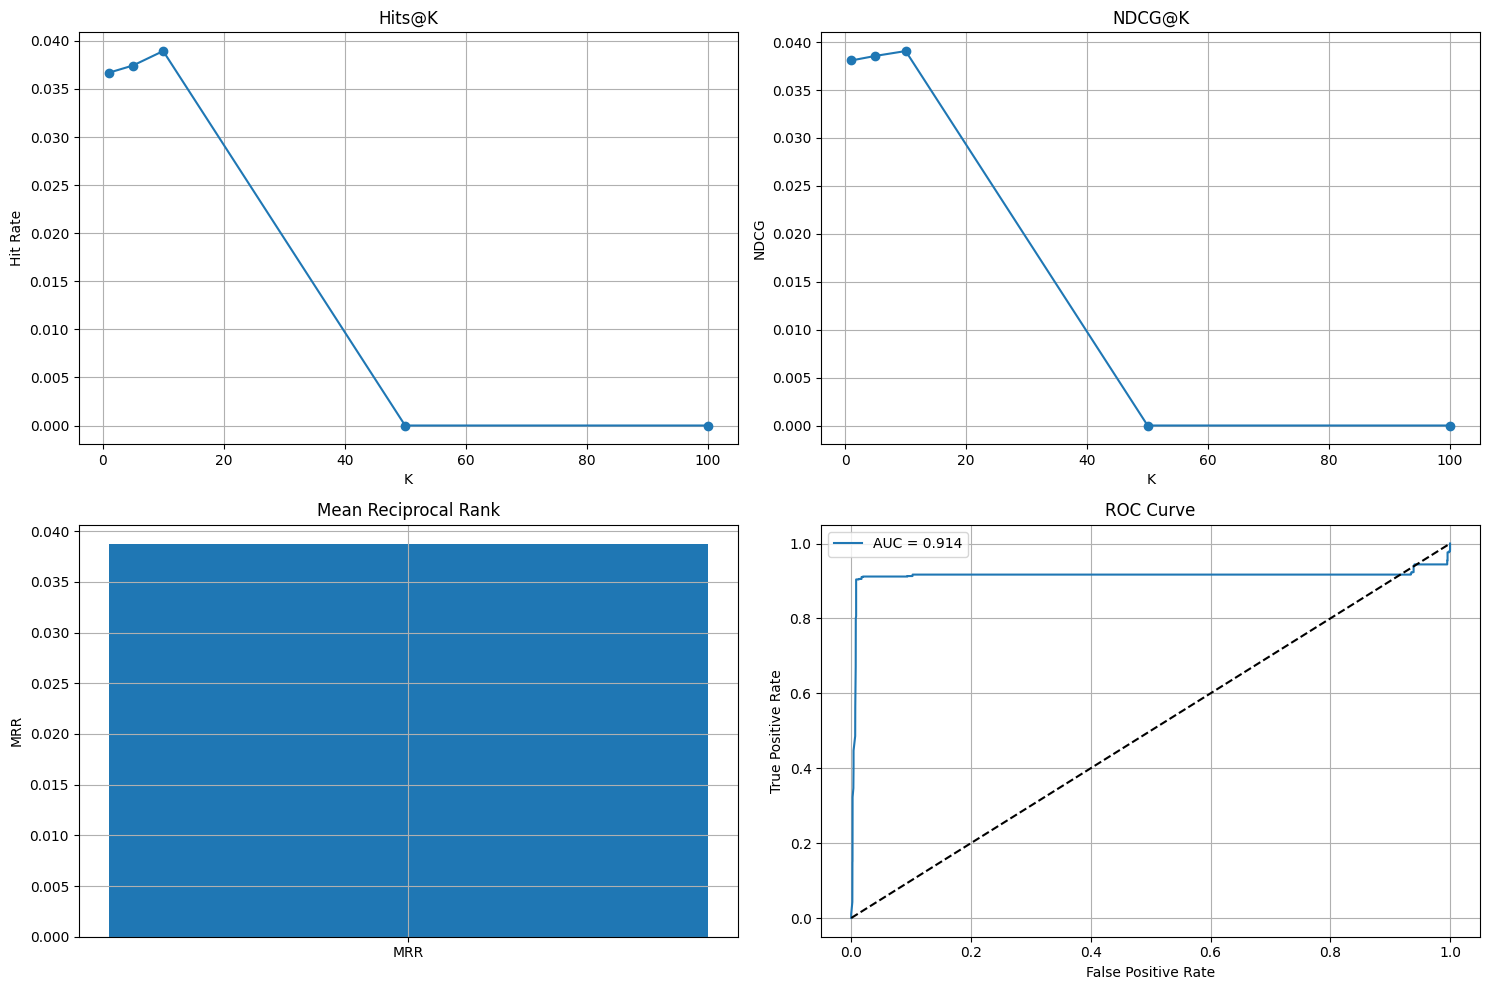


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Computing event embeddings...
First 5 event IDs from embeddings: ['2587616435', '1145166049', '920600431', '3580637647', '2396566946']
First 5 event IDs from events_df: ['2587616435', '1145166049', '920600431', '3580637647', '2396566946']
Number of common event IDs: 4967 out of 4967 embedded events
Building Faiss index...
User 1000957666 - Top 5 retrieval distances: [-0.03874592 -0.03896384 -0.03896384 -0.03909315 -0.03909315]
User 1000957666 - Retrieved 100 events, found 100 in events_df
User 1000957666 - Top 3 recommendations: ['3661050173', '549024328', '1272700922']
User 1000957666 - Top 3 scores: [0.50435244 0.50435244 0.50374124]
User 1002026815 - Top 5 retrieval distances: [-0.03091806 -0.03111673 -0.03111673 -0.03123464 -0.03123464]
User 1002026815 - Retrieved 100 events, found 100 in events_df
User 1002026815 - Top 3 recommendations: ['3661050173', '54

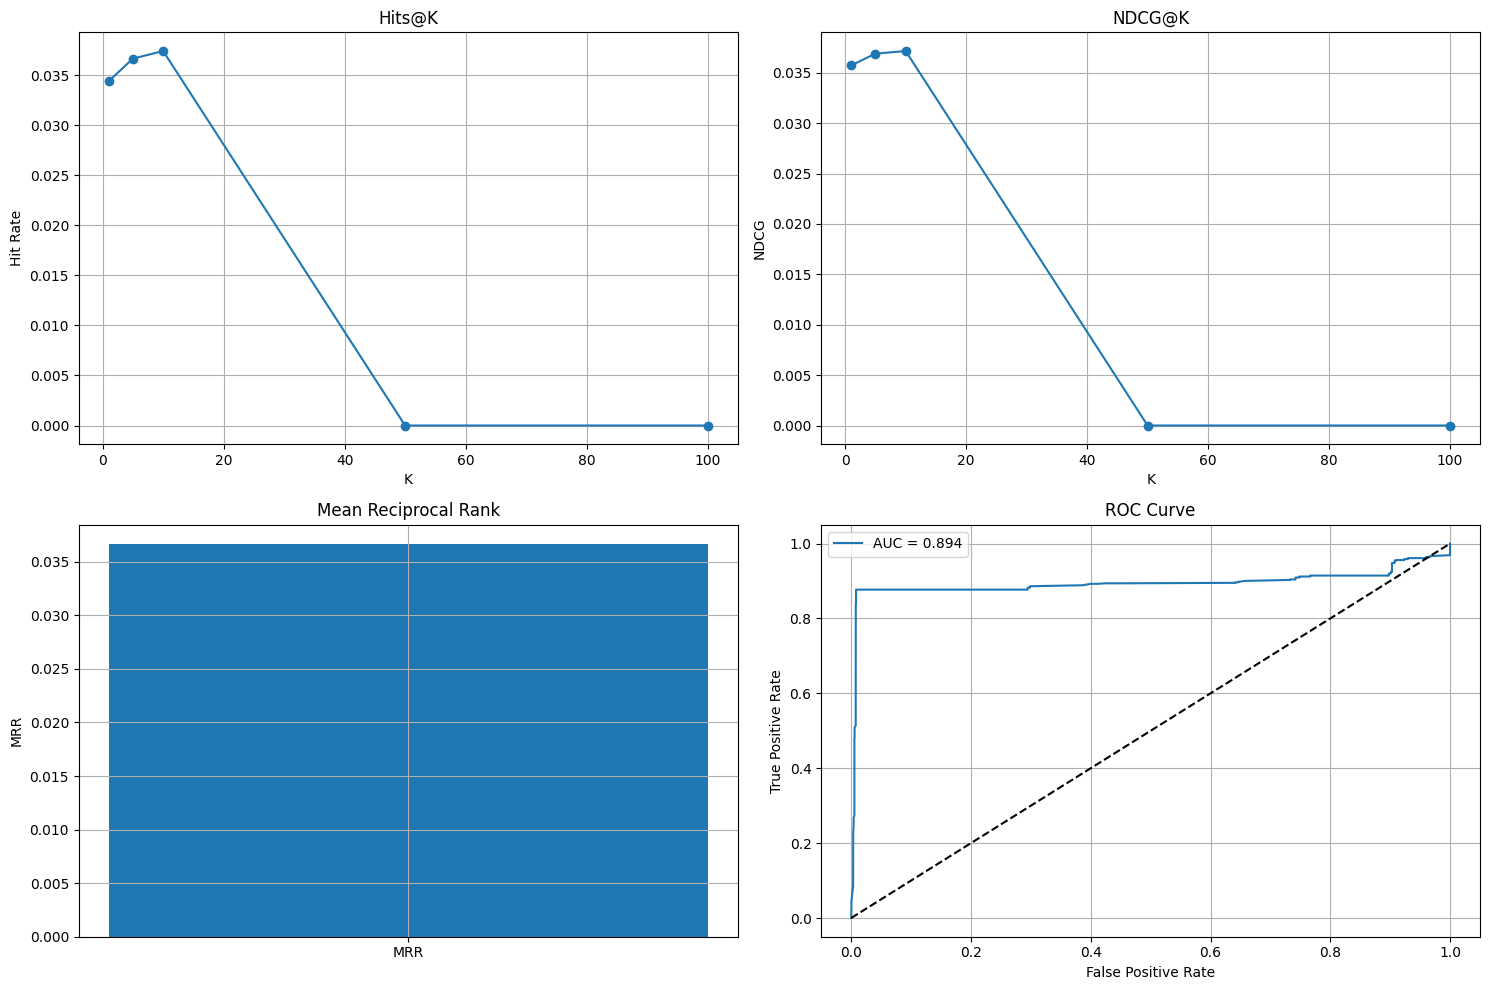


Comparison of Integrated Pipelines:
Weather vs. No-Weather MRR: 0.03869357638888889 vs. 0.036612103174603165
Weather features improve MRR by 5.69%

Evaluation pipeline complete!


In [73]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from catboost import CatBoostClassifier, Pool
import joblib
import os
import math

# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')
print(interactions_df.isnull().sum())

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'indoor_outdoor_preference': 'user_weather_preference',
    'joinedAt': 'signup_date'
}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)

def safe_id_convert(x):
    if x is None:
        return "unknown"
    if isinstance(x, float):
        if math.isnan(x):
            return "unknown"
        else:
            return str(int(x))
    try:
        return str(int(float(x)))
    except Exception:
        return "unknown"

# Apply safe conversion
users_df["user_id"] = users_df["user_id"].apply(safe_id_convert)
events_df["event_id"] = events_df["event_id"].apply(safe_id_convert)
interactions_df["user_id"] = interactions_df["user_id"].apply(safe_id_convert)
interactions_df["event_id"] = interactions_df["event_id"].apply(safe_id_convert)

# Remove rows with unknown IDs to avoid mismatches
users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

# Verify conversion
print("Sample user_id in interactions data after conversion:", interactions_df["user_id"].head().tolist())
print("Sample user_id in users data after conversion:", users_df["user_id"].head().tolist())

# Print the first few user IDs from each dataset to compare
print("\nFirst 10 user IDs in interactions_df:", sorted(list(interactions_df["user_id"].unique()))[:10])
print("First 10 user IDs in users_df:", sorted(list(users_df["user_id"].unique()))[:10])

# Check intersection properly
common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
print(f"Number of common users: {len(common_users)}")
print("First 10 common user IDs:", sorted(list(common_users))[:10])

# Filter interactions to only include users that exist in the users dataset
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
print(f"Filtered interactions with valid users: {len(interactions_df)}")

# Check intersection of event IDs
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
print(f"Number of common events: {len(common_events)}")
print("First 10 common event IDs:", sorted(list(common_events))[:10])

# Filter interactions to only include events that exist in the events dataset
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]
print(f"Filtered interactions with valid events: {len(interactions_df)}")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# Define features for ranking models
NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city', 
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests']

# Print data info
print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

# Split data for evaluation
test_interactions = interactions_df.sample(frac=1.0, random_state=42)
print(f"Test interactions: {len(test_interactions)}")

# Function to get user embeddings from the query model
def get_user_embeddings(query_model, user_ids, batch_size=128):
    """Get embeddings for a batch of users"""
    # Filter users and get their data
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    
    if len(batch_users) == 0:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    
    # Ensure all required columns are present and handle missing values
    for col in QUERY_FEATURES:
        if col not in batch_users.columns:
            batch_users[col] = "unknown" if col in ["user_city", "user_interests"] else 0
        elif batch_users[col].isnull().any():
            if col in ["user_city", "user_interests"]:
                batch_users[col] = batch_users[col].fillna("unknown")
            else:
                batch_users[col] = batch_users[col].fillna(0)
    
    # Prepare batch inputs
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    
    # Get user embeddings
    try:
        user_embeddings = query_model(batch_input)
        return user_embeddings.numpy()
    except Exception as e:
        print(f"Error getting user embeddings: {e}")
        return None

# Function to get event embeddings from the candidate model
def get_event_embeddings(candidate_model, events_data=None):
    """Get embeddings for all events"""
    if events_data is None:
        events_data = events_df.copy()
    
    # Ensure all required columns are present
    for col in CANDIDATE_FEATURES:
        if col not in events_data.columns:
            events_data[col] = "unknown" if col in ["event_city", "event_type", "title"] else "0"
        elif events_data[col].isnull().any():
            if col in ["event_city", "event_type", "title"]:
                events_data[col] = events_data[col].fillna("unknown")
            else:
                events_data[col] = events_data[col].fillna("0")
    
    # Convert to TensorFlow dataset
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    
    event_ids = []
    event_embeddings = []
    
    for batch in events_dataset:
        try:
            batch_embeddings = candidate_model(batch)
            event_ids.extend(batch["event_id"].numpy())
            event_embeddings.append(batch_embeddings.numpy())
        except Exception as e:
            print(f"Error processing event batch: {e}")
            continue
    
    if not event_embeddings:
        raise ValueError("No event embeddings were generated")
        
    return np.concatenate(event_embeddings), event_ids

# Function to build FAISS index for fast similarity search
def build_faiss_index(embeddings):
    """Build a FAISS index for fast similarity search"""
    # Normalize embeddings for cosine similarity
    faiss.normalize_L2(embeddings)
    
    # Create index
    d = embeddings.shape[1]  # Dimensionality of embeddings
    index = faiss.IndexFlatIP(d)  # Inner product (cosine similarity for normalized vectors)
    index.add(embeddings)
    
    return index

# Integrated retrieval-ranking pipeline
def integrated_retrieval_ranking_pipeline(query_model, candidate_model, ranking_model, test_interactions, feature_list, k_retrieval=100, k_final=10):
    """
    Integrated retrieval-ranking pipeline that:
    1. Retrieves top-k candidates using the retrieval model
    2. Re-ranks these candidates using the ranking model
    3. Evaluates the end-to-end performance
    """
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    
    # Get all event embeddings and build index
    print("Computing event embeddings...")
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    
    # Convert byte strings to regular strings if needed
    event_ids = []
    for event_id in event_ids_bytes:
        if isinstance(event_id, bytes):
            event_ids.append(event_id.decode('utf-8'))
        else:
            event_ids.append(str(event_id))
    
    # Debug: Check event IDs
    print(f"First 5 event IDs from embeddings: {event_ids[:5]}")
    print(f"First 5 event IDs from events_df: {events_df['event_id'].head(5).tolist()}")
    
    # Check if event IDs match
    common_event_ids = set(event_ids).intersection(set(events_df['event_id']))
    print(f"Number of common event IDs: {len(common_event_ids)} out of {len(event_ids)} embedded events")
    
    # Build Faiss index
    print("Building Faiss index...")
    faiss_index = build_faiss_index(event_embeddings)
    
    # Create mapping from event_id to index
    event_id_to_idx = {id: i for i, id in enumerate(event_ids)}
    
    # Metrics to track
    hits_at_k = {k: 0 for k in [1, 5, 10, 50, 100]}
    ndcg_at_k = {k: [] for k in [1, 5, 10, 50, 100]}
    mrr = []
    total_users = 0
    successful_users = 0
    all_scores = []
    all_labels = []
    
    # Group interactions by user
    user_groups = test_interactions.groupby('user_id')
    
    # Process each user
    for user_id, group in user_groups:
        try:
            total_users += 1
            
            # Get ground truth events the user actually interacted with
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            
            if len(attended_events) == 0:
                print(f"Skipping user {user_id} - no positive interactions")
                continue
                
            # Debug: Check if attended events exist in events_df
            events_found = set(attended_events).intersection(set(events_df['event_id']))
            if len(events_found) < len(attended_events):
                print(f"Warning: Only {len(events_found)} out of {len(attended_events)} attended events found in events_df for user {user_id}")
            
            # Get user embedding
            user_embedding = get_user_embeddings(query_model, [user_id])
            
            if user_embedding is None or len(user_embedding) == 0:
                print(f"Skipping user {user_id} - failed to get embedding")
                continue
                
            # Normalize for cosine similarity
            faiss.normalize_L2(user_embedding)
            
            # Retrieve top-k candidates
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_event_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_event_indices]
            
            # Debug: Print distances for first few retrieved events
            print(f"User {user_id} - Top 5 retrieval distances: {distances[0][:5]}")
            
            # Get event details for ranking
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            
            # Debug: Check how many events were found
            print(f"User {user_id} - Retrieved {len(retrieved_event_ids)} events, found {len(retrieved_events_df)} in events_df")
            
            if len(retrieved_events_df) == 0:
                print(f"Skipping user {user_id} - no events retrieved")
                # Debug: Check a few retrieved event IDs
                print(f"Sample retrieved event IDs: {retrieved_event_ids[:5]}")
                # Check if these IDs exist in events_df
                for event_id in retrieved_event_ids[:5]:
                    if event_id in events_df['event_id'].values:
                        print(f"  Event {event_id} exists in events_df")
                    else:
                        print(f"  Event {event_id} NOT found in events_df")
                continue
                
            # Get user details
            user_data = users_df[users_df['user_id'] == user_id]
            
            if len(user_data) == 0:
                print(f"Skipping user {user_id} - user not found in users_df")
                continue
                
            user_data = user_data.iloc[0]
            
            # Prepare data for ranking by merging user and event information
            ranking_data = []
            for _, event in retrieved_events_df.iterrows():
                # Create a row with all necessary features
                row = {
                    'event_id': event['event_id'],
                    'event_type': event['event_type'],
                    'event_city': event['event_city'],
                    'attendance_rate': event['attendance_rate'],
                    'event_indoor_capability': event['event_indoor_capability'],
                    'user_city': user_data['user_city'],
                    'age': user_data['age'],
                    'user_interests': user_data['user_interests']
                }
                
                # Add weather features if needed
                if 'weather_condition' in feature_list:
                    row['weather_condition'] = event['weather_condition']
                    row['temperature'] = event['temperature']
                    row['user_weather_preference'] = user_data['user_weather_preference']
                
                # Use the interaction_distance_to_event from interactions data if available
                # Otherwise, use a default value
                matching_interaction = interactions_df[
                    (interactions_df['user_id'] == user_id) & 
                    (interactions_df['event_id'] == event['event_id'])
                ]
                
                if len(matching_interaction) > 0:
                    row['interaction_distance_to_event'] = matching_interaction['interaction_distance_to_event'].iloc[0]
                else:
                    # Use average distance as default
                    row['interaction_distance_to_event'] = interactions_df['interaction_distance_to_event'].mean()
                
                ranking_data.append(row)
            
            # Create DataFrame for ranking
            ranking_df = pd.DataFrame(ranking_data)
            
            # Ensure all required features are present
            for feat in feature_list:
                if feat not in ranking_df.columns:
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'user_weather_preference', 'weather_condition']:
                        ranking_df[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate']:
                        ranking_df[feat] = 0.0
                    elif feat == 'age':
                        ranking_df[feat] = 30  # Default age
                    elif feat == 'event_indoor_capability':
                        ranking_df[feat] = True  # Default to indoor capability
            
            # Handle text columns
            text_columns = ["title", "user_interests"]
            ranking_features = ranking_df[feature_list].copy()
            ranking_features = ranking_features.drop(columns=[col for col in text_columns if col in ranking_features.columns])
            
            # Fill missing values
            for col in ranking_features.columns:
                if ranking_features[col].dtype == 'object':
                    ranking_features[col] = ranking_features[col].fillna('unknown')
                elif ranking_features[col].dtype == 'float64' or ranking_features[col].dtype == 'float32':
                    ranking_features[col] = ranking_features[col].fillna(0.0)
                elif ranking_features[col].dtype == 'int64' or ranking_features[col].dtype == 'int32':
                    ranking_features[col] = ranking_features[col].fillna(0)
                elif ranking_features[col].dtype == 'bool':
                    ranking_features[col] = ranking_features[col].fillna(False)
            
            # Identify categorical features
            cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
            
            # Create CatBoost Pool
            ranking_pool = Pool(
                data=ranking_features,
                cat_features=cat_features
            )
            
            # Get ranking scores
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            
            # Create DataFrame with IDs and scores
            ranked_results = pd.DataFrame({
                'event_id': ranking_df['event_id'],
                'ranking_score': ranking_scores
            })
            
            # Sort by ranking score
            final_recommendations = ranked_results.sort_values('ranking_score', ascending=False)
            final_recommendation_ids = final_recommendations['event_id'].tolist()[:k_final]
            
            # Debug: Print top recommendations
            print(f"User {user_id} - Top 3 recommendations: {final_recommendation_ids[:3]}")
            print(f"User {user_id} - Top 3 scores: {final_recommendations['ranking_score'].head(3).values}")
            
            # Calculate Hits@K
            for k in hits_at_k.keys():
                if k <= len(final_recommendation_ids):
                    top_k_recommendations = set(final_recommendation_ids[:k])
                    if any(event_id in top_k_recommendations for event_id in attended_events):
                        hits_at_k[k] += 1
            
            # Calculate NDCG@K
            for k in ndcg_at_k.keys():
                if k <= len(final_recommendation_ids):
                    # Create relevance array (1 if in ground truth, 0 otherwise)
                    relevance = [1 if event_id in attended_events else 0 for event_id in final_recommendation_ids[:k]]
                    
                    # Calculate DCG
                    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
                    
                    # Calculate ideal DCG (all relevant items at the top)
                    ideal_relevance = sorted(relevance, reverse=True)
                    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
                    
                    # Calculate NDCG
                    ndcg = dcg / idcg if idcg > 0 else 0
                    ndcg_at_k[k].append(ndcg)
            
            # Calculate MRR (Mean Reciprocal Rank)
            for i, event_id in enumerate(final_recommendation_ids):
                if event_id in attended_events:
                    mrr.append(1.0 / (i + 1))
                    break
            else:
                mrr.append(0)
                
            # Add to precision-recall data for ROC and PR curves
            for event_id in attended_events:
                if event_id in final_recommendations['event_id'].values:
                    rank = final_recommendations['event_id'].tolist().index(event_id)
                    score = final_recommendations.iloc[rank]['ranking_score']
                    all_scores.append(score)
                    all_labels.append(1)
                    
                    # Add negative examples
                    neg_events = [e_id for e_id in final_recommendations['event_id'].tolist() if e_id not in attended_events][:9]
                    for neg_event in neg_events:
                        neg_rank = final_recommendations['event_id'].tolist().index(neg_event)
                        neg_score = final_recommendations.iloc[neg_rank]['ranking_score']
                        all_scores.append(neg_score)
                        all_labels.append(0)
            
            successful_users += 1
            
            # Print progress
            if successful_users % 100 == 0:
                print(f"Processed {successful_users} users successfully")
                
        except Exception as e:
            print(f"Error processing user {user_id}: {str(e)}")
            continue
    
    # Calculate final metrics
    hits_at_k_normalized = {k: hits / total_users for k, hits in hits_at_k.items()} if total_users > 0 else hits_at_k
    ndcg_at_k_avg = {k: sum(scores) / len(scores) if scores else 0 for k, scores in ndcg_at_k.items()}
    mrr_avg = sum(mrr) / len(mrr) if mrr else 0
    
    # Print results
    print("\nIntegrated Retrieval-Ranking Evaluation Results:")
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {successful_users}")
    
    print("\nHits@K:")
    for k, hit_rate in hits_at_k_normalized.items():
        print(f"Hits@{k}: {hit_rate:.4f}")
    
    print("\nNDCG@K:")
    for k, ndcg in ndcg_at_k_avg.items():
        print(f"NDCG@{k}: {ndcg:.4f}")
    
    print(f"\nMRR: {mrr_avg:.4f}")
    
    # Calculate additional metrics if we have enough data
    ap = None
    roc_auc = None
    if len(all_scores) > 0:
        ap = average_precision_score(all_labels, all_scores)
        print(f"Average Precision: {ap:.4f}")
        
        fpr, tpr, _ = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.4f}")
    
    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot Hits@K
    axes[0, 0].plot(list(hits_at_k_normalized.keys()), list(hits_at_k_normalized.values()), marker='o')
    axes[0, 0].set_title('Hits@K')
    axes[0, 0].set_xlabel('K')
    axes[0, 0].set_ylabel('Hit Rate')
    axes[0, 0].grid(True)
    
    # Plot NDCG@K
    axes[0, 1].plot(list(ndcg_at_k_avg.keys()), list(ndcg_at_k_avg.values()), marker='o')
    axes[0, 1].set_title('NDCG@K')
    axes[0, 1].set_xlabel('K')
    axes[0, 1].set_ylabel('NDCG')
    axes[0, 1].grid(True)
    
    # Plot MRR
    axes[1, 0].bar(['MRR'], [mrr_avg])
    axes[1, 0].set_title('Mean Reciprocal Rank')
    axes[1, 0].set_ylabel('MRR')
    axes[1, 0].grid(True)
    
    # Plot ROC curve if we have data
    if len(all_scores) > 0:
        fpr, tpr, _ = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        axes[1, 1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        axes[1, 1].plot([0, 1], [0, 1], 'k--')
        axes[1, 1].set_title('ROC Curve')
        axes[1, 1].set_xlabel('False Positive Rate')
        axes[1, 1].set_ylabel('True Positive Rate')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('integrated_pipeline_evaluation.png')
    plt.show()
    
    return {
        "hits_at_k": hits_at_k_normalized,
        "ndcg_at_k": ndcg_at_k_avg,
        "mrr": mrr_avg,
        "ap": ap,
        "roc_auc": roc_auc,
        "total_users": total_users,
        "successful_users": successful_users
    }

def main():
    """Main function to run the complete evaluation pipeline"""
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Wednesday, May 14, 2025, 12:56 AM CEST")
    print("=" * 50)
    
    print("user_id in interactions data", interactions_df["user_id"].unique()[:4])
    print("user_id in users data", users_df["user_id"].unique()[:4])
    
    # Load pre-trained models
    try:
       
        # Load ranking models
        weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/weather_ranking_model.pkl")
        no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/no_weather_ranking_model_2.pkl")

        print("Successfully loaded all models")
    except Exception as e:
        print(f"Error loading models: {e}")
        print("Please ensure the models are available at the specified paths")
        return
    
    # Evaluate integrated pipelines
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model, 
        candidate_model, 
        weather_model,
        test_interactions, 
        WEATHER_SELECTED_FEATURES,
        k_retrieval=100,
        k_final=10
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model, 
        candidate_model, 
        no_weather_model,
        test_interactions, 
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=100,
        k_final=10
    )
    
    # Compare the results
    print("\nComparison of Integrated Pipelines:")
    print("Weather vs. No-Weather MRR:", 
          weather_results["mrr"], "vs.", 
          no_weather_results["mrr"])
    
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        difference = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {difference:.2f}%")
    
    print("\nEvaluation pipeline complete!")
    return {
        "weather_results": weather_results,
        "no_weather_results": no_weather_results
    }

if __name__ == "__main__":
    main()


In [21]:
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')
print(interactions_df.columns)
print(events_df.columns)
print(users_df.columns)

Index(['Unnamed: 0', 'user_id', 'event_id', 'interaction_type',
       'distance_to_event', 'interaction_label', 'event_weather_condition',
       'event_temperature', 'event_precipitation_sum',
       'user_weather_condition', 'user_temperature', 'user_precipitation'],
      dtype='object')
Index(['Unnamed: 0', 'event_id', 'title', 'category', 'lat', 'lng', 'city',
       'start_time', 'weather_description', 'temperature_2m_mean',
       'attendance_rate', 'event_indoor_capability', 'precipitation_sum'],
      dtype='object')
Index(['Unnamed: 0', 'user_id', 'lat', 'lng', 'location',
       'indoor_outdoor_preference', 'age', 'user_interests', 'joinedAt'],
      dtype='object')


Unnamed: 0               0
user_id              28249
event_id             28249
interaction_type     28249
distance_to_event    28249
interaction_label    28249
dtype: int64
Sample user_id in interactions data after conversion: ['3468617687', '487910947', '2769572227', '2974942354', '3468617687']
Sample user_id in users data after conversion: ['3197468391', '1091720544', '3341263967', '1363661070', '3104149470']

First 10 user IDs in interactions_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
First 10 user IDs in users_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
Number of common users: 5315
First 10 common user IDs: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
Filtered interactions with valid us

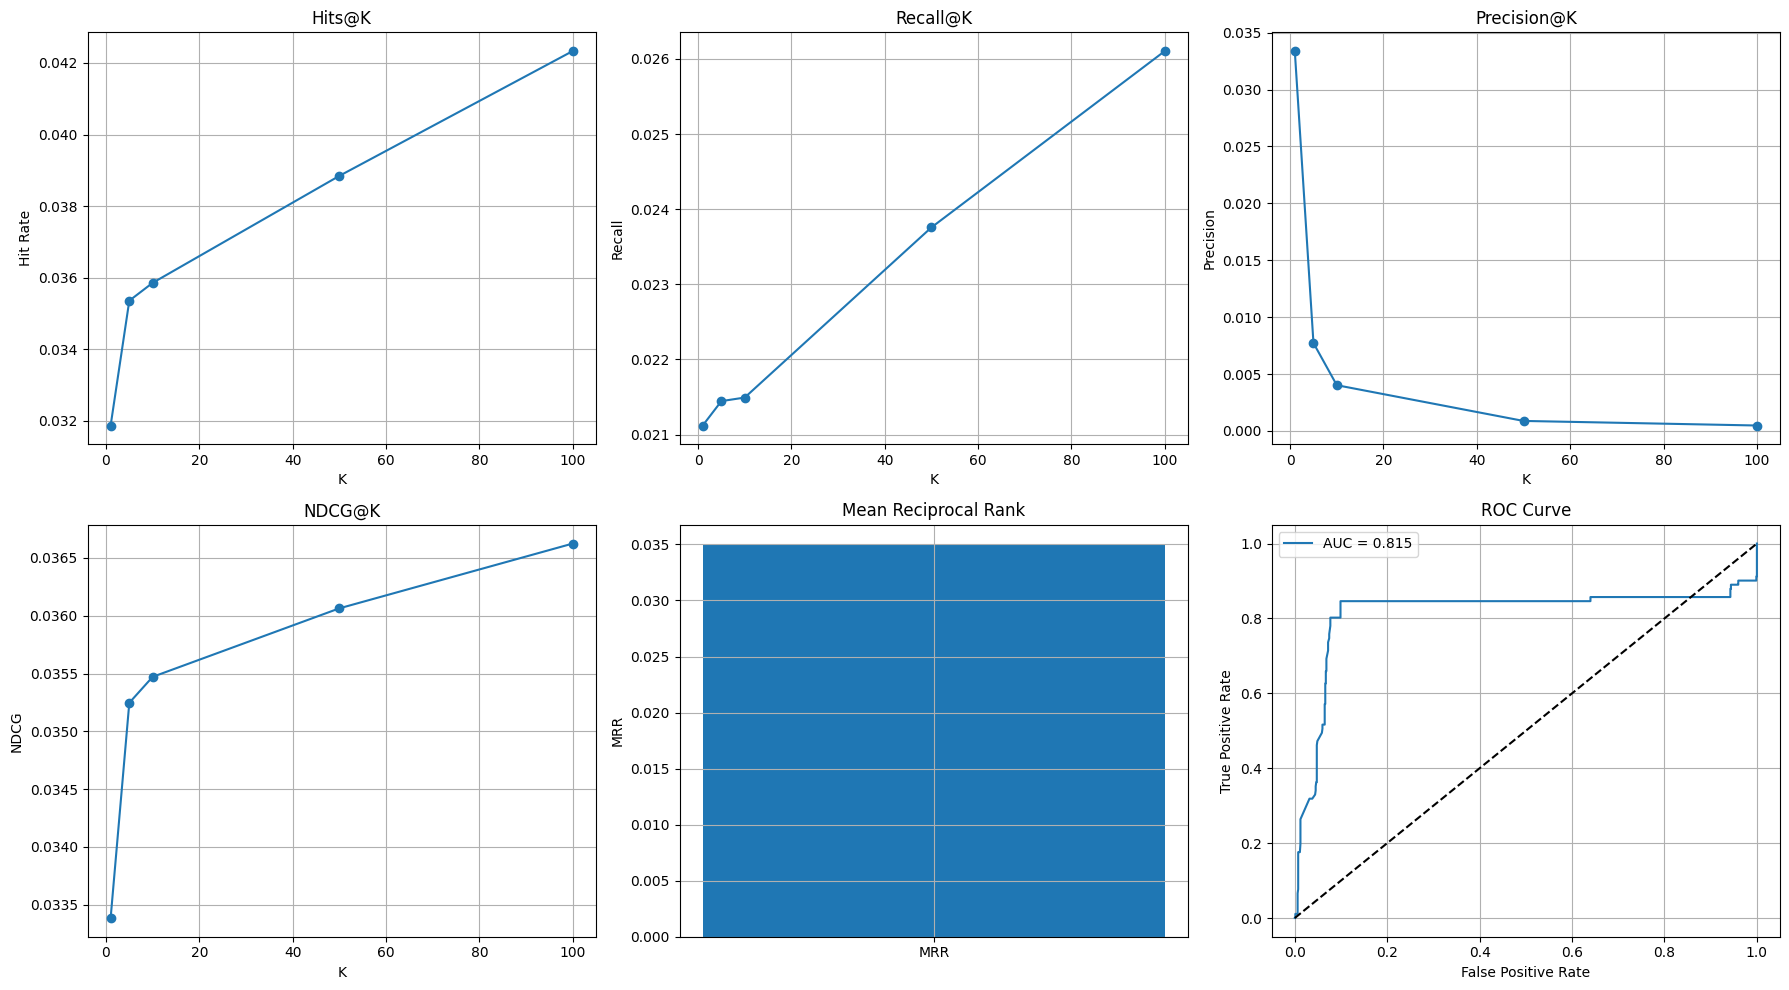


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully
Processed 400 users successfully
Processed 500 users successfully
Processed 600 users successfully
Processed 700 users successfully
Processed 800 users successfully
Processed 900 users successfully
Processed 1000 users successfully
Processed 1100 users successfully
Processed 1200 users successfully
Processed 1300 users successfully
Processed 1400 users successfully
Processed 1500 users successfully
Processed 1600 users successfully
Processed 1700 users successfully
Processed 1800 users successfully
Processed 1900 users successfully

Evaluation Results:
Total users evaluated: 2008
Users with successful evaluation: 1917

Hits@K:
Hits@1: 0.0244
Hits@5: 0.0324
Hits@10: 0.0359
Hits@50: 0.0388
Hits@100: 0.0423

Recall@K:
Recall@1: 0.0169
Recall@5: 0.0195
Recall@10: 0.02

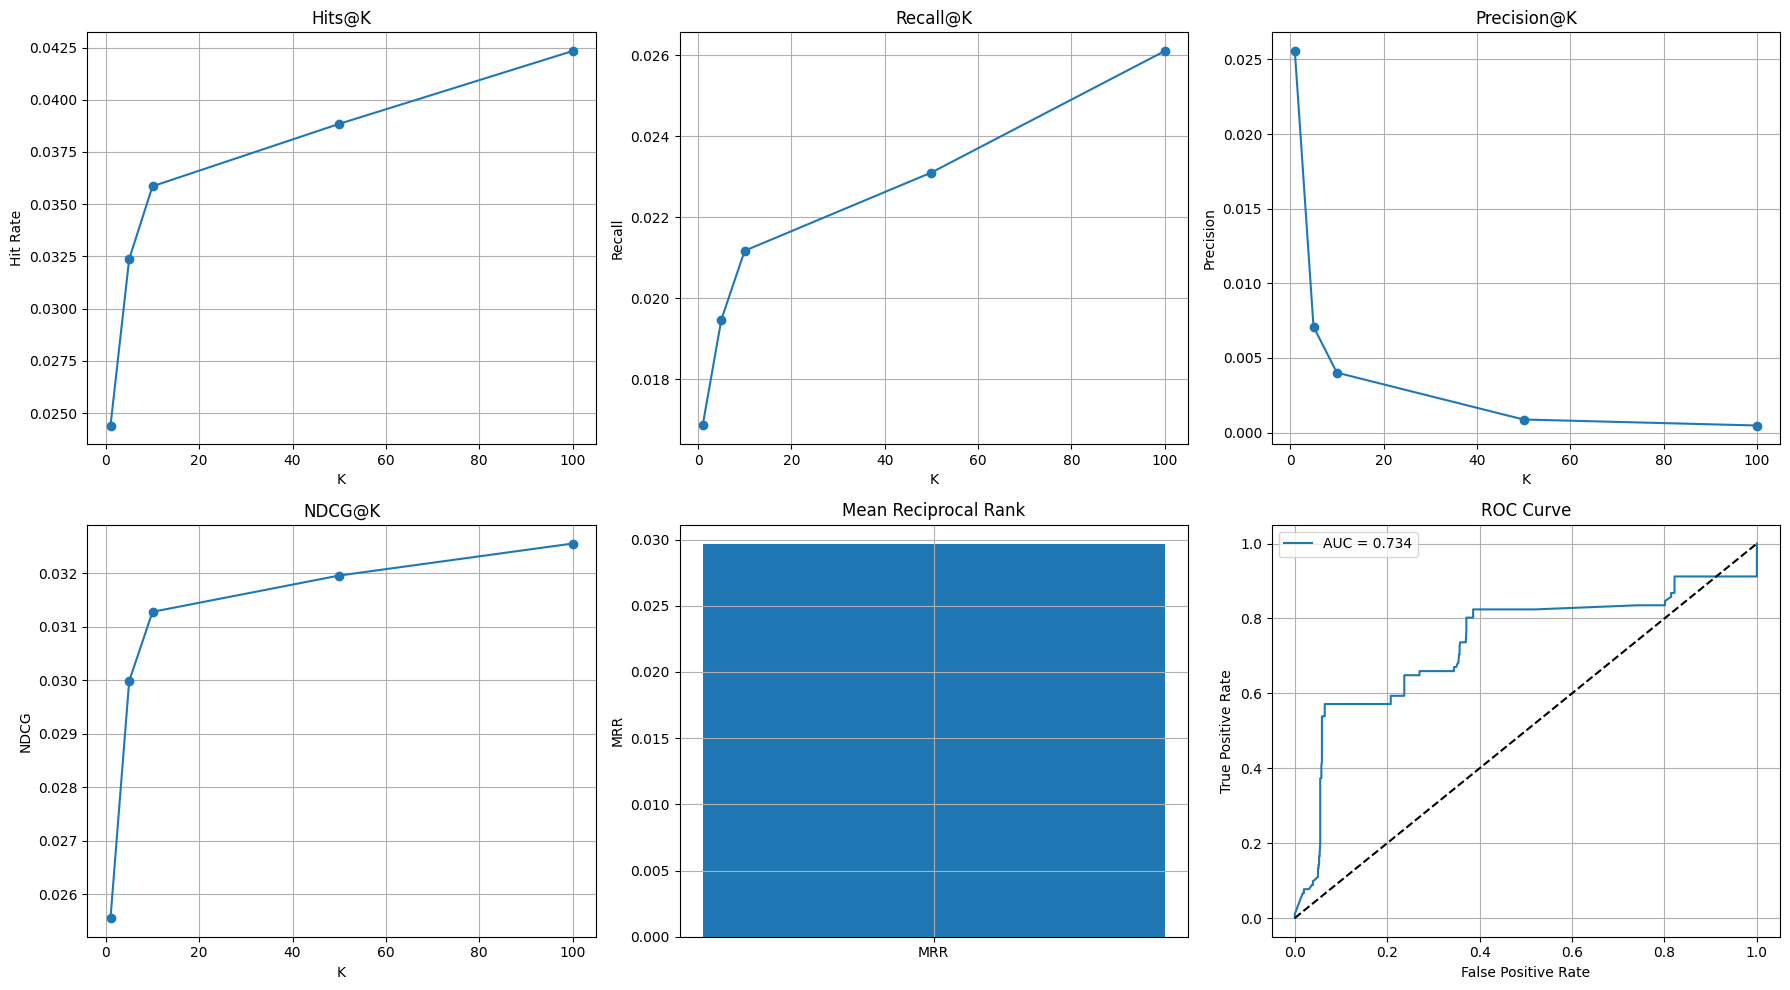


Comparison of Integrated Pipelines:
Weather Model MRR: 0.0350
No-Weather Model MRR: 0.0296
Weather features improve MRR by 18.10%

Evaluation pipeline complete!


In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from catboost import CatBoostClassifier, Pool
import joblib
import math

# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')
print(interactions_df.isnull().sum())

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'indoor_outdoor_preference': 'user_weather_preference',
    'joinedAt': 'signup_date'
}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)

def safe_id_convert(x):
    if x is None:
        return "unknown"
    if isinstance(x, float):
        if math.isnan(x):
            return "unknown"
        else:
            return str(int(x))
    try:
        return str(int(float(x)))
    except Exception:
        return "unknown"

# Apply safe conversion
users_df["user_id"] = users_df["user_id"].apply(safe_id_convert)
events_df["event_id"] = events_df["event_id"].apply(safe_id_convert)
interactions_df["user_id"] = interactions_df["user_id"].apply(safe_id_convert)
interactions_df["event_id"] = interactions_df["event_id"].apply(safe_id_convert)

# Remove rows with unknown IDs to avoid mismatches
users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

# Verify conversion
print("Sample user_id in interactions data after conversion:", interactions_df["user_id"].head().tolist())
print("Sample user_id in users data after conversion:", users_df["user_id"].head().tolist())

# Print the first few user IDs from each dataset to compare
print("\nFirst 10 user IDs in interactions_df:", sorted(list(interactions_df["user_id"].unique()))[:10])
print("First 10 user IDs in users_df:", sorted(list(users_df["user_id"].unique()))[:10])

# Check intersection properly
common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
print(f"Number of common users: {len(common_users)}")
print("First 10 common user IDs:", sorted(list(common_users))[:10])

# Filter interactions to only include users that exist in the users dataset
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
print(f"Filtered interactions with valid users: {len(interactions_df)}")

# Check intersection of event IDs
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
print(f"Number of common events: {len(common_events)}")
print("First 10 common event IDs:", sorted(list(common_events))[:10])

# Filter interactions to only include events that exist in the events dataset
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]
print(f"Filtered interactions with valid events: {len(interactions_df)}")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# Define features for ranking models
NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city', 
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests']

# Print data info
print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

# Split data for evaluation
test_interactions = interactions_df.sample(frac=0.2, random_state=42)
print(f"Test interactions: {len(test_interactions)}")
# --- Helper functions ---

def get_user_embeddings(query_model, user_ids):
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    if batch_users.empty:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    return query_model(batch_input).numpy()

def get_event_embeddings(candidate_model, events_data=None):
    if events_data is None:
        events_data = events_df.copy()
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    event_ids = []
    event_embeddings = []
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    return np.vstack(event_embeddings), event_ids

def build_faiss_index(embeddings):
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    return index

# --- Evaluation pipeline ---

def integrated_retrieval_ranking_pipeline(query_model, candidate_model, ranking_model, test_interactions, feature_list, k_retrieval=100, max_k=100):
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    event_ids = [eid.decode('utf-8') if isinstance(eid, bytes) else str(eid) for eid in event_ids_bytes]
    
    faiss_index = build_faiss_index(event_embeddings)
    
    hits_at_k = {k: 0 for k in [1, 5, 10, 50, 100]}
    ndcg_at_k = {k: [] for k in [1, 5, 10, 50, 100]}
    recall_at_k = {k: [] for k in [1, 5, 10, 50, 100]}
    precision_at_k = {k: [] for k in [1, 5, 10, 50, 100]}
    mrr = []
    # Initialize counters
    total_users = 0
    successful_users = 0
    all_scores = []
    all_labels = []

      

    user_groups = test_interactions.groupby('user_id')
    
    for user_id, group in user_groups:
        try:
            total_users += 1
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            if not attended_events:
                continue
            
            user_embedding = get_user_embeddings(query_model, [user_id])
            if user_embedding is None or len(user_embedding) == 0:
                continue
            
            faiss.normalize_L2(user_embedding)
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_indices]
            
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            if retrieved_events_df.empty:
                continue
            
            user_data = users_df[users_df['user_id'] == user_id].iloc[0]
            
            ranking_data = []
            for _, event in retrieved_events_df.iterrows():
                row = {
                    'event_id': event['event_id'],
                    'event_type': event['event_type'],
                    'event_city': event['event_city'],
                    'attendance_rate': event['attendance_rate'],
                    'event_indoor_capability': event['event_indoor_capability'],
                    'user_city': user_data['user_city'],
                    'age': user_data['age'],
                    'user_interests': user_data['user_interests']
                }
                if 'weather_condition' in feature_list:
                    row['weather_condition'] = event['weather_condition']
                    row['temperature'] = event['temperature']
                    row['user_weather_preference'] = user_data['user_weather_preference']
                
                matching_interaction = interactions_df[
                    (interactions_df['user_id'] == user_id) & 
                    (interactions_df['event_id'] == event['event_id'])
                ]
                if not matching_interaction.empty:
                    row['interaction_distance_to_event'] = matching_interaction['interaction_distance_to_event'].iloc[0]
                else:
                    row['interaction_distance_to_event'] = interactions_df['interaction_distance_to_event'].mean()
                
                ranking_data.append(row)
            
            ranking_df = pd.DataFrame(ranking_data)
            for feat in feature_list:
                if feat not in ranking_df.columns:
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'user_weather_preference', 'weather_condition']:
                        ranking_df[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate']:
                        ranking_df[feat] = 0.0
                    elif feat == 'age':
                        ranking_df[feat] = 30
                    elif feat == 'event_indoor_capability':
                        ranking_df[feat] = True
            
            text_cols = ["title", "user_interests"]
            ranking_features = ranking_df[feature_list].drop(columns=[c for c in text_cols if c in ranking_df.columns])
            
            for col in ranking_features.columns:
                if ranking_features[col].dtype == 'object':
                    ranking_features[col] = ranking_features[col].fillna('unknown')
                elif ranking_features[col].dtype in ['float64', 'float32']:
                    ranking_features[col] = ranking_features[col].fillna(0.0)
                elif ranking_features[col].dtype in ['int64', 'int32']:
                    ranking_features[col] = ranking_features[col].fillna(0)
                elif ranking_features[col].dtype == 'bool':
                    ranking_features[col] = ranking_features[col].fillna(False)
            
            cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
            ranking_pool = Pool(data=ranking_features, cat_features=cat_features)
            
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            ranked_results = pd.DataFrame({'event_id': ranking_df['event_id'], 'ranking_score': ranking_scores})
            ranked_results.sort_values('ranking_score', ascending=False, inplace=True)
            final_recommendation_ids = ranked_results['event_id'].tolist()[:max_k]
            
            # Calculate metrics for each K
            for k in hits_at_k.keys():
                if k > len(final_recommendation_ids):
                    continue
                top_k = set(final_recommendation_ids[:k])
                hits = len(top_k.intersection(attended_events))
                hits_at_k[k] += 1 if hits > 0 else 0
                recall_at_k[k].append(hits / len(attended_events))
                precision_at_k[k].append(hits / k)
                
                relevance = [1 if eid in attended_events else 0 for eid in final_recommendation_ids[:k]]
                dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
                ideal_relevance = sorted(relevance, reverse=True)
                idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
                ndcg = dcg / idcg if idcg > 0 else 0
                ndcg_at_k[k].append(ndcg)
            
            # MRR
            mrr_score = 0
            for i, eid in enumerate(final_recommendation_ids):
                if eid in attended_events:
                    mrr_score = 1.0 / (i + 1)
                    break
            mrr.append(mrr_score)
            
            # For precision-recall and ROC
            for eid in attended_events:
                if eid in ranked_results['event_id'].values:
                    idx = ranked_results[ranked_results['event_id'] == eid].index[0]
                    score = ranked_results.loc[idx, 'ranking_score']
                    all_scores.append(score)
                    all_labels.append(1)
                    # Add negative samples
                    negs = [e for e in ranked_results['event_id'] if e not in attended_events][:9]
                    for neg in negs:
                        neg_idx = ranked_results[ranked_results['event_id'] == neg].index[0]
                        all_scores.append(ranked_results.loc[neg_idx, 'ranking_score'])
                        all_labels.append(0)
            
            successful_users += 1
            if successful_users % 100 == 0:
                print(f"Processed {successful_users} users successfully")
            
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    
    # Aggregate metrics
    hits_at_k = {k: hits / total_users for k, hits in hits_at_k.items()}
    recall_at_k = {k: np.mean(vals) if vals else 0 for k, vals in recall_at_k.items()}
    precision_at_k = {k: np.mean(vals) if vals else 0 for k, vals in precision_at_k.items()}
    ndcg_at_k = {k: np.mean(vals) if vals else 0 for k, vals in ndcg_at_k.items()}
    mrr_avg = np.mean(mrr) if mrr else 0
    
    print("\nEvaluation Results:")
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {successful_users}")
    
    print("\nHits@K:")
    for k, v in hits_at_k.items():
        print(f"Hits@{k}: {v:.4f}")
    
    print("\nRecall@K:")
    for k, v in recall_at_k.items():
        print(f"Recall@{k}: {v:.4f}")
    
    print("\nPrecision@K:")
    for k, v in precision_at_k.items():
        print(f"Precision@{k}: {v:.4f}")
    
    print("\nNDCG@K:")
    for k, v in ndcg_at_k.items():
        print(f"NDCG@{k}: {v:.4f}")
    
    print(f"\nMRR: {mrr_avg:.4f}")
    
    if all_scores:
        ap = average_precision_score(all_labels, all_scores)
        fpr, tpr, _ = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        print(f"Average Precision: {ap:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        ap = None
        roc_auc = None
    
    # Plot metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    axes[0, 0].plot(list(hits_at_k.keys()), list(hits_at_k.values()), marker='o')
    axes[0, 0].set_title('Hits@K')
    axes[0, 0].set_xlabel('K')
    axes[0, 0].set_ylabel('Hit Rate')
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o')
    axes[0, 1].set_title('Recall@K')
    axes[0, 1].set_xlabel('K')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].grid(True)
    
    axes[0, 2].plot(list(precision_at_k.keys()), list(precision_at_k.values()), marker='o')
    axes[0, 2].set_title('Precision@K')
    axes[0, 2].set_xlabel('K')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].grid(True)
    
    axes[1, 0].plot(list(ndcg_at_k.keys()), list(ndcg_at_k.values()), marker='o')
    axes[1, 0].set_title('NDCG@K')
    axes[1, 0].set_xlabel('K')
    axes[1, 0].set_ylabel('NDCG')
    axes[1, 0].grid(True)
    
    axes[1, 1].bar(['MRR'], [mrr_avg])
    axes[1, 1].set_title('Mean Reciprocal Rank')
    axes[1, 1].set_ylabel('MRR')
    axes[1, 1].grid(True)
    
    if all_scores:
        axes[1, 2].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        axes[1, 2].plot([0, 1], [0, 1], 'k--')
        axes[1, 2].set_title('ROC Curve')
        axes[1, 2].set_xlabel('False Positive Rate')
        axes[1, 2].set_ylabel('True Positive Rate')
        axes[1, 2].legend()
        axes[1, 2].grid(True)
    else:
        axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('integrated_pipeline_evaluation.png')
    plt.show()
    
    return {
        "hits_at_k": hits_at_k,
        "recall_at_k": recall_at_k,
        "precision_at_k": precision_at_k,
        "ndcg_at_k": ndcg_at_k,
        "mrr": mrr_avg,
        "average_precision": ap,
        "roc_auc": roc_auc,
        "total_users": total_users,
        "successful_users": successful_users
    }

def main():
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Wednesday, May 14, 2025, 12:56 AM CEST")
    print("=" * 50)
    
    # Load models
    query_model = model.query_model
    candidate_model = model.item_model

    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/no_weather_ranking_model_2.pkl")

    # Use test_interactions as defined earlier
    # Evaluate weather model pipeline
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=100,
        max_k=100
    )
    
    # Evaluate no-weather model pipeline
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        no_weather_model,
        test_interactions,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=100,
        max_k=100
    )
    
    # Compare results
    print("\nComparison of Integrated Pipelines:")
    print(f"Weather Model MRR: {weather_results['mrr']:.4f}")
    print(f"No-Weather Model MRR: {no_weather_results['mrr']:.4f}")
    
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        diff = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")

if __name__ == "__main__":
    main()


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from catboost import CatBoostClassifier, Pool
import joblib
import math
from datetime import datetime

# --- Data loading and renaming (as in your paste.txt) ---


# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')
print(interactions_df.isnull().sum())

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'indoor_outdoor_preference': 'user_weather_preference',
    'joinedAt': 'signup_date'
}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)

def safe_id_convert(x):
    if x is None:
        return "unknown"
    if isinstance(x, float):
        if math.isnan(x):
            return "unknown"
        else:
            return str(int(x))
    try:
        return str(int(float(x)))
    except Exception:
        return "unknown"

# Apply safe conversion
users_df["user_id"] = users_df["user_id"].apply(safe_id_convert)
events_df["event_id"] = events_df["event_id"].apply(safe_id_convert)
interactions_df["user_id"] = interactions_df["user_id"].apply(safe_id_convert)
interactions_df["event_id"] = interactions_df["event_id"].apply(safe_id_convert)

# Remove rows with unknown IDs to avoid mismatches
users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

# Verify conversion
print("Sample user_id in interactions data after conversion:", interactions_df["user_id"].head().tolist())
print("Sample user_id in users data after conversion:", users_df["user_id"].head().tolist())

# Print the first few user IDs from each dataset to compare
print("\nFirst 10 user IDs in interactions_df:", sorted(list(interactions_df["user_id"].unique()))[:10])
print("First 10 user IDs in users_df:", sorted(list(users_df["user_id"].unique()))[:10])

# Check intersection properly
common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
print(f"Number of common users: {len(common_users)}")
print("First 10 common user IDs:", sorted(list(common_users))[:10])

# Filter interactions to only include users that exist in the users dataset
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
print(f"Filtered interactions with valid users: {len(interactions_df)}")

# Check intersection of event IDs
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
print(f"Number of common events: {len(common_events)}")
print("First 10 common event IDs:", sorted(list(common_events))[:10])

# Filter interactions to only include events that exist in the events dataset
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]
print(f"Filtered interactions with valid events: {len(interactions_df)}")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# Define features for ranking models
NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city', 
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests']

# Print data info
print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

# Split data for evaluation
test_interactions = interactions_df.sample(frac=1.0, random_state=42)
print(f"Test interactions: {len(test_interactions)}")

# --- Helper functions ---

def get_user_embeddings(query_model, user_ids):
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    if batch_users.empty:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    return query_model(batch_input).numpy()

def get_event_embeddings(candidate_model, events_data=None):
    if events_data is None:
        events_data = events_df.copy()
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    event_ids = []
    event_embeddings = []
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    return np.vstack(event_embeddings), event_ids

def build_faiss_index(embeddings):
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    return index

# --- Robust weather match scoring ---

def compute_weather_match(user_weather, event_weather, user_pref, event_type_val, user_temp, event_temp, user_precip, event_precip):
    score = 0.0
    # Weather group match (0.4)
    if user_weather == event_weather:
        score += 0.4
    elif (user_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy'] and event_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy']):
        score += 0.2
    elif (user_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm'] and event_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm']):
        score += 0.2
    # Indoor/outdoor preference match (0.3)
    if user_pref == 'any':
        score += 0.3
    elif (user_pref == 'indoor' and event_type_val in ['Indoor', 'Hybrid']) or (user_pref == 'outdoor' and event_type_val in ['Outdoor', 'Hybrid']):
        score += 0.3
    # Temperature and precipitation compatibility (0.3)
    temp_diff = abs(user_temp - event_temp)
    precip_diff = abs(user_precip - event_precip)
    temp_score = max(0, 1 - (temp_diff / 20))
    precip_score = max(0, 1 - (precip_diff / 10))
    score += 0.3 * (0.6 * temp_score + 0.4 * precip_score)
    return round(score, 2)

def post_retrieval_filtering(candidates_df, user_context, filter_weather=True, filter_time=True, max_distance_km=200, weather_score_threshold=0.2):
    if filter_time and 'start_time' in candidates_df.columns:
        now = pd.Timestamp.now(tz='UTC')
        candidates_df = candidates_df[
            pd.to_datetime(candidates_df['start_time'], utc=True) > now
        ]
    # Location proximity filtering
    if 'interaction_distance_to_event' in candidates_df.columns:
        candidates_df = candidates_df[candidates_df['interaction_distance_to_event'] <= max_distance_km]
    # Weather filtering
    if filter_weather:
        scores = []
        for _, event in candidates_df.iterrows():
            score = compute_weather_match(
                user_context.get('user_weather_condition', 'any'),
                event.get('weather_condition', 'unknown'),
                user_context.get('user_weather_preference', 'any'),
                event.get('event_type', 'unknown'),
                user_context.get('user_temperature', 20),
                event.get('temperature', 20),
                user_context.get('user_precipitation', 0),
                event.get('precipitation_sum', 0)
            )
            scores.append(score)
        candidates_df = candidates_df.assign(weather_match_score=scores)
        candidates_df = candidates_df[candidates_df['weather_match_score'] >= weather_score_threshold]
    return candidates_df

# --- Main retrieval-ranking pipeline with filtering ---

def integrated_retrieval_ranking_pipeline(
    query_model, candidate_model, ranking_model, test_interactions, feature_list, 
    k_retrieval=100, max_k=100, filter_weather=True, filter_time=True, max_distance_km=30, weather_score_threshold=0.5
):
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    event_ids = [eid.decode('utf-8') if isinstance(eid, bytes) else str(eid) for eid in event_ids_bytes]
    faiss_index = build_faiss_index(event_embeddings)
    hits_at_k = {k: 0 for k in [1, 5, 10, 50, 100]}
    ndcg_at_k = {k: [] for k in [1, 5, 10, 50, 100]}
    recall_at_k = {k: [] for k in [1, 5, 10, 50, 100]}
    precision_at_k = {k: [] for k in [1, 5, 10, 50, 100]}
    mrr = []
    total_users = 0
    successful_users = 0
    all_scores = []
    all_labels = []
    user_groups = test_interactions.groupby('user_id')
    for user_id, group in user_groups:
        try:
            total_users += 1
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            if not attended_events:
                continue
            user_embedding = get_user_embeddings(query_model, [user_id])
            if user_embedding is None or len(user_embedding) == 0:
                continue
            faiss.normalize_L2(user_embedding)
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_indices]
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            if retrieved_events_df.empty:
                continue
            user_data = users_df[users_df['user_id'] == user_id].iloc[0]
            # Add contextual columns from interactions_df if available
            merged = pd.merge(
                retrieved_events_df,
                interactions_df[interactions_df['user_id'] == user_id][['event_id', 'interaction_distance_to_event']],
                on='event_id', how='left'
            )
            # Fill missing distances with mean
            merged['interaction_distance_to_event'] = merged['interaction_distance_to_event'].fillna(interactions_df['interaction_distance_to_event'].mean())
            # Post-retrieval filtering
            user_context = {
                'user_weather_condition': group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'any',
                'user_weather_preference': user_data.get('user_weather_preference', 'any'),
                'user_temperature': group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20,
                'user_precipitation': group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0,
                'user_interests': user_data['user_interests'],
                'user_city': user_data['user_city'],
                'age': user_data['age']
            }
            filtered_candidates = post_retrieval_filtering(
                merged, user_context,
                filter_weather=filter_weather,
                filter_time=filter_time,
                max_distance_km=max_distance_km,
                weather_score_threshold=weather_score_threshold
            )
            if filtered_candidates.empty:
                continue
            ranking_data = []
            for _, event in filtered_candidates.iterrows():
                row = {
                    'event_id': event['event_id'],
                    'event_type': event['event_type'],
                    'event_city': event['event_city'],
                    'attendance_rate': event['attendance_rate'],
                    'event_indoor_capability': event['event_indoor_capability'],
                    'user_city': user_data['user_city'],
                    'age': user_data['age'],
                    'user_interests': user_data['user_interests']
                }
                if 'weather_condition' in feature_list:
                    row['weather_condition'] = event['weather_condition']
                    row['temperature'] = event['temperature']
                    row['user_weather_preference'] = user_data['user_weather_preference']
                row['interaction_distance_to_event'] = event['interaction_distance_to_event']
                ranking_data.append(row)
            ranking_df = pd.DataFrame(ranking_data)
            for feat in feature_list:
                if feat not in ranking_df.columns:
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'user_weather_preference', 'weather_condition']:
                        ranking_df[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate']:
                        ranking_df[feat] = 0.0
                    elif feat == 'age':
                        ranking_df[feat] = 30
                    elif feat == 'event_indoor_capability':
                        ranking_df[feat] = True
            text_cols = ["title", "user_interests"]
            ranking_features = ranking_df[feature_list].drop(columns=[c for c in text_cols if c in ranking_df.columns])
            for col in ranking_features.columns:
                if ranking_features[col].dtype == 'object':
                    ranking_features[col] = ranking_features[col].fillna('unknown')
                elif ranking_features[col].dtype in ['float64', 'float32']:
                    ranking_features[col] = ranking_features[col].fillna(0.0)
                elif ranking_features[col].dtype in ['int64', 'int32']:
                    ranking_features[col] = ranking_features[col].fillna(0)
                elif ranking_features[col].dtype == 'bool':
                    ranking_features[col] = ranking_features[col].fillna(False)
            cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
            ranking_pool = Pool(data=ranking_features, cat_features=cat_features)
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            ranked_results = pd.DataFrame({'event_id': ranking_df['event_id'], 'ranking_score': ranking_scores})
            ranked_results.sort_values('ranking_score', ascending=False, inplace=True)
            final_recommendation_ids = ranked_results['event_id'].tolist()[:max_k]
            # Calculate metrics for each K
            for k in hits_at_k.keys():
                if k > len(final_recommendation_ids):
                    continue
                top_k = set(final_recommendation_ids[:k])
                hits = len(top_k.intersection(attended_events))
                hits_at_k[k] += 1 if hits > 0 else 0
                recall_at_k[k].append(hits / len(attended_events))
                precision_at_k[k].append(hits / k)
                relevance = [1 if eid in attended_events else 0 for eid in final_recommendation_ids[:k]]
                dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
                ideal_relevance = sorted(relevance, reverse=True)
                idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
                ndcg = dcg / idcg if idcg > 0 else 0
                ndcg_at_k[k].append(ndcg)
            # MRR
            mrr_score = 0
            for i, eid in enumerate(final_recommendation_ids):
                if eid in attended_events:
                    mrr_score = 1.0 / (i + 1)
                    break
            mrr.append(mrr_score)
            # For precision-recall and ROC
            for eid in attended_events:
                if eid in ranked_results['event_id'].values:
                    idx = ranked_results[ranked_results['event_id'] == eid].index[0]
                    score = ranked_results.loc[idx, 'ranking_score']
                    all_scores.append(score)
                    all_labels.append(1)
                    negs = [e for e in ranked_results['event_id'] if e not in attended_events][:9]
                    for neg in negs:
                        neg_idx = ranked_results[ranked_results['event_id'] == neg].index[0]
                        all_scores.append(ranked_results.loc[neg_idx, 'ranking_score'])
                        all_labels.append(0)
            successful_users += 1
            if successful_users % 100 == 0:
                print(f"Processed {successful_users} users successfully")
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    hits_at_k = {k: hits / total_users for k, hits in hits_at_k.items()}
    recall_at_k = {k: np.mean(vals) if vals else 0 for k, vals in recall_at_k.items()}
    precision_at_k = {k: np.mean(vals) if vals else 0 for k, vals in precision_at_k.items()}
    ndcg_at_k = {k: np.mean(vals) if vals else 0 for k, vals in ndcg_at_k.items()}
    mrr_avg = np.mean(mrr) if mrr else 0
    print("\nEvaluation Results:")
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {successful_users}")
    print("\nHits@K:")
    for k, v in hits_at_k.items():
        print(f"Hits@{k}: {v:.4f}")
    print("\nRecall@K:")
    for k, v in recall_at_k.items():
        print(f"Recall@{k}: {v:.4f}")
    print("\nPrecision@K:")
    for k, v in precision_at_k.items():
        print(f"Precision@{k}: {v:.4f}")
    print("\nNDCG@K:")
    for k, v in ndcg_at_k.items():
        print(f"NDCG@{k}: {v:.4f}")
    print(f"\nMRR: {mrr_avg:.4f}")
    if all_scores:
        ap = average_precision_score(all_labels, all_scores)
        fpr, tpr, _ = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        print(f"Average Precision: {ap:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        ap = None
        roc_auc = None
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes[0, 0].plot(list(hits_at_k.keys()), list(hits_at_k.values()), marker='o')
    axes[0, 0].set_title('Hits@K')
    axes[0, 0].set_xlabel('K')
    axes[0, 0].set_ylabel('Hit Rate')
    axes[0, 0].grid(True)
    axes[0, 1].plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o')
    axes[0, 1].set_title('Recall@K')
    axes[0, 1].set_xlabel('K')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].grid(True)
    axes[0, 2].plot(list(precision_at_k.keys()), list(precision_at_k.values()), marker='o')
    axes[0, 2].set_title('Precision@K')
    axes[0, 2].set_xlabel('K')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].grid(True)
    axes[1, 0].plot(list(ndcg_at_k.keys()), list(ndcg_at_k.values()), marker='o')
    axes[1, 0].set_title('NDCG@K')
    axes[1, 0].set_xlabel('K')
    axes[1, 0].set_ylabel('NDCG')
    axes[1, 0].grid(True)
    axes[1, 1].bar(['MRR'], [mrr_avg])
    axes[1, 1].set_title('Mean Reciprocal Rank')
    axes[1, 1].set_ylabel('MRR')
    axes[1, 1].grid(True)
    if all_scores:
        axes[1, 2].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        axes[1, 2].plot([0, 1], [0, 1], 'k--')
        axes[1, 2].set_title('ROC Curve')
        axes[1, 2].set_xlabel('False Positive Rate')
        axes[1, 2].set_ylabel('True Positive Rate')
        axes[1, 2].legend()
        axes[1, 2].grid(True)
    else:
        axes[1, 2].axis('off')
    plt.tight_layout()
    plt.savefig('integrated_pipeline_evaluation.png')
    plt.show()
        # --- Final summary plot with all metrics together ---
    plt.figure(figsize=(10, 7))
    k_vals = list(hits_at_k.keys())
    plt.plot(k_vals, [hits_at_k[k] for k in k_vals], marker='o', label='Hits@K')
    plt.plot(k_vals, [recall_at_k[k] for k in k_vals], marker='o', label='Recall@K')
    plt.plot(k_vals, [precision_at_k[k] for k in k_vals], marker='o', label='Precision@K')
    plt.plot(k_vals, [ndcg_at_k[k] for k in k_vals], marker='o', label='NDCG@K')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.title('Summary of Ranking Metrics')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('summary_metrics_plot.png')
    plt.show()

    return {
        "hits_at_k": hits_at_k,
        "recall_at_k": recall_at_k,
        "precision_at_k": precision_at_k,
        "ndcg_at_k": ndcg_at_k,
        "mrr": mrr_avg,
        "average_precision": ap,
        "roc_auc": roc_auc,
        "total_users": total_users,
        "successful_users": successful_users
    }

def main():
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Wednesday, May 14, 2025, 1:03 PM CEST")
    print("=" * 50)
    # Load models (replace with your actual model loading code)
    query_model =model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/notebooks/no_weather_ranking_model_2.pkl")
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=True,
        filter_time=False
    )
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        no_weather_model,
        test_interactions,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,  # No weather filtering
        filter_time=False
    )
    print("\nComparison of Integrated Pipelines:")
    print(f"Weather Model MRR: {weather_results['mrr']:.4f}")
    print(f"No-Weather Model MRR: {no_weather_results['mrr']:.4f}")
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        diff = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {diff:.2f}%")
    print("\nEvaluation pipeline complete!")

if __name__ == "__main__":
    main()


Unnamed: 0                 0
user_id                    0
event_id                   0
interaction_type           0
distance_to_event          0
interaction_label          0
event_weather_condition    0
event_temperature          0
event_precipitation_sum    0
user_weather_condition     0
user_temperature           0
user_precipitation         0
dtype: int64
Sample user_id in interactions data after conversion: ['3468617687', '487910947', '2769572227', '2974942354', '3468617687']
Sample user_id in users data after conversion: ['3197468391', '1091720544', '3341263967', '1363661070', '3104149470']

First 10 user IDs in interactions_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
First 10 user IDs in users_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
Number of common users: 5315
First 10 common 

In [3]:

# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/notebooks/test_interactions_data.csv')

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'indoor_outdoor_preference': 'user_weather_preference',
    'joinedAt': 'signup_date'
}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)


# Merge user/event features into interactions
interactions_df = interactions_df.merge(users_df, on="user_id", how="inner")
interactions_df = interactions_df.merge(events_df, on="event_id", how="inner")

NameError: name 'pd' is not defined

In [24]:
def integrated_retrieval_ranking_pipeline(query_model, candidate_model, ranking_model, test_df, item_df, events_df, k_retrieval=100, k_final=10, use_weather=False):
    """
    Integrated retrieval-ranking pipeline that:
    1. Retrieves top-k candidates using the retrieval model
    2. Re-ranks these candidates using the ranking model
    3. Evaluates the end-to-end performance
    
    Args:
        query_model: User tower of the retrieval model
        candidate_model: Item tower of the retrieval model
        ranking_model: CatBoost ranking model
        test_df: Test dataset with user-item interactions
        item_df: DataFrame with item features
        events_df: Complete events dataset with all features
        k_retrieval: Number of candidates to retrieve
        k_final: Number of final recommendations to evaluate
        use_weather: Whether to use weather features in ranking
    
    Returns:
        Dictionary with evaluation metrics
    """
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    
    # Prepare for retrieval
    item_ids = item_df["event_id"].tolist()
    print(f"Found {len(item_df)} unique items for evaluation")
    
    # Precompute item embeddings for retrieval
    print("Precomputing item embeddings...")
    item_embeddings = precompute_item_embeddings(candidate_model, item_df)
    
    # Build Faiss index
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings)
    
    # Metrics to track
    hits_at_k = {k: 0 for k in [1, 5, 10, 20, 50]}
    ndcg_at_k = {k: [] for k in [1, 5, 10, 20, 50]}
    mrr = []
    total_users = 0
    
    # Process each user
    for user_id, group in test_df.groupby('user_id'):
        total_users += 1
        
        # Get ground truth events the user actually interacted with
        ground_truth = set(group['event_id'].tolist())
        if not ground_truth:
            continue
            
        # Step 1: Retrieval - Get user embedding and retrieve candidates
        user_row = group.iloc[0]
        user_emb = get_user_embedding(query_model, user_row)
        distances, indices = faiss_index.search(user_emb, k_retrieval)
        retrieved_ids = [item_ids[i] for i in indices[0]]
        
        # Get full details of retrieved candidates for ranking
        retrieved_events = events_df[events_df['event_id'].isin(retrieved_ids)].copy()
        
        if len(retrieved_events) == 0:
            continue
            
        # Step 2: Prepare features for ranking
        # Add user features to each retrieved event
        for col in ['user_id', 'gender', 'age', 'indoor_outdoor_preference', 'user_interests']:
            if col in user_row:
                retrieved_events[col] = user_row[col]
        
        # Calculate distance to event (a common feature for ranking)
        retrieved_events['distance_to_event'] = retrieved_events.apply(
            lambda row: calculate_distance(
                user_row['lat'], user_row['lng'], 
                row['lat'], row['lng']
            ), axis=1
        )
        
        # Add interaction type placeholder (needed for model input)
        retrieved_events['interaction_type'] = 'unknown'
        
        # Select features based on whether we're using weather
        if use_weather:
            ranking_features = WEATHER_SELECTED_FEATURES.copy()
        else:
            ranking_features = NO_WEATHER_SELECTED_FEATURES.copy()
        
        # Remove label from features
        if 'interaction_label' in ranking_features:
            ranking_features.remove('interaction_label')
        
        # Ensure all required features are present
        for feat in ranking_features:
            if feat not in retrieved_events.columns and feat != 'interaction_label':
                retrieved_events[feat] = 'unknown'  # Placeholder for missing features
        
        # Step 3: Ranking - Apply ranking model to retrieved candidates
        ranking_model_input = retrieved_events[ranking_features]
        
        # Handle text columns
        text_columns = ["title", "user_interests"]
        ranking_model_input = ranking_model_input.drop(columns=[col for col in text_columns if col in ranking_model_input.columns])
        
        # Identify categorical features
        cat_features = ranking_model_input.select_dtypes(include=["object", "bool"]).columns.tolist()
        
        # Create CatBoost Pool
        ranking_pool = Pool(ranking_model_input, cat_features=cat_features)
        
        # Get ranking scores
        ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
        
        # Create DataFrame with IDs and scores
        ranked_results = pd.DataFrame({
            'event_id': retrieved_events['event_id'],
            'ranking_score': ranking_scores
        })
        
        # Sort by ranking score
        final_recommendations = ranked_results.sort_values('ranking_score', ascending=False)
        final_recommendation_ids = final_recommendations['event_id'].tolist()[:k_final]
        
        # Step 4: Evaluate the final ranked list
        # Calculate Hits@K
        for k in hits_at_k.keys():
            if k <= len(final_recommendation_ids):
                top_k_recommendations = set(final_recommendation_ids[:k])
                if any(event_id in top_k_recommendations for event_id in ground_truth):
                    hits_at_k[k] += 1
        
        # Calculate NDCG@K
        for k in ndcg_at_k.keys():
            if k <= len(final_recommendation_ids):
                # Create relevance array (1 if in ground truth, 0 otherwise)
                relevance = [1 if event_id in ground_truth else 0 for event_id in final_recommendation_ids[:k]]
                
                # Calculate DCG
                dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
                
                # Calculate ideal DCG (all relevant items at the top)
                ideal_relevance = sorted(relevance, reverse=True)
                idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
                
                # Calculate NDCG
                ndcg = dcg / idcg if idcg > 0 else 0
                ndcg_at_k[k].append(ndcg)
        
        # Calculate MRR (Mean Reciprocal Rank)
        for i, event_id in enumerate(final_recommendation_ids):
            if event_id in ground_truth:
                mrr.append(1.0 / (i + 1))
                break
        else:
            mrr.append(0)
    
    # Calculate final metrics
    hits_at_k_normalized = {k: hits / total_users for k, hits in hits_at_k.items()} if total_users > 0 else hits_at_k
    ndcg_at_k_avg = {k: sum(scores) / len(scores) if scores else 0 for k, scores in ndcg_at_k.items()}
    mrr_avg = sum(mrr) / len(mrr) if mrr else 0
    
    # Print results
    print("\nIntegrated Retrieval-Ranking Evaluation Results:")
    print(f"Total users evaluated: {total_users}")
    
    print("\nHits@K:")
    for k, hit_rate in hits_at_k_normalized.items():
        print(f"Hits@{k}: {hit_rate:.4f}")
    
    print("\nNDCG@K:")
    for k, ndcg in ndcg_at_k_avg.items():
        print(f"NDCG@{k}: {ndcg:.4f}")
    
    print(f"\nMRR: {mrr_avg:.4f}")
    
    # Plot metrics
    plt.figure(figsize=(15, 5))
    
    # Plot Hits@K
    plt.subplot(1, 3, 1)
    plt.plot(list(hits_at_k_normalized.keys()), list(hits_at_k_normalized.values()), marker='o')
    plt.title('Hits@K')
    plt.xlabel('K')
    plt.ylabel('Hit Rate')
    plt.grid(True)
    
    # Plot NDCG@K
    plt.subplot(1, 3, 2)
    plt.plot(list(ndcg_at_k_avg.keys()), list(ndcg_at_k_avg.values()), marker='o')
    plt.title('NDCG@K')
    plt.xlabel('K')
    plt.ylabel('NDCG')
    plt.grid(True)
    
    # Plot MRR
    plt.subplot(1, 3, 3)
    plt.bar(['MRR'], [mrr_avg])
    plt.title('Mean Reciprocal Rank')
    plt.ylabel('MRR')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('integrated_pipeline_evaluation.png')
    plt.show()
    
    return {
        "hits_at_k": hits_at_k_normalized,
        "ndcg_at_k": ndcg_at_k_avg,
        "mrr": mrr_avg
    }

# Helper function to calculate distance
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points in km using haversine formula"""
    from math import radians, cos, sin, asin, sqrt
    
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    
    return c * r


def main():
    """Main function to run the complete evaluation pipeline"""
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Monday, May 12, 2025, 11:08 AM CEST")
    print("=" * 50)
    
    # First evaluate individual components
    print("\n1. Evaluating Individual Components")
    
    # Evaluate retrieval model
    retrieval_results = evaluate_retrieval_pipeline()
    
    # Evaluate ranking models
    ranking_results = evaluate_ranking_pipeline()
    
    # Then evaluate the integrated pipeline
    print("\n2. Evaluating Integrated Retrieval-Ranking Pipeline")
    
    # With weather features
    integrated_results_weather = integrated_retrieval_ranking_pipeline(
        query_model, 
        candidate_model, 
        weather_model,
        val_df, 
        item_df, 
        events_df,
        k_retrieval=100,
        k_final=10,
        use_weather=True
    )
    
    # Without weather features
    integrated_results_no_weather = integrated_retrieval_ranking_pipeline(
        query_model, 
        candidate_model, 
        no_weather_model,
        val_df, 
        item_df, 
        events_df,
        k_retrieval=100,
        k_final=10,
        use_weather=False
    )
    
    # Compare the results
    print("\nComparison of Integrated Pipelines:")
    print("Weather vs. No-Weather MRR:", 
          integrated_results_weather["mrr"], "vs.", 
          integrated_results_no_weather["mrr"])
    
    print("\nEvaluation pipeline complete!")
    return {
        "retrieval_results": retrieval_results,
        "ranking_results": ranking_results,
        "integrated_results_weather": integrated_results_weather,
        "integrated_results_no_weather": integrated_results_no_weather
    }


In [ ]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import faiss
from sklearn.metrics import roc_auc_score, average_precision_score
from typing import Dict, List, Tuple

from geopy.distance import geodesic


# Precompute item embeddings for efficient retrieval
def precompute_item_embeddings(candidate_model, item_df):
    """Generate embeddings for all items using the candidate model"""
    item_features = {
        "event_id": item_df["event_id"].values,
        "title": item_df["title"].values,
        "event_category": item_df["event_category"].values,
        "event_city": item_df["event_city"].values
    }
    
    # Generate embeddings
    item_embeddings = candidate_model(item_features).numpy()
    return item_embeddings, item_df["event_id"].tolist()

# Build Faiss index for fast retrieval
def build_faiss_index(item_embeddings):
    """Build a Faiss index for efficient similarity search"""
    # Normalize embeddings for cosine similarity
    faiss.normalize_L2(item_embeddings)
    
    # Create index
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    
    return index

# Retrieval stage
def retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=100):
    """Retrieve top-k candidates using the retrieval model"""
    # Normalize user embedding
    user_embedding_norm = user_embedding.copy()
    faiss.normalize_L2(user_embedding_norm)
    
    # Search for similar items
    distances, indices = faiss_index.search(user_embedding_norm, top_k)
    
    # Get candidate items with retrieval scores
    candidates = []
    for i, idx in enumerate(indices[0]):
        if idx < len(item_ids):
            item_id = item_ids[idx]
            score = float(distances[0][i])
            # Get full item data from events_df instead of item_df
            item_data = events_df[events_df["event_id"] == item_id]
            if not item_data.empty:
                candidates.append((item_id, score, item_data.iloc[0]))
    
    return candidates

# First, create the merged dataframe with all features
def create_merged_dataframe():
    """Create a merged dataframe containing all features from users, events, and interactions"""
    # Merge users and interactions on user_id
    print("creating merged dataframe")
    user_interactions = pd.merge(interactions_df, users_df, on='user_id', how='left')
    
    # Merge the above with events on event_id
    merged_df = pd.merge(user_interactions, events_df, on='event_id', how='left')
    
    print(f"Created merged dataframe with {len(merged_df)} rows and {len(merged_df.columns)} columns")
    
    # Force event_indoor_capability to string for CatBoost compatibility
    merged_df["event_indoor_capability"] = merged_df["event_indoor_capability"].astype(str)

    return merged_df

# Then modify the rank_candidates function to use this merged data
def create_dynamic_fallback_row(user_data, item_data, feature_names):
    """Create a fallback row dynamically matching feature_names."""
    fallback_row = {}

    for feature in feature_names:
        if feature == "user_id":
            fallback_row[feature] = user_data["user_id"]
        elif feature == "gender":
            fallback_row[feature] = user_data.get("gender", "unknown")
        elif feature == "user_city":
            fallback_row[feature] = user_data.get("user_city", "unknown")
        elif feature == "indoor_outdoor_preference":
            fallback_row[feature] = user_data.get("indoor_outdoor_preference", "any")
        elif feature == "user_interests":
            fallback_row[feature] = user_data.get("user_interests", "")
        elif feature == "interest_match":
            # Check if any user interest matches event category
            user_interests = user_data.get("user_interests", "").split(",")
            event_category = item_data.get("event_category", "").lower()
            fallback_row[feature] = int(any(interest.lower() in event_category for interest in user_interests if interest))
        elif feature == "event_id":
            fallback_row[feature] = item_data["event_id"]
        elif feature == "event_category":
            fallback_row[feature] = item_data["event_category"]
        elif feature == "event_city":
            fallback_row[feature] = item_data["event_city"]
        elif feature == "event_lat":
            fallback_row[feature] = item_data.get("event_lat", 0.0)
        elif feature == "event_lon":
            fallback_row[feature] = item_data.get("event_lon", 0.0)
        elif feature == "title":
            fallback_row[feature] = item_data.get("title", "")
        elif feature == "interaction_type":
            fallback_row[feature] = "maybe"  # Neutral default
        elif feature == "distance_to_event":
            # Calculate actual distance if coordinates are available
            user_lat = user_data.get("user_lat", 0.0)
            user_lon = user_data.get("user_lon", 0.0)
            event_lat = item_data.get("event_lat", 0.0)
            event_lon = item_data.get("event_lon", 0.0)
            if user_lat and user_lon and event_lat and event_lon:
                fallback_row[feature] = geodesic((user_lat, user_lon), (event_lat, event_lon)).km
            else:
                fallback_row[feature] = 0.0
        elif feature == "duration":
            fallback_row[feature] = item_data.get("duration", 120.0)  # Default: 2 hours
        elif feature == "attendance_rate":
            fallback_row[feature] = item_data.get("attendance_rate", 50.0)  # Default: 50%
        elif feature == "event_indoor_capability":
            fallback_row[feature] = str(item_data.get("event_indoor_capability", "False"))
        elif feature == "weather_condition":
            fallback_row[feature] = item_data.get("weather_condition", "Clear")
        elif feature == "temperature":
            fallback_row[feature] = item_data.get("temperature", 20.0)
        elif feature == "age":
            fallback_row[feature] = user_data.get("age", 30)  # Default: average age
        elif feature == "label":
            fallback_row[feature] = 0  # Always 0 for fallback
        else:
            print(f"Warning: Unknown fallback feature {feature}, filling with 0.")
            fallback_row[feature] = 0.0

    return fallback_row


def rank_candidates(candidates, user_data, merged_df, ranking_model, weather_features=False):
    """Rank candidates using the specified ranking model and merged data."""
    if not candidates:
        return []
    
    candidate_ids = [item_id for item_id, _, _ in candidates]
    user_id = user_data['user_id']

    # Get feature names from model
    model_feature_names = ranking_model.feature_names_

    # Filter merged_df to get matching rows
    ranking_data = merged_df[
        (merged_df['user_id'] == user_id) &
        (merged_df['event_id'].isin(candidate_ids))
    ]

    # # If no matches, build fallback
    if ranking_data.empty:
        temp_rows = []
        for item_id, score, item_data in candidates:
            item_data_dict = {
                "event_id": item_id,
                "event_category": item_data["event_category"],
                "event_city": item_data["event_city"],
                "title": item_data.get("title", ""),
                "event_lat": item_data.get("event_lat", 0.0),
                "event_lon": item_data.get("event_lon", 0.0)
            }
            fallback_row = create_dynamic_fallback_row(user_data, item_data_dict, model_feature_names)
            temp_rows.append(fallback_row)
        ranking_data = pd.DataFrame(temp_rows)

    # Reorder columns safely according to model
    features = ranking_data[model_feature_names].copy()

    # Create CatBoost Pool
    from catboost import Pool
    cat_features = [col for col in features.columns if features[col].dtype == 'object']
    pool = Pool(data=features, cat_features=cat_features)

    # Predict ranking scores
    ranking_scores = ranking_model.predict_proba(pool)[:, 1]

    # Map scores back
    id_to_score = {row['event_id']: score for row, score in zip(ranking_data.to_dict('records'), ranking_scores)}

    # Assemble ranked list
    ranked_items = []
    for item_id, retrieval_score, _ in candidates:
        if item_id in id_to_score:
            ranked_items.append((item_id, float(id_to_score[item_id])))
        else:
            ranked_items.append((item_id, float(retrieval_score)))

    ranked_items.sort(key=lambda x: x[1], reverse=True)
    return ranked_items



# Evaluation metrics
def recall_at_k(actual_items, recommended_items, k):
    """Calculate Recall@k"""
    if not actual_items:
        return 0.0
    
    hits = len(set(recommended_items[:k]) & set(actual_items))
    return hits / len(actual_items)

def hit_rate_at_k(actual_items, recommended_items, k):
    """Calculate Hit Rate@k"""
    if not actual_items:
        return 0.0
    
    hits = int(len(set(recommended_items[:k]) & set(actual_items)) > 0)
    return hits

def ndcg_at_k(actual_items, recommended_items, k):
    """Calculate NDCG@k"""
    if not actual_items:
        return 0.0
    
    # Create relevance list (1 if item is relevant, 0 otherwise)
    relevance = [1 if item in actual_items else 0 for item in recommended_items[:k]]
    
    # Calculate DCG
    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
    
    # Calculate ideal DCG (all relevant items at the top)
    ideal_relevance = sorted([1 if item in actual_items else 0 for item in recommended_items[:k]], reverse=True)
    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
    
    return dcg / idcg if idcg > 0 else 0.0

def map_at_k(actual_items, recommended_items, k):
    """Calculate MAP@k"""
    if not actual_items:
        return 0.0
    
    # Calculate precision at each relevant item
    precisions = []
    relevant_items_count = 0
    
    for i, item in enumerate(recommended_items[:k]):
        if item in actual_items:
            relevant_items_count += 1
            precisions.append(relevant_items_count / (i + 1))
    
    return sum(precisions) / len(actual_items) if precisions else 0.0

def calculate_auc(all_scores, all_labels):
    """Calculate AUC"""
    if len(set(all_labels)) < 2:
        return 0.0
    return roc_auc_score(all_labels, all_scores)

def get_actual_relevant(user_data, item_df):
    """
    Returns set of event_ids that are either:
      1) actually attended by this user in test interactions, or
      2) match their interests in the event_category metadata.
    """
    # 1) attended in test interactions
    attended = set(test_interactions_df.loc[
        test_interactions_df.user_id == user_data["user_id"], "event_id"
    ])
    
    # 2) interest-match by metadata
    interests = user_data["user_interests"].split(",")
    # build once if you like; here we do it per user
    interest_matched = set(
        item_df.loc[
            item_df.event_category.str.lower().apply(
                lambda cat: any(interest.lower() in cat for interest in interests if interest)
            ),
            "event_id"
        ]
    )
    
    return attended.union(interest_matched)


def evaluate_recsys(  # updated signature unchanged
    query_model, candidate_model,
    weather_ranking_model, no_weather_ranking_model,
    test_df, users_df, events_df, interactions_df,
    k_values=[1, 5, 10, 50, 100]
):
    """… same docstring …"""
    merged_df = create_merged_dataframe(users_df, events_df, interactions_df)
    item_df   = events_df[CANDIDATE_FEATURES].drop_duplicates("event_id").dropna()
    
    # precompute + index as before…
    item_embeddings, item_ids = precompute_item_embeddings(candidate_model, item_df)
    faiss_index               = build_faiss_index(item_embeddings.copy())
    
    # metrics accumulators
    weather_metrics     = {k: [] for k in k_values}
    weather_metrics.update({'NDCG': [], 'MAP': [], 'AUC_scores': [], 'AUC_labels': []})
    no_weather_metrics  = {k: [] for k in k_values}
    no_weather_metrics.update({'NDCG': [], 'MAP': [], 'AUC_scores': [], 'AUC_labels': []})
    
    for user_id, group in test_df.groupby("user_id"):
        user_row = users_df.loc[users_df.user_id == user_id]
        if user_row.empty:
            continue
        user_data = user_row.iloc[0]
        
        # ---- NEW: build expanded relevance set
        actual_relevant = get_actual_relevant(user_data, item_df)
        if not actual_relevant:
            continue
        
        # retrieval
        user_features   = {
            "user_id":          np.array([user_id]),
            "user_city":        np.array([user_data["user_city"]]),
            "age":              np.array([user_data["age"]], dtype=np.float32),
            "user_interests":   np.array([user_data["user_interests"]])
        }
        user_embedding = query_model(user_features).numpy()
        candidates     = retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=100)
        
        # ranking
        w_ranked   = rank_candidates(candidates, user_data, merged_df, weather_ranking_model, weather_features=True)
        nw_ranked  = rank_candidates(candidates, user_data, merged_df, no_weather_ranking_model, weather_features=False)
        w_ids      = [eid for eid, _ in w_ranked]
        nw_ids     = [eid for eid, _ in nw_ranked]
        
        # compute Recall@K, NDCG@10, MAP@10 on actual_relevant
        for k in k_values:
            weather_metrics[k].append(recall_at_k(actual_relevant, w_ids, k))
            no_weather_metrics[k].append(recall_at_k(actual_relevant, nw_ids, k))
        
        weather_metrics['NDCG'].append(ndcg_at_k(actual_relevant, w_ids, 10))
        weather_metrics['MAP'].append(map_at_k(actual_relevant, w_ids, 10))
        no_weather_metrics['NDCG'].append(ndcg_at_k(actual_relevant, nw_ids, 10))
        no_weather_metrics['MAP'].append(map_at_k(actual_relevant, nw_ids, 10))
        no_weather_metrics['MRR'].append(map_at_k(actual_relevant, nw_ids, 10))
        
        # AUC labels now from actual_relevant
        for eid, score in w_ranked:
            weather_metrics['AUC_scores'].append(score)
            weather_metrics['AUC_labels'].append(1 if eid in actual_relevant else 0)
        for eid, score in nw_ranked:
            no_weather_metrics['AUC_scores'].append(score)
            no_weather_metrics['AUC_labels'].append(1 if eid in actual_relevant else 0)
    
    # aggregate results exactly as before
    weather_results = {f"Recall@{k}": np.mean(weather_metrics[k]) for k in k_values}
    weather_results.update({
        "NDCG@10": np.mean(weather_metrics["NDCG"]),
        "MAP@10":  np.mean(weather_metrics["MAP"]),
        "AUC":     calculate_auc(weather_metrics["AUC_scores"], weather_metrics["AUC_labels"])
    })
    no_weather_results = {f"Recall@{k}": np.mean(no_weather_metrics[k]) for k in k_values}
    no_weather_results.update({
        "NDCG@10": np.mean(no_weather_metrics["NDCG"]),
        "MAP@10":  np.mean(no_weather_metrics["MAP"]),
        "AUC":     calculate_auc(no_weather_metrics["AUC_scores"], no_weather_metrics["AUC_labels"])
    })

    
    # print & plot as before…
    print("\n=== Evaluation Results ===")
    print("\nWeather-Based Recommendation System:")
    for m, v in weather_results.items():
        print(f"{m}: {v:.4f}")
    print("\nNon-Weather-Based Recommendation System:")
    for m, v in no_weather_results.items():
        print(f"{m}: {v:.4f}")
    plot_comparison(weather_results, no_weather_results)
    
    return weather_results, no_weather_results




def plot_comparison(weather_results, no_weather_results):
    """Plot comparison of weather-based and non-weather-based systems"""
    # Prepare data for plotting
    metrics = []
    weather_values = []
    no_weather_values = []
    
    for metric in weather_results.keys():
        metrics.append(metric)
        weather_values.append(weather_results[metric])
        no_weather_values.append(no_weather_results[metric])
    
    # Create DataFrame
    df = pd.DataFrame({
        'Metric': metrics,
        'Weather-Based': weather_values,
        'Non-Weather-Based': no_weather_values
    })
    
    # Melt DataFrame for easier plotting
    df_melted = df.melt(id_vars='Metric', var_name='System', value_name='Value')
    
    # Create plot
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Metric', y='Value', hue='System', data=df_melted)
    plt.title('Comparison of Weather-Based and Non-Weather-Based Recommendation Systems')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save plot
    plt.savefig('recsys_comparison.png')
    plt.show()

# Execute the evaluation pipeline
weather_results, no_weather_results = evaluate_recsys(
    query_model, 
    candidate_model, 
    weather_ranking_model, 
    no_weather_ranking_model, 
    train_df
)


Test users: 2001, unique: 2000
Test interactions: 34045, unique users: 2000
Test events: 10000, unique: 10000
Train users: 7999, unique: 7999
Train interactions: 136696, unique users: 7999
Train events: 10000, unique: 10000
Test df: 26665, unique users: 2000
Train df: 107402, unique users: 7999
Starting evaluation pipeline...
Creating merged dataframe
Input users: 2001, unique: 2000
Input interactions: 34045, unique users: 2000
Input events: 10000, unique: 10000
Created merged dataframe with 34068 rows and 26 columns
Found 10000 unique items for evaluation
Precomputing item embeddings...
Building Faiss index...
Evaluating 2000 users...
Processing user 0/2000...
Processing user 200/2000...
Processing user 400/2000...
Processing user 600/2000...
Processing user 800/2000...
Processing user 1000/2000...
Processing user 1200/2000...
Processing user 1400/2000...
Processing user 1600/2000...
Processing user 1800/2000...

=== Evaluation Results ===
           Metric  Weather-Based  Non-Weather

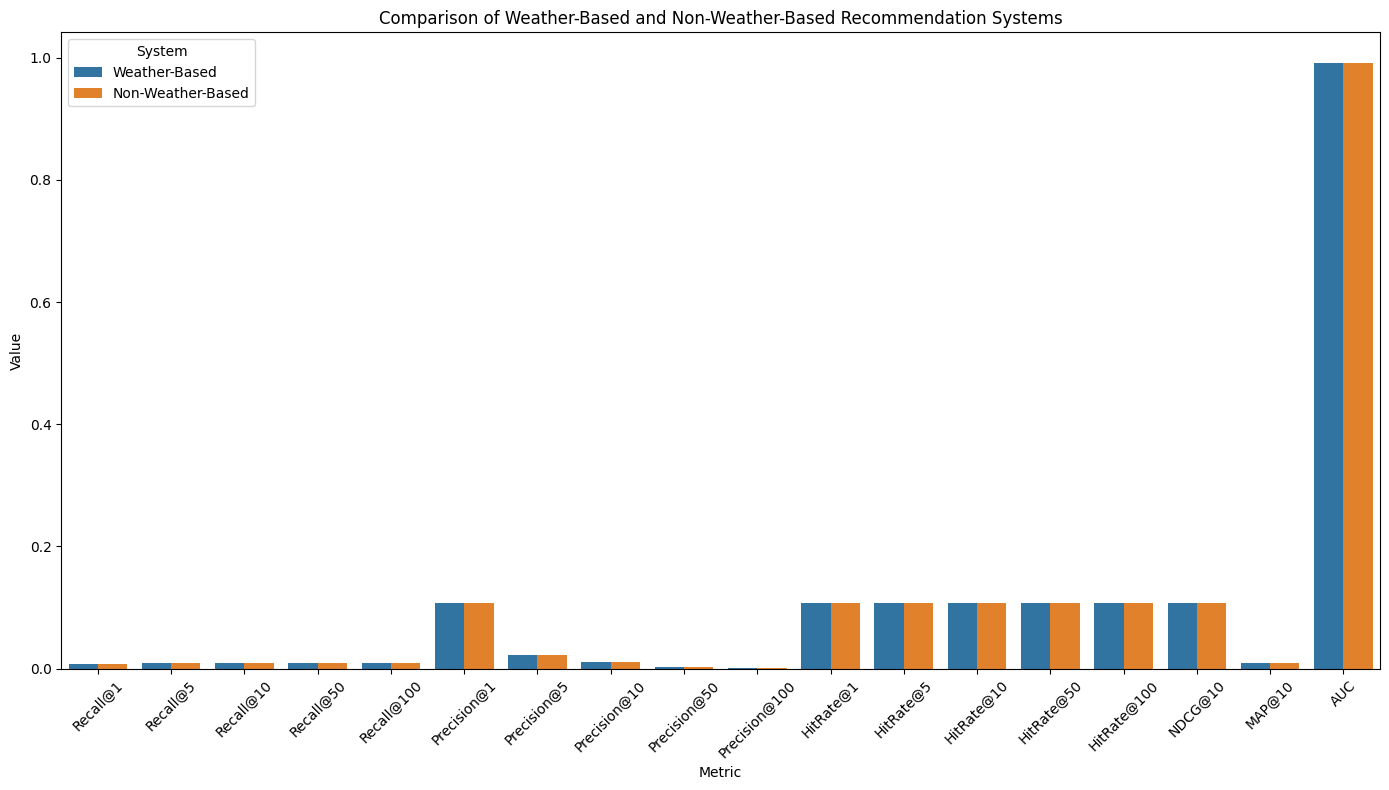


Metrics Results DataFrame:
           Metric  Weather-Based  Non-Weather-Based
0        Recall@1       0.007977           0.007977
1        Recall@5       0.008428           0.008428
2       Recall@10       0.008428           0.008428
3       Recall@50       0.008428           0.008428
4      Recall@100       0.008499           0.008499
5     Precision@1       0.107000           0.107000
6     Precision@5       0.022600           0.022600
7    Precision@10       0.011300           0.011300
8    Precision@50       0.002260           0.002260
9   Precision@100       0.001140           0.001140
10      HitRate@1       0.107000           0.107000
11      HitRate@5       0.107000           0.107000
12     HitRate@10       0.107000           0.107000
13     HitRate@50       0.107000           0.107000
14    HitRate@100       0.108000           0.108000
15        NDCG@10       0.107000           0.107000
16         MAP@10       0.008428           0.008428
17            AUC       0.991629    

In [34]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import faiss
from sklearn.metrics import roc_auc_score, average_precision_score
from catboost import Pool
from geopy.distance import geodesic

# Define features
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "title", "event_category", "event_city"]

NO_WEATHER_SELECTED_FEATURES = ['gender', 'user_city', 'indoor_outdoor_preference', 'age', 'user_interests', 
                               'interaction_type', 'distance_to_event', 'interest_match', 'title', 'event_category',
                               'event_city', 'duration', 'attendance_rate', 'event_indoor_capability']

WEATHER_SELECTED_FEATURES = ['gender', 'user_city', 'indoor_outdoor_preference', 'age', 'user_interests', 
                            'interaction_type', 'distance_to_event', 'interest_match', 'title', 'event_category',
                            'event_city', 'duration', 'weather_condition', 'temperature', 'attendance_rate',
                            'event_indoor_capability']

# Load ranking models (ensure these files exist)
weather_ranking_model = joblib.load("weather_ranking_model_2.pkl")
no_weather_ranking_model = joblib.load("no_weather_ranking_model_2.pkl")

# Assume query_model and candidate_model are defined
# Example placeholder (replace with actual model loading if needed):
# query_model = model.query_model
# candidate_model = model.item_model

# Function definitions
def precompute_item_embeddings(candidate_model, item_df):
    """Generate embeddings for all items using the candidate model."""
    item_features = {
        "event_id": item_df["event_id"].values,
        "title": item_df["title"].values,
        "event_category": item_df["event_category"].values,
        "event_city": item_df["event_city"].values
    }
    item_embeddings = candidate_model(item_features).numpy()
    return item_embeddings, item_df["event_id"].tolist()

def build_faiss_index(item_embeddings):
    """Build a Faiss index for efficient similarity search."""
    faiss.normalize_L2(item_embeddings)
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    return index

def retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=100):
    """Retrieve top-k candidates using the retrieval model."""
    user_embedding_norm = user_embedding.copy()
    faiss.normalize_L2(user_embedding_norm)
    distances, indices = faiss_index.search(user_embedding_norm, top_k)
    candidates = []
    for i, idx in enumerate(indices[0]):
        if idx < len(item_ids):
            item_id = item_ids[idx]
            score = float(distances[0][i])
            item_data = item_df[item_df["event_id"] == item_id]
            if not item_data.empty:
                candidates.append((item_id, score, item_data.iloc[0]))
            else:
                print(f"Warning: item_id {item_id} not found in item_df")
    return candidates

def create_merged_dataframe(users_df, events_df, interactions_df):
    """Create a merged dataframe containing all features from users, events, and interactions."""
    print("Creating merged dataframe")
    print(f"Input users: {len(users_df)}, unique: {users_df['user_id'].nunique()}")
    print(f"Input interactions: {len(interactions_df)}, unique users: {interactions_df['user_id'].nunique()}")
    print(f"Input events: {len(events_df)}, unique: {events_df['event_id'].nunique()}")
    user_interactions = pd.merge(interactions_df, users_df, on='user_id', how='left')
    merged_df = pd.merge(user_interactions, events_df, on='event_id', how='left')
    print(f"Created merged dataframe with {len(merged_df)} rows and {len(merged_df.columns)} columns")
    merged_df["event_indoor_capability"] = merged_df["event_indoor_capability"].astype(str)
    return merged_df

def create_dynamic_fallback_row(user_data, item_data, feature_names):
    """Create a fallback row dynamically matching feature_names."""
    fallback_row = {}
    # Always include event_id
    if "event_id" not in item_data:
        raise ValueError(f"Missing event_id in item_data: {item_data}")
    fallback_row["event_id"] = item_data["event_id"]

    for feature in feature_names:
        if feature == "user_id":
            fallback_row[feature] = user_data["user_id"]
        elif feature == "gender":
            fallback_row[feature] = user_data.get("gender", "unknown")
        elif feature == "user_city":
            fallback_row[feature] = user_data.get("user_city", "unknown")
        elif feature == "indoor_outdoor_preference":
            fallback_row[feature] = user_data.get("indoor_outdoor_preference", "any")
        elif feature == "user_interests":
            fallback_row[feature] = user_data.get("user_interests", "")
        elif feature == "interest_match":
            user_interests = user_data.get("user_interests", "").split(",")
            event_category = item_data.get("event_category", "").lower()
            fallback_row[feature] = int(any(interest.lower() in event_category for interest in user_interests if interest))
        elif feature == "event_category":
            fallback_row[feature] = item_data.get("event_category", "")
        elif feature == "event_city":
            fallback_row[feature] = item_data.get("event_city", "")
        elif feature == "event_lat":
            fallback_row[feature] = item_data.get("event_lat", 0.0)
        elif feature == "event_lon":
            fallback_row[feature] = item_data.get("event_lon", 0.0)
        elif feature == "title":
            fallback_row[feature] = item_data.get("title", "")
        elif feature == "interaction_type":
            fallback_row[feature] = "maybe"
        elif feature == "distance_to_event":
            user_lat = user_data.get("user_lat", 0.0)
            user_lon = user_data.get("user_lon", 0.0)
            event_lat = item_data.get("event_lat", 0.0)
            event_lon = item_data.get("event_lon", 0.0)
            if user_lat and user_lon and event_lat and event_lon:
                fallback_row[feature] = geodesic((user_lat, user_lon), (event_lat, event_lon)).km
            else:
                fallback_row[feature] = 0.0
        elif feature == "duration":
            fallback_row[feature] = item_data.get("duration", 120.0)
        elif feature == "attendance_rate":
            fallback_row[feature] = item_data.get("attendance_rate", 50.0)
        elif feature == "event_indoor_capability":
            fallback_row[feature] = str(item_data.get("event_indoor_capability", "False"))
        elif feature == "weather_condition":
            fallback_row[feature] = item_data.get("weather_condition", "Clear")
        elif feature == "temperature":
            fallback_row[feature] = item_data.get("temperature", 20.0)
        elif feature == "age":
            fallback_row[feature] = user_data.get("age", 30)
        elif feature == "label":
            fallback_row[feature] = 0
        else:
            print(f"Warning: Unknown fallback feature {feature}, filling with 0.")
            fallback_row[feature] = 0.0
    return fallback_row

def rank_candidates(candidates, user_data, merged_df, ranking_model, weather_features=False):
    """Rank candidates using the specified ranking model and merged data."""
    if not candidates:
        return []
    
    candidate_ids = [item_id for item_id, _, _ in candidates]
    user_id = user_data['user_id']
    model_feature_names = ranking_model.feature_names_
    ranking_data = merged_df[
        (merged_df['user_id'] == user_id) &
        (merged_df['event_id'].isin(candidate_ids))
    ]
    if ranking_data.empty:
        temp_rows = []
        for item_id, score, item_data in candidates:
            item_data_dict = {
                "event_id": item_id,
                "event_category": item_data.get("event_category", ""),
                "event_city": item_data.get("event_city", ""),
                "title": item_data.get("title", ""),
                "event_lat": item_data.get("event_lat", 0.0),
                "event_lon": item_data.get("event_lon", 0.0),
                "weather_condition": item_data.get("weather_condition", "Clear"),
                "temperature": item_data.get("temperature", 20.0),
                "duration": item_data.get("duration", 120.0),
                "attendance_rate": item_data.get("attendance_rate", 50.0),
                "event_indoor_capability": str(item_data.get("event_indoor_capability", False))
            }
            fallback_row = create_dynamic_fallback_row(user_data, item_data_dict, model_feature_names)
            temp_rows.append(fallback_row)
        ranking_data = pd.DataFrame(temp_rows)
    
    if 'event_id' not in ranking_data.columns:
        raise ValueError(f"ranking_data is missing 'event_id' column: {ranking_data.columns}")
    
    features = ranking_data[model_feature_names].copy()
    cat_features = [col for col in features.columns if features[col].dtype == 'object']
    pool = Pool(data=features, cat_features=cat_features)
    ranking_scores = ranking_model.predict_proba(pool)[:, 1]
    id_to_score = {row['event_id']: score for row, score in zip(ranking_data.to_dict('records'), ranking_scores)}
    ranked_items = []
    for item_id, retrieval_score, _ in candidates:
        if item_id in id_to_score:
            ranked_items.append((item_id, float(id_to_score[item_id])))
        else:
            ranked_items.append((item_id, float(retrieval_score)))
    ranked_items.sort(key=lambda x: x[1], reverse=True)
    return ranked_items

def recall_at_k(actual_items, recommended_items, k):
    """Calculate Recall@k."""
    if not actual_items:
        return 0.0
    hits = len(set(recommended_items[:k]) & set(actual_items))
    return hits / len(actual_items)

def precision_at_k(actual_items, recommended_items, k):
    """Calculate Precision@k."""
    if k == 0:
        return 0.0
    hits = len(set(recommended_items[:k]) & set(actual_items))
    return hits / k

def hit_rate_at_k(actual_items, recommended_items, k):
    """Calculate Hit Rate@k."""
    if not actual_items:
        return 0.0
    hits = int(len(set(recommended_items[:k]) & set(actual_items)) > 0)
    return hits

def ndcg_at_k(actual_items, recommended_items, k):
    """Calculate NDCG@k."""
    if not actual_items:
        return 0.0
    relevance = [1 if item in actual_items else 0 for item in recommended_items[:k]]
    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
    ideal_relevance = sorted([1 if item in actual_items else 0 for item in recommended_items[:k]], reverse=True)
    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
    return dcg / idcg if idcg > 0 else 0.0

def map_at_k(actual_items, recommended_items, k):
    """Calculate MAP@k."""
    if not actual_items:
        return 0.0
    precisions = []
    relevant_items_count = 0
    for i, item in enumerate(recommended_items[:k]):
        if item in actual_items:
            relevant_items_count += 1
            precisions.append(relevant_items_count / (i + 1))
    return sum(precisions) / len(actual_items) if precisions else 0.0

def calculate_auc(all_scores, all_labels):
    """Calculate AUC."""
    if len(set(all_labels)) < 2:
        return 0.0
    return roc_auc_score(all_labels, all_scores)

def plot_comparison(weather_results, no_weather_results):
    """Plot comparison of weather-based and non-weather-based systems."""
    metrics = []
    weather_values = []
    no_weather_values = []
    for metric in weather_results.keys():
        metrics.append(metric)
        weather_values.append(weather_results[metric])
        no_weather_values.append(no_weather_results[metric])
    df = pd.DataFrame({
        'Metric': metrics,
        'Weather-Based': weather_values,
        'Non-Weather-Based': no_weather_values
    })
    df_melted = df.melt(id_vars='Metric', var_name='System', value_name='Value')
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Metric', y='Value', hue='System', data=df_melted)
    plt.title('Comparison of Weather-Based and Non-Weather-Based Recommendation Systems')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('recsys_comparison.png')
    plt.show()

def evaluate_recsys(query_model, candidate_model, weather_ranking_model, no_weather_ranking_model, 
                    test_df, users_df, events_df, interactions_df, k_values=[1, 5, 10, 50, 100]):
    """Evaluate both recommendation systems on multiple metrics."""
    print("Starting evaluation pipeline...")
    merged_df = create_merged_dataframe(users_df, events_df, interactions_df)
    item_df = events_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    print(f"Found {len(item_df)} unique items for evaluation")
    print("Precomputing item embeddings...")
    item_embeddings, item_ids = precompute_item_embeddings(candidate_model, item_df)
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings.copy())
    
    # Initialize metrics dictionaries
    weather_metrics = {f'Recall@{k}': [] for k in k_values}
    weather_metrics.update({f'Precision@{k}': [] for k in k_values})
    weather_metrics.update({f'HitRate@{k}': [] for k in k_values})
    weather_metrics.update({'NDCG@10': [], 'MAP@10': [], 'AUC_scores': [], 'AUC_labels': []})
    
    no_weather_metrics = {f'Recall@{k}': [] for k in k_values}
    no_weather_metrics.update({f'Precision@{k}': [] for k in k_values})
    no_weather_metrics.update({f'HitRate@{k}': [] for k in k_values})
    no_weather_metrics.update({'NDCG@10': [], 'MAP@10': [], 'AUC_scores': [], 'AUC_labels': []})
    
    user_groups = test_df.groupby("user_id")
    print(f"Evaluating {len(user_groups)} users...")
    for i, (user_id, group) in enumerate(user_groups):
        if i % 200 == 0:
            print(f"Processing user {i}/{len(user_groups)}...")
        user_filtered = users_df[users_df["user_id"] == user_id]
        if user_filtered.empty:
            print(f"Warning: User {user_id} not found in users_df, skipping...")
            continue
        user_data = user_filtered.iloc[0]
        actual_items = group["event_id"].tolist()
        user_features = {
            "user_id": np.array([user_data["user_id"]]),
            "user_city": np.array([user_data["user_city"]]),
            "age": np.array([user_data["age"]], dtype=np.float32),
            "user_interests": np.array([user_data["user_interests"]])
        }
        user_embedding = query_model(user_features).numpy()
        candidates = retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=100)
        weather_ranked_items = rank_candidates(candidates, user_data, merged_df, weather_ranking_model, weather_features=True)
        no_weather_ranked_items = rank_candidates(candidates, user_data, merged_df, no_weather_ranking_model, weather_features=False)
        weather_recommended_ids = [item_id for item_id, _ in weather_ranked_items]
        no_weather_recommended_ids = [item_id for item_id, _ in no_weather_ranked_items]
        
        # Calculate metrics for each k value
        for k in k_values:
            # Recall
            weather_metrics[f'Recall@{k}'].append(recall_at_k(actual_items, weather_recommended_ids, k))
            no_weather_metrics[f'Recall@{k}'].append(recall_at_k(actual_items, no_weather_recommended_ids, k))
            
            # Precision
            weather_metrics[f'Precision@{k}'].append(precision_at_k(actual_items, weather_recommended_ids, k))
            no_weather_metrics[f'Precision@{k}'].append(precision_at_k(actual_items, no_weather_recommended_ids, k))
            
            # Hit Rate
            weather_metrics[f'HitRate@{k}'].append(hit_rate_at_k(actual_items, weather_recommended_ids, k))
            no_weather_metrics[f'HitRate@{k}'].append(hit_rate_at_k(actual_items, no_weather_recommended_ids, k))
        
        # NDCG and MAP at 10
        weather_metrics['NDCG@10'].append(ndcg_at_k(actual_items, weather_recommended_ids, 10))
        weather_metrics['MAP@10'].append(map_at_k(actual_items, weather_recommended_ids, 10))
        no_weather_metrics['NDCG@10'].append(ndcg_at_k(actual_items, no_weather_recommended_ids, 10))
        no_weather_metrics['MAP@10'].append(map_at_k(actual_items, no_weather_recommended_ids, 10))
        
        # AUC data collection
        for item_id, score in weather_ranked_items:
            weather_metrics['AUC_scores'].append(score)
            weather_metrics['AUC_labels'].append(1 if item_id in actual_items else 0)
        for item_id, score in no_weather_ranked_items:
            no_weather_metrics['AUC_scores'].append(score)
            no_weather_metrics['AUC_labels'].append(1 if item_id in actual_items else 0)
    
    # Calculate average metrics
    weather_results = {}
    no_weather_results = {}
    
    # Process all metrics except AUC
    for metric in weather_metrics:
        if metric not in ['AUC_scores', 'AUC_labels']:
            weather_results[metric] = np.mean(weather_metrics[metric])
            no_weather_results[metric] = np.mean(no_weather_metrics[metric])
    
    # Calculate AUC
    weather_results['AUC'] = calculate_auc(weather_metrics['AUC_scores'], weather_metrics['AUC_labels'])
    no_weather_results['AUC'] = calculate_auc(no_weather_metrics['AUC_scores'], no_weather_metrics['AUC_labels'])
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Metric': list(weather_results.keys()),
        'Weather-Based': list(weather_results.values()),
        'Non-Weather-Based': list(no_weather_results.values())
    })
    
    print("\n=== Evaluation Results ===")
    print(results_df)
    
    # Plot comparison
    plot_comparison(weather_results, no_weather_results)
    
    return weather_results, no_weather_results, results_df

# Load synthetic data
# users_df = pd.read_csv('synthetic_users.csv')
# events_df = pd.read_csv('synthetic_events.csv')
# interactions_df = pd.read_csv('synthetic_interactions.csv')

# Split datasets
np.random.seed(42)
n_users_subset = 2000
all_user_ids = users_df['user_id'].unique()
np.random.shuffle(all_user_ids)
user_ids_1 = all_user_ids[:n_users_subset]
user_ids_2 = all_user_ids[n_users_subset:]

# Create DataFrames
test_users_df = users_df[users_df['user_id'].isin(user_ids_1)].copy()
train_users_df = users_df[users_df['user_id'].isin(user_ids_2)].copy()
test_interactions_df = interactions_df[interactions_df['user_id'].isin(user_ids_1)].copy()
train_interactions_df = interactions_df[interactions_df['user_id'].isin(user_ids_2)].copy()
test_events_df = events_df.copy()
train_events_df = events_df.copy()

# Prepare train_df and test_df
train_df = train_interactions_df[train_interactions_df['interaction_label'] == 1][['user_id', 'event_id']]
test_df = test_interactions_df[test_interactions_df['interaction_label'] == 1][['user_id', 'event_id']]

# Verify data
print(f"Test users: {len(test_users_df)}, unique: {test_users_df['user_id'].nunique()}")
print(f"Test interactions: {len(test_interactions_df)}, unique users: {test_interactions_df['user_id'].nunique()}")
print(f"Test events: {len(test_events_df)}, unique: {test_events_df['event_id'].nunique()}")
print(f"Train users: {len(train_users_df)}, unique: {train_users_df['user_id'].nunique()}")
print(f"Train interactions: {len(train_interactions_df)}, unique users: {train_interactions_df['user_id'].nunique()}")
print(f"Train events: {len(train_events_df)}, unique: {train_events_df['event_id'].nunique()}")
print(f"Test df: {len(test_df)}, unique users: {test_df['user_id'].nunique()}")
print(f"Train df: {len(train_df)}, unique users: {train_df['user_id'].nunique()}")

# Evaluate on test set (Dataset 1)
weather_results, no_weather_results, metrics_df = evaluate_recsys(
    query_model, 
    candidate_model, 
    weather_ranking_model, 
    no_weather_ranking_model, 
    test_df,
    test_users_df,
    test_events_df,
    test_interactions_df
)

# Display the metrics DataFrame
print("\nMetrics Results DataFrame:")
print(metrics_df)


Test users: 2001, unique: 2000
Test interactions: 34045, unique users: 2000
Test events: 10000, unique: 10000
Train users: 7999, unique: 7999
Train interactions: 136696, unique users: 7999
Train events: 10000, unique: 10000
Test df: 26665, unique users: 2000
Train df: 107402, unique users: 7999
Starting evaluation pipeline...
Creating merged dataframe
Input users: 2001, unique: 2000
Input interactions: 34045, unique users: 2000
Input events: 10000, unique: 10000
Created merged dataframe with 34068 rows and 26 columns
Found 10000 unique items for evaluation
Precomputing item embeddings...
Building Faiss index...
Evaluating 2000 users...
Processing user 0/2000...
Processing user 200/2000...
Processing user 400/2000...
Processing user 600/2000...
Processing user 800/2000...
Processing user 1000/2000...
Processing user 1200/2000...
Processing user 1400/2000...
Processing user 1600/2000...
Processing user 1800/2000...

=== Evaluation Results ===

Weather-Based Recommendation System:
Recall@

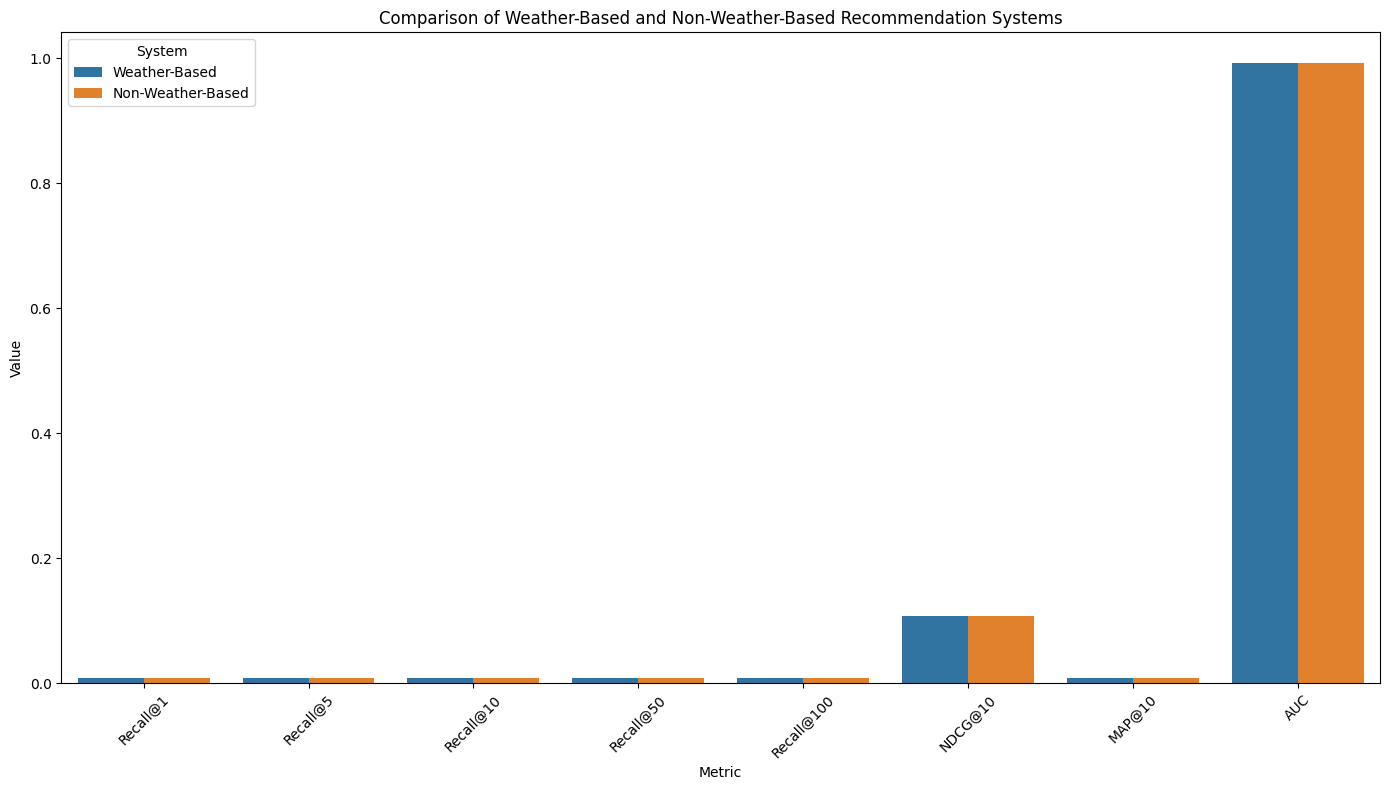

In [62]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import faiss
from sklearn.metrics import roc_auc_score, average_precision_score
from catboost import Pool
from geopy.distance import geodesic

# Define features
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "title", "event_category", "event_city"]

NO_WEATHER_SELECTED_FEATURES = ['gender', 'user_city', 'indoor_outdoor_preference', 'age', 'user_interests', 
                               'interaction_type', 'distance_to_event', 'interest_match', 'title', 'event_category',
                               'event_city', 'duration', 'attendance_rate', 'event_indoor_capability']

WEATHER_SELECTED_FEATURES = ['gender', 'user_city', 'indoor_outdoor_preference', 'age', 'user_interests', 
                            'interaction_type', 'distance_to_event', 'interest_match', 'title', 'event_category',
                            'event_city', 'duration', 'weather_condition', 'temperature', 'attendance_rate',
                            'event_indoor_capability']

# Load ranking models (ensure these files exist)
weather_ranking_model = joblib.load("weather_ranking_model_2.pkl")
no_weather_ranking_model = joblib.load("no_weather_ranking_model_2.pkl")

# Assume query_model and candidate_model are defined
# Example placeholder (replace with actual model loading if needed):
# query_model = model.query_model
# candidate_model = model.item_model

# Function definitions
def precompute_item_embeddings(candidate_model, item_df):
    """Generate embeddings for all items using the candidate model."""
    item_features = {
        "event_id": item_df["event_id"].values,
        "title": item_df["title"].values,
        "event_category": item_df["event_category"].values,
        "event_city": item_df["event_city"].values
    }
    item_embeddings = candidate_model(item_features).numpy()
    return item_embeddings, item_df["event_id"].tolist()

def build_faiss_index(item_embeddings):
    """Build a Faiss index for efficient similarity search."""
    faiss.normalize_L2(item_embeddings)
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    return index

def retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=100):
    """Retrieve top-k candidates using the retrieval model."""
    user_embedding_norm = user_embedding.copy()
    faiss.normalize_L2(user_embedding_norm)
    distances, indices = faiss_index.search(user_embedding_norm, top_k)
    candidates = []
    for i, idx in enumerate(indices[0]):
        if idx < len(item_ids):
            item_id = item_ids[idx]
            score = float(distances[0][i])
            item_data = item_df[item_df["event_id"] == item_id]
            if not item_data.empty:
                candidates.append((item_id, score, item_data.iloc[0]))
            else:
                print(f"Warning: item_id {item_id} not found in item_df")
    return candidates

def create_merged_dataframe(users_df, events_df, interactions_df):
    """Create a merged dataframe containing all features from users, events, and interactions."""
    print("Creating merged dataframe")
    print(f"Input users: {len(users_df)}, unique: {users_df['user_id'].nunique()}")
    print(f"Input interactions: {len(interactions_df)}, unique users: {interactions_df['user_id'].nunique()}")
    print(f"Input events: {len(events_df)}, unique: {events_df['event_id'].nunique()}")
    user_interactions = pd.merge(interactions_df, users_df, on='user_id', how='left')
    merged_df = pd.merge(user_interactions, events_df, on='event_id', how='left')
    print(f"Created merged dataframe with {len(merged_df)} rows and {len(merged_df.columns)} columns")
    merged_df["event_indoor_capability"] = merged_df["event_indoor_capability"].astype(str)
    return merged_df

def create_dynamic_fallback_row(user_data, item_data, feature_names):
    """Create a fallback row dynamically matching feature_names."""
    fallback_row = {}
    # Always include event_id
    if "event_id" not in item_data:
        raise ValueError(f"Missing event_id in item_data: {item_data}")
    fallback_row["event_id"] = item_data["event_id"]

    for feature in feature_names:
        if feature == "user_id":
            fallback_row[feature] = user_data["user_id"]
        elif feature == "gender":
            fallback_row[feature] = user_data.get("gender", "unknown")
        elif feature == "user_city":
            fallback_row[feature] = user_data.get("user_city", "unknown")
        elif feature == "indoor_outdoor_preference":
            fallback_row[feature] = user_data.get("indoor_outdoor_preference", "any")
        elif feature == "user_interests":
            fallback_row[feature] = user_data.get("user_interests", "")
        elif feature == "interest_match":
            user_interests = user_data.get("user_interests", "").split(",")
            event_category = item_data.get("event_category", "").lower()
            fallback_row[feature] = int(any(interest.lower() in event_category for interest in user_interests if interest))
        elif feature == "event_category":
            fallback_row[feature] = item_data.get("event_category", "")
        elif feature == "event_city":
            fallback_row[feature] = item_data.get("event_city", "")
        elif feature == "event_lat":
            fallback_row[feature] = item_data.get("event_lat", 0.0)
        elif feature == "event_lon":
            fallback_row[feature] = item_data.get("event_lon", 0.0)
        elif feature == "title":
            fallback_row[feature] = item_data.get("title", "")
        elif feature == "interaction_type":
            fallback_row[feature] = "maybe"
        elif feature == "distance_to_event":
            user_lat = user_data.get("user_lat", 0.0)
            user_lon = user_data.get("user_lon", 0.0)
            event_lat = item_data.get("event_lat", 0.0)
            event_lon = item_data.get("event_lon", 0.0)
            if user_lat and user_lon and event_lat and event_lon:
                fallback_row[feature] = geodesic((user_lat, user_lon), (event_lat, event_lon)).km
            else:
                fallback_row[feature] = 0.0
        elif feature == "duration":
            fallback_row[feature] = item_data.get("duration", 120.0)
        elif feature == "attendance_rate":
            fallback_row[feature] = item_data.get("attendance_rate", 50.0)
        elif feature == "event_indoor_capability":
            fallback_row[feature] = str(item_data.get("event_indoor_capability", "False"))
        elif feature == "weather_condition":
            fallback_row[feature] = item_data.get("weather_condition", "Clear")
        elif feature == "temperature":
            fallback_row[feature] = item_data.get("temperature", 20.0)
        elif feature == "age":
            fallback_row[feature] = user_data.get("age", 30)
        elif feature == "label":
            fallback_row[feature] = 0
        else:
            print(f"Warning: Unknown fallback feature {feature}, filling with 0.")
            fallback_row[feature] = 0.0
    return fallback_row

def rank_candidates(candidates, user_data, merged_df, ranking_model, weather_features=False):
    """Rank candidates using the specified ranking model and merged data."""
    if not candidates:
        return []
    
    candidate_ids = [item_id for item_id, _, _ in candidates]
    user_id = user_data['user_id']
    model_feature_names = ranking_model.feature_names_
    ranking_data = merged_df[
        (merged_df['user_id'] == user_id) &
        (merged_df['event_id'].isin(candidate_ids))
    ]
    if ranking_data.empty:
        temp_rows = []
        for item_id, score, item_data in candidates:
            item_data_dict = {
                "event_id": item_id,
                "event_category": item_data.get("event_category", ""),
                "event_city": item_data.get("event_city", ""),
                "title": item_data.get("title", ""),
                "event_lat": item_data.get("event_lat", 0.0),
                "event_lon": item_data.get("event_lon", 0.0),
                "weather_condition": item_data.get("weather_condition", "Clear"),
                "temperature": item_data.get("temperature", 20.0),
                "duration": item_data.get("duration", 120.0),
                "attendance_rate": item_data.get("attendance_rate", 50.0),
                "event_indoor_capability": str(item_data.get("event_indoor_capability", False))
            }
            fallback_row = create_dynamic_fallback_row(user_data, item_data_dict, model_feature_names)
            temp_rows.append(fallback_row)
        ranking_data = pd.DataFrame(temp_rows)
    
    if 'event_id' not in ranking_data.columns:
        raise ValueError(f"ranking_data is missing 'event_id' column: {ranking_data.columns}")
    
    features = ranking_data[model_feature_names].copy()
    cat_features = [col for col in features.columns if features[col].dtype == 'object']
    pool = Pool(data=features, cat_features=cat_features)
    ranking_scores = ranking_model.predict_proba(pool)[:, 1]
    id_to_score = {row['event_id']: score for row, score in zip(ranking_data.to_dict('records'), ranking_scores)}
    ranked_items = []
    for item_id, retrieval_score, _ in candidates:
        if item_id in id_to_score:
            ranked_items.append((item_id, float(id_to_score[item_id])))
        else:
            ranked_items.append((item_id, float(retrieval_score)))
    ranked_items.sort(key=lambda x: x[1], reverse=True)
    return ranked_items

def recall_at_k(actual_items, recommended_items, k):
    """Calculate Recall@k."""
    if not actual_items:
        return 0.0
    hits = len(set(recommended_items[:k]) & set(actual_items))
    return hits / len(actual_items)

def precision_at_k(actual_items, recommended_items, k):
    """Calculate Precision@k."""
    if k == 0:
        return 0.0
    hits = len(set(recommended_items[:k]) & set(actual_items))
    return hits / k

def hit_rate_at_k(actual_items, recommended_items, k):
    """Calculate Hit Rate@k."""
    if not actual_items:
        return 0.0
    hits = int(len(set(recommended_items[:k]) & set(actual_items)) > 0)
    return hits

def ndcg_at_k(actual_items, recommended_items, k):
    """Calculate NDCG@k."""
    if not actual_items:
        return 0.0
    relevance = [1 if item in actual_items else 0 for item in recommended_items[:k]]
    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
    ideal_relevance = sorted([1 if item in actual_items else 0 for item in recommended_items[:k]], reverse=True)
    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
    return dcg / idcg if idcg > 0 else 0.0

def map_at_k(actual_items, recommended_items, k):
    """Calculate MAP@k."""
    if not actual_items:
        return 0.0
    precisions = []
    relevant_items_count = 0
    for i, item in enumerate(recommended_items[:k]):
        if item in actual_items:
            relevant_items_count += 1
            precisions.append(relevant_items_count / (i + 1))
    return sum(precisions) / len(actual_items) if precisions else 0.0

def calculate_auc(all_scores, all_labels):
    """Calculate AUC."""
    if len(set(all_labels)) < 2:
        return 0.0
    return roc_auc_score(all_labels, all_scores)

def plot_comparison(weather_results, no_weather_results):
    """Plot comparison of weather-based and non-weather-based systems."""
    metrics = []
    weather_values = []
    no_weather_values = []
    for metric in weather_results.keys():
        metrics.append(metric)
        weather_values.append(weather_results[metric])
        no_weather_values.append(no_weather_results[metric])
    df = pd.DataFrame({
        'Metric': metrics,
        'Weather-Based': weather_values,
        'Non-Weather-Based': no_weather_values
    })
    df_melted = df.melt(id_vars='Metric', var_name='System', value_name='Value')
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Metric', y='Value', hue='System', data=df_melted)
    plt.title('Comparison of Weather-Based and Non-Weather-Based Recommendation Systems')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('recsys_comparison.png')
    plt.show()

def evaluate_recsys(query_model, candidate_model, weather_ranking_model, no_weather_ranking_model, 
                    test_df, users_df, events_df, interactions_df, k_values=[1, 5, 10, 50, 100]):
    """Evaluate both recommendation systems on multiple metrics."""
    print("Starting evaluation pipeline...")
    merged_df = create_merged_dataframe(users_df, events_df, interactions_df)
    item_df = events_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    print(f"Found {len(item_df)} unique items for evaluation")
    print("Precomputing item embeddings...")
    item_embeddings, item_ids = precompute_item_embeddings(candidate_model, item_df)
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings.copy())
    
    # Initialize metrics dictionaries
    weather_metrics = {f'Recall@{k}': [] for k in k_values}
    weather_metrics.update({f'Precision@{k}': [] for k in k_values})
    weather_metrics.update({f'HitRate@{k}': [] for k in k_values})
    weather_metrics.update({'NDCG@10': [], 'MAP@10': [], 'AUC_scores': [], 'AUC_labels': []})
    
    no_weather_metrics = {f'Recall@{k}': [] for k in k_values}
    no_weather_metrics.update({f'Precision@{k}': [] for k in k_values})
    no_weather_metrics.update({f'HitRate@{k}': [] for k in k_values})
    no_weather_metrics.update({'NDCG@10': [], 'MAP@10': [], 'AUC_scores': [], 'AUC_labels': []})
    
    user_groups = test_df.groupby("user_id")
    print(f"Evaluating {len(user_groups)} users...")
    for i, (user_id, group) in enumerate(user_groups):
        if i % 200 == 0:
            print(f"Processing user {i}/{len(user_groups)}...")
        user_filtered = users_df[users_df["user_id"] == user_id]
        if user_filtered.empty:
            print(f"Warning: User {user_id} not found in users_df, skipping...")
            continue
        user_data = user_filtered.iloc[0]
        actual_items = group["event_id"].tolist()
        user_features = {
            "user_id": np.array([user_data["user_id"]]),
            "user_city": np.array([user_data["user_city"]]),
            "age": np.array([user_data["age"]], dtype=np.float32),
            "user_interests": np.array([user_data["user_interests"]])
        }
        user_embedding = query_model(user_features).numpy()
        candidates = retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=100)
        weather_ranked_items = rank_candidates(candidates, user_data, merged_df, weather_ranking_model, weather_features=True)
        no_weather_ranked_items = rank_candidates(candidates, user_data, merged_df, no_weather_ranking_model, weather_features=False)
        weather_recommended_ids = [item_id for item_id, _ in weather_ranked_items]
        no_weather_recommended_ids = [item_id for item_id, _ in no_weather_ranked_items]
        
        # Calculate metrics for each k value
        for k in k_values:
            # Recall
            weather_metrics[f'Recall@{k}'].append(recall_at_k(actual_items, weather_recommended_ids, k))
            no_weather_metrics[f'Recall@{k}'].append(recall_at_k(actual_items, no_weather_recommended_ids, k))
            
            # Precision
            weather_metrics[f'Precision@{k}'].append(precision_at_k(actual_items, weather_recommended_ids, k))
            no_weather_metrics[f'Precision@{k}'].append(precision_at_k(actual_items, no_weather_recommended_ids, k))
            
            # Hit Rate
            weather_metrics[f'HitRate@{k}'].append(hit_rate_at_k(actual_items, weather_recommended_ids, k))
            no_weather_metrics[f'HitRate@{k}'].append(hit_rate_at_k(actual_items, no_weather_recommended_ids, k))
        
        # NDCG and MAP at 10
        weather_metrics['NDCG@10'].append(ndcg_at_k(actual_items, weather_recommended_ids, 10))
        weather_metrics['MAP@10'].append(map_at_k(actual_items, weather_recommended_ids, 10))
        no_weather_metrics['NDCG@10'].append(ndcg_at_k(actual_items, no_weather_recommended_ids, 10))
        no_weather_metrics['MAP@10'].append(map_at_k(actual_items, no_weather_recommended_ids, 10))
        
        # AUC data collection
        for item_id, score in weather_ranked_items:
            weather_metrics['AUC_scores'].append(score)
            weather_metrics['AUC_labels'].append(1 if item_id in actual_items else 0)
        for item_id, score in no_weather_ranked_items:
            no_weather_metrics['AUC_scores'].append(score)
            no_weather_metrics['AUC_labels'].append(1 if item_id in actual_items else 0)
    
    # Calculate average metrics
    weather_results = {}
    no_weather_results = {}
    
    # Process all metrics except AUC
    for metric in weather_metrics:
        if metric not in ['AUC_scores', 'AUC_labels']:
            weather_results[metric] = np.mean(weather_metrics[metric])
            no_weather_results[metric] = np.mean(no_weather_metrics[metric])
    
    # Calculate AUC
    weather_results['AUC'] = calculate_auc(weather_metrics['AUC_scores'], weather_metrics['AUC_labels'])
    no_weather_results['AUC'] = calculate_auc(no_weather_metrics['AUC_scores'], no_weather_metrics['AUC_labels'])
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Metric': list(weather_results.keys()),
        'Weather-Based': list(weather_results.values()),
        'Non-Weather-Based': list(no_weather_results.values())
    })
    
    print("\n=== Evaluation Results ===")
    print(results_df)
    
    # Plot comparison
    plot_comparison(weather_results, no_weather_results)
    
    return weather_results, no_weather_results, results_df

# Load synthetic data
# users_df = pd.read_csv('synthetic_users.csv')
# events_df = pd.read_csv('synthetic_events.csv')
# interactions_df = pd.read_csv('synthetic_interactions.csv')

# Split datasets
np.random.seed(42)
n_users_subset = 2000
all_user_ids = users_df['user_id'].unique()
np.random.shuffle(all_user_ids)
user_ids_1 = all_user_ids[:n_users_subset]
user_ids_2 = all_user_ids[n_users_subset:]

# Create DataFrames
test_users_df = users_df[users_df['user_id'].isin(user_ids_1)].copy()
train_users_df = users_df[users_df['user_id'].isin(user_ids_2)].copy()
test_interactions_df = interactions_df[interactions_df['user_id'].isin(user_ids_1)].copy()
train_interactions_df = interactions_df[interactions_df['user_id'].isin(user_ids_2)].copy()
test_events_df = events_df.copy()
train_events_df = events_df.copy()

# Prepare train_df and test_df
train_df = train_interactions_df[train_interactions_df['interaction_label'] == 1][['user_id', 'event_id']]
test_df = test_interactions_df[test_interactions_df['interaction_label'] == 1][['user_id', 'event_id']]

# Verify data
print(f"Test users: {len(test_users_df)}, unique: {test_users_df['user_id'].nunique()}")
print(f"Test interactions: {len(test_interactions_df)}, unique users: {test_interactions_df['user_id'].nunique()}")
print(f"Test events: {len(test_events_df)}, unique: {test_events_df['event_id'].nunique()}")
print(f"Train users: {len(train_users_df)}, unique: {train_users_df['user_id'].nunique()}")
print(f"Train interactions: {len(train_interactions_df)}, unique users: {train_interactions_df['user_id'].nunique()}")
print(f"Train events: {len(train_events_df)}, unique: {train_events_df['event_id'].nunique()}")
print(f"Test df: {len(test_df)}, unique users: {test_df['user_id'].nunique()}")
print(f"Train df: {len(train_df)}, unique users: {train_df['user_id'].nunique()}")

# Evaluate on test set (Dataset 1)
weather_results, no_weather_results = evaluate_recsys(
    query_model, 
    candidate_model, 
    weather_ranking_model, 
    no_weather_ranking_model, 
    test_df,
    test_users_df,
    test_events_df,
    test_interactions_df
)

In [1]:
import pandas as pd
users_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/sythesize_from_scratch/synthetic_users.csv")
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/sythesize_from_scratch/synthetic_events.csv")
interactions_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/sythesize_from_scratch/synthetic_interactions.csv")

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict, Text
from tensorflow.keras import layers

# # Load the datasets
# users_df = pd.read_csv('synthetic_users.csv')
# events_df = pd.read_csv('synthetic_events.csv')
# interactions_df = pd.read_csv('synthetic_interactions.csv')

print(f"Users: {len(users_df)}")
print(f"Events: {len(events_df)}")
print(f"Interactions: {len(interactions_df)}")

# Select features for users and events
user_features = ['user_id', 'user_city', 'age', 'user_interests']
event_features = ['event_id', 'event_category', 'event_city']

# Create new dataframes with selected features
users = users_df[user_features].copy()
events = events_df[event_features].copy()

# Prepare interaction data - focus on positive interactions for retrieval model
interactions = interactions_df[interactions_df['interaction_label'] == 1][['user_id', 'event_id']].copy()

# Create lookup dictionaries for faster joins
# Keep only the first occurrence of each user_id
# Group by user_id and create a dictionary with lists of values
user_dict = {user_id: group.to_dict('records')[0] for user_id, group in users.groupby('user_id')}

event_dict = events.set_index('event_id').to_dict('index')

# Pre-join the data instead of using filter operations during training
joined_interactions = []
for _, row in interactions.iterrows():
    user_id = row['user_id']
    event_id = row['event_id']
    
    if user_id in user_dict and event_id in event_dict:
        user_data = user_dict[user_id]
        event_data = event_dict[event_id]
        
        joined_interactions.append({
            'user_id': user_id,
            'event_id': event_id,
            'user_city': user_data['user_city'],
            'age': user_data['age'],
            'user_interests': user_data['user_interests'],
            'event_category': event_data['event_category'],
            'event_city': event_data['event_city']
        })

joined_df = pd.DataFrame(joined_interactions)

# Get unique values for categorical features
unique_user_ids = np.unique(users["user_id"].values)
unique_event_ids = np.unique(events["event_id"].values)
unique_user_cities = np.unique(users["user_city"].values)
unique_event_cities = np.unique(events["event_city"].values)
unique_event_categories = np.unique(events["event_category"].values)

# Extract all unique interests
all_interests = set()
for interests_str in users["user_interests"].values:
    interests = interests_str.split(',')
    all_interests.update(interests)
unique_interests = sorted(list(all_interests))

# Convert to TensorFlow datasets - using the pre-joined data
tf_dataset = tf.data.Dataset.from_tensor_slices({
    "user_id": joined_df["user_id"].values,
    "event_id": joined_df["event_id"].values,
    "user_city": joined_df["user_city"].values,
    "age": joined_df["age"].values.astype(np.float32),
    "user_interests": joined_df["user_interests"].values,
    "event_category": joined_df["event_category"].values,
    "event_city": joined_df["event_city"].values
})

# Create a separate dataset for candidate indexing
events_tf = tf.data.Dataset.from_tensor_slices({
    "event_id": events["event_id"].values,
    "event_category": events["event_category"].values,
    "event_city": events["event_city"].values
})

# User model with proper interest processing
class UserModel(tf.keras.Model):
    def __init__(self, unique_user_ids, unique_user_cities, unique_interests):
        super().__init__()
        
        # Embedding layers for user features
        self.user_embedding = tf.keras.Sequential([
            layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            layers.Embedding(len(unique_user_ids) + 1, 32)
        ])
        
        self.city_embedding = tf.keras.Sequential([
            layers.StringLookup(vocabulary=unique_user_cities, mask_token=None),
            layers.Embedding(len(unique_user_cities) + 1, 16)
        ])
        
        # Age normalization and embedding
        self.age_normalization = layers.Normalization(axis=None)
        self.age_normalization.adapt(users["age"].values)
        
        # Process user interests
        self.interests_vectorizer = layers.TextVectorization(
            output_mode='multi_hot',
            vocabulary=unique_interests
        )
        
        # Dense layer to transform interests into an embedding
        self.interests_embedding = layers.Dense(16, activation='relu')
        
        # Combine all features
        self.all_embeddings = tf.keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(32)
        ])
        
    def call(self, inputs):
        user_id_embedding = self.user_embedding(inputs["user_id"])
        city_embedding = self.city_embedding(inputs["user_city"])
        age_normalized = self.age_normalization(tf.reshape(inputs["age"], (-1, 1)))
        
        interests_vector = self.interests_vectorizer(inputs["user_interests"])
        interests_embedding = self.interests_embedding(interests_vector)
        
        # Concatenate all embeddings
        all_features = tf.concat([
            user_id_embedding,
            city_embedding,
            age_normalized,
            interests_embedding
        ], axis=1)
        
        return self.all_embeddings(all_features)

# Event model
class EventModel(tf.keras.Model):
    def __init__(self, unique_event_ids, unique_event_categories, unique_event_cities):
        super().__init__()
        
        # Embedding layers for event features
        self.event_embedding = tf.keras.Sequential([
            layers.StringLookup(vocabulary=unique_event_ids, mask_token=None),
            layers.Embedding(len(unique_event_ids) + 1, 32)
        ])
        
        self.category_embedding = tf.keras.Sequential([
            layers.StringLookup(vocabulary=unique_event_categories, mask_token=None),
            layers.Embedding(len(unique_event_categories) + 1, 16)
        ])
        
        self.city_embedding = tf.keras.Sequential([
            layers.StringLookup(vocabulary=unique_event_cities, mask_token=None),
            layers.Embedding(len(unique_event_cities) + 1, 16)
        ])
        
        # Combine all features
        self.all_embeddings = tf.keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(32)
        ])
        
    def call(self, inputs):
        event_id_embedding = self.event_embedding(inputs["event_id"])
        category_embedding = self.category_embedding(inputs["event_category"])
        city_embedding = self.city_embedding(inputs["event_city"])
        
        # Concatenate all embeddings
        all_features = tf.concat([
            event_id_embedding,
            category_embedding,
            city_embedding
        ], axis=1)
        
        return self.all_embeddings(all_features)

# Retrieval model
class EventRetrievalModel(tfrs.Model):
    def __init__(self, unique_user_ids, unique_event_ids, unique_user_cities, 
                 unique_event_categories, unique_event_cities, unique_interests):
        super().__init__()
        
        # User and event models
        self.user_model = UserModel(unique_user_ids, unique_user_cities, unique_interests)
        self.event_model = EventModel(unique_event_ids, unique_event_categories, unique_event_cities)
        
        # Retrieval task
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=events_tf.batch(128).map(self.event_model)
            )
        )
    
    # Add this method to define the forward pass
    def call(self, features):
        user_embeddings = self.user_model({
            "user_id": features["user_id"],
            "user_city": features["user_city"],
            "age": features["age"],
            "user_interests": features["user_interests"]
        })
        
        return user_embeddings
        
    def compute_loss(self, features, training=False):
        # Get user and event embeddings
        user_embeddings = self.user_model({
            "user_id": features["user_id"],
            "user_city": features["user_city"],
            "age": features["age"],
            "user_interests": features["user_interests"]
        })
        
        event_embeddings = self.event_model({
            "event_id": features["event_id"],
            "event_category": features["event_category"],
            "event_city": features["event_city"]
        })
        
        # Compute retrieval loss
        return self.task(user_embeddings, event_embeddings, compute_metrics=not training)




# Split data into train and test sets
tf.random.set_seed(42)
dataset_size = len(joined_df)
train_size = int(dataset_size * 0.8)

# Use a smaller shuffle buffer to avoid memory issues
shuffled = tf_dataset.shuffle(10000, seed=42, reshuffle_each_iteration=False)
train_data = shuffled.take(train_size).batch(128).prefetch(tf.data.AUTOTUNE)
test_data = shuffled.skip(train_size).batch(128).prefetch(tf.data.AUTOTUNE)

# Initialize and train the model
# Initialize and train the model without checkpointing
model = EventRetrievalModel(
    unique_user_ids=unique_user_ids,
    unique_event_ids=unique_event_ids,
    unique_user_cities=unique_user_cities,
    unique_event_categories=unique_event_categories,
    unique_event_cities=unique_event_cities,
    unique_interests=unique_interests
)

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))


# Train with callbacks for early stopping and checkpointing
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_factorized_top_k/top_100_categorical_accuracy',
    patience=3,
    restore_best_weights=True
)

# model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     filepath='event_recommender_checkpoint',
#     monitor='val_factorized_top_k/top_100_categorical_accuracy',
#     save_best_only=True
# )

# Train the model with validation
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5,
    callbacks=[early_stopping]
)

# Evaluate the model
metrics = model.evaluate(test_data, return_dict=True)
print(f"Evaluation metrics: {metrics}")

# # Create a model for recommendations using ScaNN for faster retrieval
# index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)

# # Index all events
# index.index_from_dataset(
#     events_tf.batch(128).map(lambda x: (x["event_id"], model.event_model(x)))
# )

# # Save the index
# tf.saved_model.save(index, "event_recommender_model")

# Function to get recommendations for a user
def get_recommendations(user_id, top_k=10):
    # Get user features
    user_features = users_df[users_df["user_id"] == user_id].iloc[0]
    
    # Create user input
    user_input = {
        "user_id": tf.constant([user_id]),
        "user_city": tf.constant([user_features["user_city"]]),
        "age": tf.constant([user_features["age"]], dtype=tf.float32),
        "user_interests": tf.constant([user_features["user_interests"]])
    }
    
    # Get recommendations
    scores, event_ids = loaded_model(user_input)
    
    # Convert to list
    event_ids = event_ids.numpy()[0]
    scores = scores.numpy()[0]
    
    # Get event details
    recommended_events = []
    for i in range(min(top_k, len(event_ids))):
        event_id = event_ids[i].decode('utf-8')
        event = events_df[events_df["event_id"] == event_id].iloc[0]
        recommended_events.append({
            "event_id": event_id,
            "title": event["title"],
            "category": event["event_category"],
            "city": event["event_city"],
            "score": float(scores[i])
        })
    
    return recommended_events

# Load the saved model
loaded_model = tf.saved_model.load("event_recommender_model")

# Example: Get recommendations for a user
user_id = users_df["user_id"].iloc[0]
recommendations = get_recommendations(user_id)
print(f"Recommendations for user {user_id}:")
for i, rec in enumerate(recommendations):
    print(f"{i+1}. {rec['title']} ({rec['category']}) - Score: {rec['score']:.4f}")


Users: 10000
Events: 10000
Interactions: 170741
Epoch 1/5
838/838 [==============================] - 28s 33ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 391.0345 - regularization_loss: 0.0000e+00 - total_loss: 391.0345 - val_factorized_top_k/top_1_categorical_accuracy: 0.0013 - val_factorized_top_k/top_5_categorical_accuracy: 0.0088 - val_factorized_top_k/top_10_categorical_accuracy: 0.0179 - val_factorized_top_k/top_50_categorical_accuracy: 0.0894 - val_factorized_top_k/top_100_categorical_accuracy: 0.1747 - val_loss: 182.1522 - val_regularization_loss: 0.0000e+00 - val_total_loss: 182.1522
Epoch 2/5
838/838 [==============================] - 33s 40ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized

ImportError: The scann library is not present. Please install it using `pip install scann` to use the ScaNN layer.

In [4]:
merged_df.info()

NameError: name 'merged_df' is not defined

In [120]:
test_df.head()

interaction_id user_id  user_city  age  \
1                                  BI623H  UP287J     Mumbai   56   
9    e7eb7f68-8f0e-4fff-a578-f05667faf124  MD086Q  São Paulo   33   
50   68e2eefd-b9b0-4b58-85bc-fdf18b2913e0  MJ754M     Mumbai   48   
116  d8c931ff-f2c9-4b3f-bf81-579b4c319eeb  BQ890R    Toronto   42   
214  5ba40a45-d117-4d92-8c97-a70bf5dd4789  KF300W   New York   25   

               user_interests event_id  \
1            tech food travel   IO571I   
9           cinema literature   KH489A   
50        fitness tech travel   IE575G   
116  literature travel sports   OJ131Z   
214                cinema art   VA099I   

                                                 title             event_type  \
1    balanced interactive artificial intelligence t...             Technology   
9    functionbased bandwidthmonitored datawarehouse...           Food & Drink   
50   configurable attitudeoriented implementation c...     Community & Causes   
116  profitfocused hybrid standardization immersive...  Immersive Experiences   
214  customizable background flexibility education ...   Education & Learning   

    event_city  
1       Mumbai  
9       London  
50       Tokyo  
116     London  
214  São Paulo

Starting evaluation pipeline...
creating merged dataframe
Created merged dataframe with 165788 rows and 26 columns
Found 19989 unique items for evaluation
Building Faiss index...
Evaluating 1596 users...
Processing user 0/1596...
Processing user 200/1596...
Processing user 400/1596...
Processing user 600/1596...
Processing user 800/1596...
Processing user 1000/1596...
Processing user 1200/1596...
Processing user 1400/1596...

=== Evaluation Results ===

Weather-Based Recommendation System:
Recall@1: 0.0000
Recall@5: 0.0003
Recall@10: 0.0009
Recall@50: 0.0026
Recall@100: 0.0044
NDCG@10: 0.4050
MAP@10: 0.0005
AUC: 0.5316

Non-Weather-Based Recommendation System:
Recall@1: 0.0000
Recall@5: 0.0002
Recall@10: 0.0005
Recall@50: 0.0025
Recall@100: 0.0044
NDCG@10: 0.3014
MAP@10: 0.0002
AUC: 0.5354


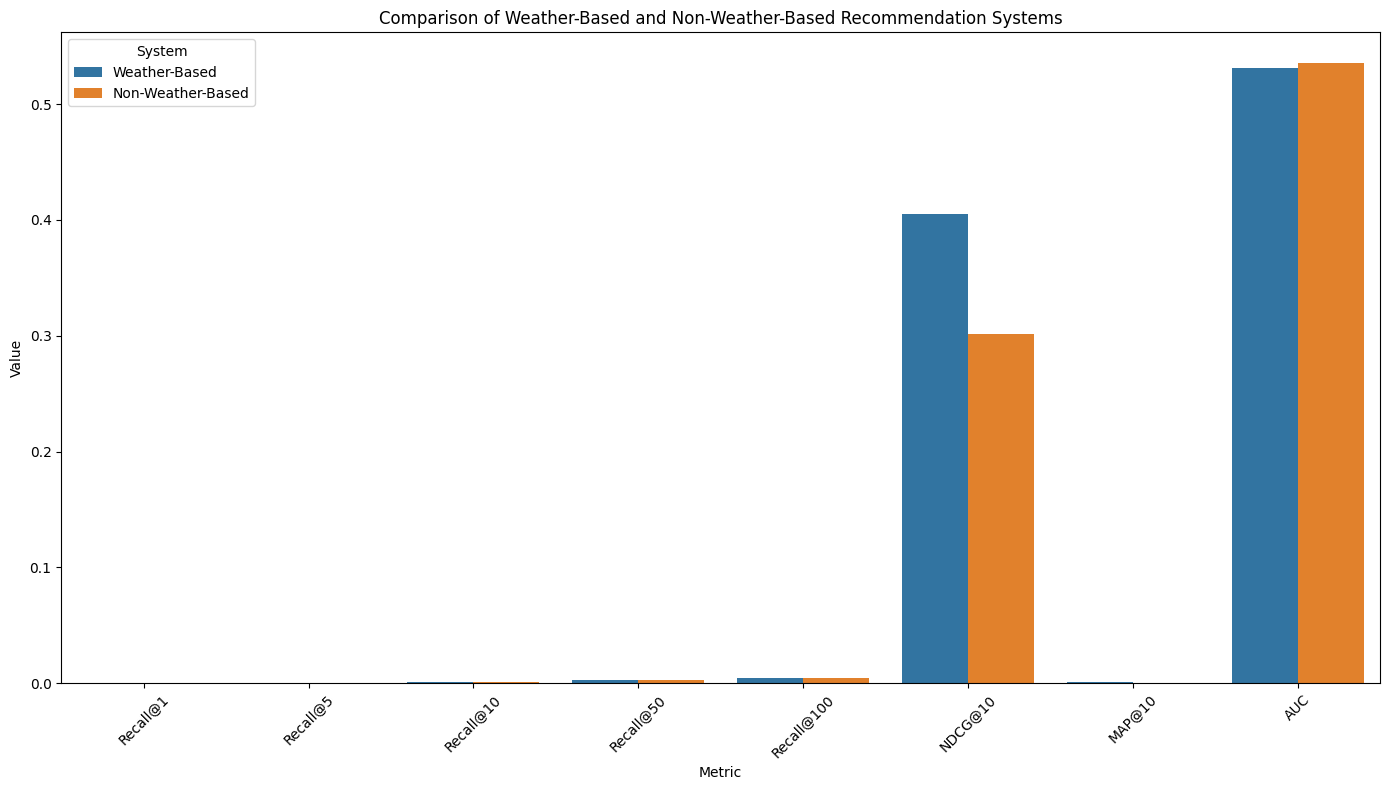

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
from sklearn.metrics import roc_auc_score

# --- Helper: Parse user interests into a set ---
def get_user_interest_set(user_interests_str):
    # Assumes user_interests is a space-separated string
    return set(map(str.lower, str(user_interests_str).split()))

# --- Precompute item embeddings for efficient retrieval ---
def precompute_item_embeddings(candidate_model, item_df):
    item_features = {
        "event_id": item_df["event_id"].values,
        "title": item_df["title"].values,
        "event_type": item_df["event_type"].values,
        "event_city": item_df["event_city"].values
    }
    item_embeddings = candidate_model(item_features).numpy()
    return item_embeddings, item_df["event_id"].tolist()

# --- Build Faiss index for fast retrieval ---
def build_faiss_index(item_embeddings):
    faiss.normalize_L2(item_embeddings)
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    return index

# --- Retrieve top-k candidates using the retrieval model ---
def retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=1000):
    user_embedding_norm = user_embedding.copy()
    faiss.normalize_L2(user_embedding_norm)
    distances, indices = faiss_index.search(user_embedding_norm, top_k)
    candidates = []
    for i, idx in enumerate(indices[0]):
        if idx < len(item_ids):
            item_id = item_ids[idx]
            score = float(distances[0][i])
            item_data = item_df[item_df["event_id"] == item_id]
            if not item_data.empty:
                candidates.append((item_id, score, item_data.iloc[0]))
    return candidates

# --- Create merged dataframe containing all features ---
def create_merged_dataframe():
    print("creating merged dataframe")
    user_interactions = pd.merge(interactions_df, users_df, on='user_id', how='left')
    merged_df = pd.merge(user_interactions, events_df, on='event_id', how='left')
    print(f"Created merged dataframe with {len(merged_df)} rows and {len(merged_df.columns)} columns")
    merged_df["event_indoor_capability"] = merged_df["event_indoor_capability"].astype(str)
    return merged_df

# --- Fallback row builder for ranking model ---
def create_dynamic_fallback_row(user_data, item_data, feature_names):
    fallback_row = {}
    for feature in feature_names:
        if feature == "user_id":
            fallback_row[feature] = user_data["user_id"]
        elif feature == "user_city":
            fallback_row[feature] = user_data.get("user_city", "unknown")
        elif feature == "user_lat":
            fallback_row[feature] = user_data.get("user_lat", 0.0)
        elif feature == "user_lon":
            fallback_row[feature] = user_data.get("user_lon", 0.0)
        elif feature == "user_weather_preference":
            fallback_row[feature] = user_data.get("user_weather_preference", "outdoor")
        elif feature == "user_interests":
            fallback_row[feature] = user_data.get("user_interests", "")
        elif feature == "event_id":
            fallback_row[feature] = item_data["event_id"]
        elif feature == "event_type":
            fallback_row[feature] = item_data["event_type"]
        elif feature == "event_city":
            fallback_row[feature] = item_data["event_city"]
        elif feature == "event_lat":
            fallback_row[feature] = item_data.get("event_lat", 0.0)
        elif feature == "event_lon":
            fallback_row[feature] = item_data.get("event_lon", 0.0)
        elif feature == "title":
            fallback_row[feature] = item_data.get("title", "")
        elif feature == "interaction_distance_to_event":
            fallback_row[feature] = 0.0
        elif feature == "duration":
            fallback_row[feature] = 0.0
        elif feature == "attendance_rate":
            fallback_row[feature] = 0.0
        elif feature == "event_indoor_capability":
            fallback_row[feature] = "False"
        elif feature == "weather_condition":
            fallback_row[feature] = "Clear"
        elif feature == "temperature":
            fallback_row[feature] = 20.0
        elif feature == "age":
            fallback_row[feature] = user_data.get("age", 30)
        elif feature == "label":
            fallback_row[feature] = 0
        else:
            fallback_row[feature] = 0.0
    return fallback_row

# --- Rank candidates using the specified ranking model and merged data ---
def rank_candidates(candidates, user_data, merged_df, ranking_model, weather_features=False):
    if not candidates:
        return []
    candidate_ids = [item_id for item_id, _, _ in candidates]
    user_id = user_data['user_id']
    model_feature_names = ranking_model.feature_names_
    ranking_data = merged_df[
        (merged_df['user_id'] == user_id) &
        (merged_df['event_id'].isin(candidate_ids))
    ]
    if ranking_data.empty:
        temp_rows = []
        for item_id, score, item_data in candidates:
            item_data_dict = {
                "event_id": item_id,
                "event_type": item_data["event_type"],
                "event_city": item_data["event_city"],
                "title": item_data.get("title", ""),
                "event_lat": item_data.get("event_lat", 0.0),
                "event_lon": item_data.get("event_lon", 0.0)
            }
            fallback_row = create_dynamic_fallback_row(user_data, item_data_dict, model_feature_names)
            temp_rows.append(fallback_row)
        ranking_data = pd.DataFrame(temp_rows)
    features = ranking_data[model_feature_names].copy()
    from catboost import Pool
    cat_features = [col for col in features.columns if features[col].dtype == 'object']
    pool = Pool(data=features, cat_features=cat_features)
    ranking_scores = ranking_model.predict_proba(pool)[:, 1]
    id_to_score = {row['event_id']: score for row, score in zip(ranking_data.to_dict('records'), ranking_scores)}
    ranked_items = []
    for item_id, retrieval_score, _ in candidates:
        if item_id in id_to_score:
            ranked_items.append((item_id, float(id_to_score[item_id])))
        else:
            ranked_items.append((item_id, float(retrieval_score)))
    ranked_items.sort(key=lambda x: x[1], reverse=True)
    return ranked_items

# --- Evaluation metrics ---
def recall_at_k(actual_items, recommended_items, k):
    if not actual_items:
        return 0.0
    hits = len(set(recommended_items[:k]) & set(actual_items))
    return hits / len(actual_items)

def ndcg_at_k(actual_items, recommended_items, k):
    if not actual_items:
        return 0.0
    relevance = [1 if item in actual_items else 0 for item in recommended_items[:k]]
    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
    ideal_relevance = sorted([1 if item in actual_items else 0 for item in recommended_items[:k]], reverse=True)
    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
    return dcg / idcg if idcg > 0 else 0.0

def map_at_k(actual_items, recommended_items, k):
    if not actual_items:
        return 0.0
    precisions = []
    relevant_items_count = 0
    for i, item in enumerate(recommended_items[:k]):
        if item in actual_items:
            relevant_items_count += 1
            precisions.append(relevant_items_count / (i + 1))
    return sum(precisions) / len(actual_items) if precisions else 0.0

def calculate_auc(all_scores, all_labels):
    if len(set(all_labels)) < 2:
        return 0.0
    return roc_auc_score(all_labels, all_scores)

# --- Full evaluation pipeline with interest-based relevance ---
def get_user_interest_set(user_interests_str):
    # Assumes user_interests is a space-separated string
    return set(map(str.lower, str(user_interests_str).split()))

def evaluate_recsys(query_model, candidate_model, weather_ranking_model, no_weather_ranking_model, test_df, k_values=[1, 5, 10, 50, 100]):
    print("Starting evaluation pipeline...")

    merged_df = create_merged_dataframe()
    item_df = events_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    print(f"Found {len(item_df)} unique items for evaluation")

    item_embeddings, item_ids = precompute_item_embeddings(candidate_model, item_df)
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings.copy())

    weather_metrics = {k: [] for k in k_values}
    weather_metrics.update({'NDCG': [], 'MAP': [], 'AUC_scores': [], 'AUC_labels': []})

    no_weather_metrics = {k: [] for k in k_values}
    no_weather_metrics.update({'NDCG': [], 'MAP': [], 'AUC_scores': [], 'AUC_labels': []})

    user_groups = test_df.groupby("user_id")
    print(f"Evaluating {len(user_groups)} users...")
    for i, (user_id, group) in enumerate(user_groups):
        if i % 200 == 0:
            print(f"Processing user {i}/{len(user_groups)}...")

        user_filtered = users_df[users_df["user_id"] == user_id]
        if user_filtered.empty:
            print(f"Warning: User {user_id} not found in users_df, skipping...")
            continue
        user_data = user_filtered.iloc[0]

        # --- Interest-based relevance: events whose event_type matches any user interest ---
        user_interest_set = get_user_interest_set(user_data["user_interests"])
        relevant_events = set()
        for _, event_row in events_df.iterrows():
            event_type = str(event_row["event_type"]).lower()
            if any(interest in event_type for interest in user_interest_set):
                relevant_events.add(event_row["event_id"])

        user_features = {
            "user_id": np.array([user_data["user_id"]]),
            "user_city": np.array([user_data["user_city"]]),
            "age": np.array([user_data["age"]], dtype=np.float32),
            "user_interests": np.array([user_data["user_interests"]])
        }
        user_embedding = query_model(user_features).numpy()
        candidates = retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=100)

        weather_ranked_items = rank_candidates(candidates, user_data, merged_df, weather_ranking_model, weather_features=True)
        weather_recommended_ids = [item_id for item_id, _ in weather_ranked_items]

        no_weather_ranked_items = rank_candidates(candidates, user_data, merged_df, no_weather_ranking_model, weather_features=False)
        no_weather_recommended_ids = [item_id for item_id, _ in no_weather_ranked_items]

        for k in k_values:
            weather_metrics[k].append(recall_at_k(relevant_events, weather_recommended_ids, k))
            no_weather_metrics[k].append(recall_at_k(relevant_events, no_weather_recommended_ids, k))

        weather_metrics['NDCG'].append(ndcg_at_k(relevant_events, weather_recommended_ids, 10))
        weather_metrics['MAP'].append(map_at_k(relevant_events, weather_recommended_ids, 10))

        no_weather_metrics['NDCG'].append(ndcg_at_k(relevant_events, no_weather_recommended_ids, 10))
        no_weather_metrics['MAP'].append(map_at_k(relevant_events, no_weather_recommended_ids, 10))

        for item_id, score in weather_ranked_items:
            weather_metrics['AUC_scores'].append(score)
            weather_metrics['AUC_labels'].append(1 if item_id in relevant_events else 0)

        for item_id, score in no_weather_ranked_items:
            no_weather_metrics['AUC_scores'].append(score)
            no_weather_metrics['AUC_labels'].append(1 if item_id in relevant_events else 0)

    weather_results = {}
    no_weather_results = {}
    for k in k_values:
        weather_results[f'Recall@{k}'] = np.mean(weather_metrics[k])
        no_weather_results[f'Recall@{k}'] = np.mean(no_weather_metrics[k])

    weather_results['NDCG@10'] = np.mean(weather_metrics['NDCG'])
    weather_results['MAP@10'] = np.mean(weather_metrics['MAP'])
    weather_results['AUC'] = calculate_auc(weather_metrics['AUC_scores'], weather_metrics['AUC_labels'])

    no_weather_results['NDCG@10'] = np.mean(no_weather_metrics['NDCG'])
    no_weather_results['MAP@10'] = np.mean(no_weather_metrics['MAP'])
    no_weather_results['AUC'] = calculate_auc(no_weather_metrics['AUC_scores'], no_weather_metrics['AUC_labels'])

    print("\n=== Evaluation Results ===")
    print("\nWeather-Based Recommendation System:")
    for metric, value in weather_results.items():
        print(f"{metric}: {value:.4f}")

    print("\nNon-Weather-Based Recommendation System:")
    for metric, value in no_weather_results.items():
        print(f"{metric}: {value:.4f}")

    plot_comparison(weather_results, no_weather_results)
    return weather_results, no_weather_results


def plot_comparison(weather_results, no_weather_results):
    metrics = []
    weather_values = []
    no_weather_values = []
    for metric in weather_results.keys():
        metrics.append(metric)
        weather_values.append(weather_results[metric])
        no_weather_values.append(no_weather_results[metric])
    df = pd.DataFrame({
        'Metric': metrics,
        'Weather-Based': weather_values,
        'Non-Weather-Based': no_weather_values
    })
    df_melted = df.melt(id_vars='Metric', var_name='System', value_name='Value')
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Metric', y='Value', hue='System', data=df_melted)
    plt.title('Comparison of Weather-Based and Non-Weather-Based Recommendation Systems')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('recsys_comparison.png')
    plt.show()

# To run:
weather_results, no_weather_results = evaluate_recsys(
    query_model, candidate_model, weather_ranking_model, no_weather_ranking_model, test_df
)
